# Data Fusion1 Contest 2024 - Задача 2 «Отток»
https://ods.ai/competitions/data-fusion2024-churn

Данные:
1. Табличные клиентские данные:
Участникам доступны несколько наборов данных и артефактов:   
- Базовая информация про все 96,000 клиентов в табличном .csv формате: clients.csv (2.5 MB)
- Тренировочные данные по целевой переменной и времени последней транзакции для 64,000 клиентов: train.csv (745 KB)
- Информация об отчетах, в рамках которых клиенты сгруппированы по времени: report_dates.csv (288 KB)
2. Данные клиентских транзакций:  
- Клиентские транзакции для всех 96,000 клиентов (~13М) в табличном  .csv  формате:  transactions.csv.zip (197 MB)

In [1]:
# !pip install lifelines
# !pip install threadpoolctl==3.1.0

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from scipy.stats import skew, mode

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Включаем tqdm для pandas, чтобы можно было запускать progress_apply() вместо простого apply()
tqdm.pandas() 
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

# Загружаем данные

In [124]:
# Загрузка словарей mcc кодов
# from groups_mcc import type_1_group_mcc_codes_dict, type_2_group_mcc_codes_dict

In [5]:
PATH = ''
DATASETS_PATH = PATH + 'datasets/'

In [6]:
clients_df = pd.read_csv(DATASETS_PATH +  'clients.csv')
src_train_df = pd.read_csv(DATASETS_PATH +  'train.csv')
report_dates_df = pd.read_csv(DATASETS_PATH + 'report_dates.csv')
transactions_df = pd.read_csv(DATASETS_PATH + 'transactions.csv')

currency_df = pd.read_csv(DATASETS_PATH + 'currency_rk.csv')
mcc_codes_df = pd.read_csv(DATASETS_PATH + 'mcc_codes.csv')

clients_df.shape, src_train_df.shape, report_dates_df.shape, transactions_df.shape, currency_df.shape, mcc_codes_df.shape

((96000, 5), (64000, 3), (12, 2), (13075023, 5), (3, 2), (385, 3))

In [7]:
transactions_df['user_id'].unique().shape

(96000,)

In [8]:
# 320 in src_train_df['user_id'].unique()
# 320 in transactions_df['user_id'].unique()
# clients_df.shape

In [9]:
# Загружаем курсы
# Курсы валют за каждый день доступны по ссылке: https://www.cbr.ru/currency_base/dynamics/
# График инфляции и ключ.ставки за каждый месяц доступны по ссылке: https://www.cbr.ru/hd_base/infl/
# Тип используемой валюты
# 1 — рубль
# 2,3 — евро и доллар 
# 0 — все остальное
# Возьмем за 0 белорусский рубль, потому что: 
#   1. он является 3ей самой популярной валютой в Россиии после доллара и евро (https://www.rbc.ru/finances/15/11/2019/5dce1f329a794794883bd4fa)
#   2. курс бел.рубля ~30 руб, что попадает в диапозон 20-40 рублей за большинство других валют
dollar_curs_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/dollar_RC_F01_01_2021_T06_03_2024.xlsx')
euro_curs_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/euro_RC_F01_01_2021_T06_03_2024.xlsx')
belarus_curs_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/belarus_RC_F01_01_2021_T06_03_2024.xlsx')
# Загружаем инфляцию
# Например с января 2021 года по января 2024 года рубль инфляция съела 0,3 рубля
inflation_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/inflation.xlsx').rename(columns={'Месяц': 'month', 'Год': 'year'})

D:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
D:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
D:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [10]:
# inflation_df

## Предварительная обработка

In [11]:
# employee_count_nm - кодируем по возрастанию, т.к. природа фичи подразумевает ранговое представление 
clients_df['employee_count_nm'] = clients_df['employee_count_nm'].fillna('НЕТ')
clients_df['employee_count_nm_code'] = clients_df['employee_count_nm'].replace({
    'НЕТ': 0,
    'ДО 10': 1, 
    'ОТ 11 ДО 30': 2,
    'ОТ 11 ДО 50': 3,
    'ОТ 31 ДО 50': 4,
    'ОТ 51 ДО 100': 5,
    'ОТ 101 ДО 500': 6, 
    'БОЛЕЕ 500': 7,
    'ОТ 501 ДО 1000': 8, 
    'БОЛЕЕ 1001': 9, 
}).fillna(0)

clients_df = clients_df.merge(report_dates_df, on='report', how='left')
clients_df.shape
# clients_df['employee_count_nm'].value_counts(dropna=False)

(96000, 7)

In [12]:
# Обрабатываем даты
dates = pd.to_datetime(transactions_df['transaction_dttm']).dt

In [13]:
# Формируем фичи из даты и времени
transactions_df['date'] = dates.date
transactions_df['weekday'] = dates.weekday
transactions_df['year'] = dates.year
transactions_df['month'] = dates.month
transactions_df['hour'] = dates.hour
# Выходные
transactions_df['is_holiday'] = np.where(transactions_df['weekday'].isin([5, 6]), 1, 0)
# Определяем период начала или конца года
transactions_df['end_of_year'] = np.where(transactions_df['month'].isin([11,12]), 1, 0)
transactions_df['begin_of_year'] = np.where(transactions_df['month'].isin([1,2]), 1, 0)
# Время года
transactions_df['season_of_year'] = np.where(
                    transactions_df['month'].isin([12, 1, 2]), 'winter', 
                    np.where(transactions_df['month'].between(3,5), 'spring',
                        np.where(transactions_df['month'].between(6,8), 'summer', 'fall')
                            )
                    )
# Время дня
transactions_df['time_of_day'] = np.where(
                    transactions_df['hour'].between(0, 4), 'night', 
                    np.where(transactions_df['hour'].between(5, 9), 'morning',
                        np.where(transactions_df['hour'].between(10,18), 'day', 'evening')
                            )
                    )
transactions_df.shape

(13075023, 15)

In [14]:
# transactions_df[transactions_df['month'] == 12][:1]['season_of_year']

In [15]:
# pd.to_datetime(transactions_df['transaction_dttm'][:10]).dt.weekday
# transactions_df['transaction_date']
# date_format.weekday

### Группировка кодов mcc

In [16]:
# import pickle
# with open(DATASETS_PATH + 'outside_dataset/mcc_code_group_1.pkl', 'rb') as file:
#     type_1_group_mcc_codes_dict = pickle.load(file)

# with open(DATASETS_PATH + 'outside_dataset/mcc_code_group_2.pkl', 'rb') as file:
#     type_2_group_mcc_codes_dict = pickle.load(file)

In [17]:
# # Перевод в группы по названиям
# mcc_code_to_group_1 = {}
# for group in type_1_group_mcc_codes_dict:
#     for item in type_1_group_mcc_codes_dict[group]:
#         if len(item.split('-')) > 1:
#             item = item.split('-')
#             for item in range(int(item[0]), int(item[1])+1):
#                 if item not in mcc_code_to_group_1:
#                     mcc_code_to_group_1[item] = group
#         else:
#             item = int(item)
#             if item not in mcc_code_to_group_1:
#                 mcc_code_to_group_1[item] = group

In [18]:
# # Перевод в группы по названиям
# mcc_code_to_group_2 = {}
# for group in type_2_group_mcc_codes_dict:
#     for item in type_2_group_mcc_codes_dict[group]:
#         if item not in mcc_code_to_group_2:
#             mcc_code_to_group_2[item] = group

In [19]:
# mcc_group_1_df = pd.DataFrame.from_dict(mcc_code_to_group_1, orient='index', columns=['group_1'])
# mcc_group_2_df = pd.DataFrame.from_dict(mcc_code_to_group_2, orient='index', columns=['group_2'])

In [20]:
# type_1_group_mcc_codes_dict

In [21]:
# mcc_codes_df

In [22]:
# mcc_codes_df = pd.read_csv(DATASETS_PATH + 'mcc_codes.csv')
# mcc_codes_df = mcc_codes_df.merge(mcc_group_1_df, left_on='MCC', right_index=True, how='left')
# mcc_codes_df = mcc_codes_df.merge(mcc_group_2_df, left_on='Название', right_index=True, how='left')
# # mcc_codes_df

### Нормализация цен
- инфляция за период с 2021 по 2023  
- курс доллара и евро с 2021 по 2023  
- курс "другой" валюты

Курс доллара и евро с 2021 по 2024 за каждый день доступны по ссылке: https://www.cbr.ru/currency_base/dynamics/  
График инфляции и ключ.ставки за каждый месяц доступны по ссылке: https://www.cbr.ru/hd_base/infl/  


Тип валюты:   
1 — рубль    
2,3 — евро и доллар     
0 — все остальное  

In [23]:
# transactions_df['normal_transaction_amt'] = np.where(
#             transactions_df['currency_rk'].isin([2,3]), transactions_df['transaction_amt'] * 95,
#          (np.where(transactions_df['currency_rk'] == 0, transactions_df['transaction_amt']*30, transactions_df['transaction_amt']))
# )

dollar_curs_dict = {d.strftime('%Y-%m-%d') : c for d, c in dollar_curs_df[['data', 'curs']].to_dict('split')['data']}
eu1o_curs_dict = {d.strftime('%Y-%m-%d') : c for d, c in euro_curs_df[['data', 'curs']].to_dict('split')['data']}
belarus_curs_dict = {d.strftime('%Y-%m-%d') : c for d, c in belarus_curs_df[['data', 'curs']].to_dict('split')['data']}

# inflation_df = pd.read_excel(DATASETS_PATH + 'outside_dataset/inflation.xlsx')
# for d, c in belarus_curs_df[['data', 'curs']].to_dict('split')['data']
inflation_dict = {}
for y, m, c in inflation_df[['year', 'month', 'cumulative_inflation']].to_dict('split')['data']:
    if y not in inflation_dict:
        inflation_dict[y] = {}
    inflation_dict[y][m] = c

In [24]:
dollar_curs_df['year'] = dollar_curs_df['data'].dt.year
dollar_curs_df['month'] = dollar_curs_df['data'].dt.month

euro_curs_df['year'] = euro_curs_df['data'].dt.year
euro_curs_df['month'] = euro_curs_df['data'].dt.month

belarus_curs_df['year'] = belarus_curs_df['data'].dt.year
belarus_curs_df['month'] = belarus_curs_df['data'].dt.month

def create_money_dict(df:pd.DataFrame):
    money_dict = {}
    for y, m, c in df.reset_index()[['year', 'month', 'curs']].to_dict('split')['data']:
        if y not in money_dict:
            money_dict[y] = {}
        money_dict[y][m] = c
    return money_dict

dollar_curs_dict = create_money_dict(dollar_curs_df.groupby(by=['year', 'month'])['curs'].mean())
euro_curs_dict = create_money_dict(euro_curs_df.groupby(by=['year', 'month'])['curs'].mean())
belarus_curs_dict = create_money_dict(belarus_curs_df.groupby(by=['year', 'month'])['curs'].mean())
inflation_dict = create_money_dict(inflation_df[['year', 'month', 'cumulative_inflation']].rename(columns={'cumulative_inflation': 'curs'}))



In [25]:
# Нормализация цен
def amt_normalize(x):
    normal_amt = x.transaction_amt
    # Приводим валюту к рублям
    if x.currency_rk == 2:
        normal_amt = normal_amt * euro_curs_dict[x.year][x.month]
    elif x.currency_rk == 3:
        normal_amt = normal_amt * dollar_curs_dict[x.year][x.month]
    elif x.currency_rk == 0:
        normal_amt = normal_amt * belarus_curs_dict[x.year][x.month]
    # Нормируем к инфляции рублевой
    normal_amt = normal_amt * inflation_dict[x.year][x.month]
    return normal_amt

transactions_df['normal_transaction_amt'] = transactions_df.progress_apply(lambda x: amt_normalize(x), axis=1)

 44%|████▍     | 5728437/13075023 [02:03<02:30, 48753.66it/s]

In [26]:
transactions_df['plus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] > 0, transactions_df['normal_transaction_amt'], 0) 
transactions_df['minus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] < 0, transactions_df['normal_transaction_amt'], 0) 

In [27]:
save_transactions_df = transactions_df.copy()
save_transactions_df.shape, transactions_df.shape

## Фичи

### Фичи по пользователю

In [123]:
# mcc_group_transactions_df = transactions_df.merge(mcc_codes_df[['group_1', 'group_2']], left_on='mcc_code', right_index=True) 
# mcc_group_transactions_df = transactions_df.merge(mcc_codes_df[['group_2']], left_on='mcc_code', right_index=True) 
# mcc_group_transactions_df.shape

In [29]:
#agg__mcc_group_transactions_df = mcc_group_transactions_df.copy()
agg__mcc_group_transactions_df = transactions_df.copy()

In [30]:
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.merge(clients_df, on='user_id')
agg__mcc_group_transactions_df['report_dt'] = pd.to_datetime(agg__mcc_group_transactions_df['report_dt'])
agg__mcc_group_transactions_df['transaction_dttm'] = pd.to_datetime(agg__mcc_group_transactions_df['transaction_dttm'])
agg__mcc_group_transactions_df.shape

In [31]:
# from datetime import timedelta
# agg__mcc_group_transactions_df = agg__mcc_group_transactions_df[
#     (agg__mcc_group_transactions_df['transaction_dttm'] > (agg__mcc_group_transactions_df['report_dt'] - timedelta(days=200)))
    
# ]
# agg__mcc_group_transactions_df.shape

In [32]:
# agg__mcc_group_transactions_df['user_id'].unique().shape

In [33]:
# mcc_group_transactions_df

In [34]:
%%time
# https://github.com/pandas-dev/pandas/issues/39983
# transactions_df[transactions_df['mcc_code'].isin(pop_mcc)].groupby(by=['user_id', 'mcc_code']).agg(
# tmp_df = transactions_df.groupby(by=['user_id']).agg(
# tmp_df = mcc_group_transactions_df.groupby(by=['user_id']).agg(
tmp_df = agg__mcc_group_transactions_df.groupby(by=['user_id']).agg(
        amt_count = ('transaction_amt', len),
        amt_sum = ('transaction_amt', sum),
        amt_std = ('transaction_amt', np.std),
        amt_median = ('transaction_amt', np.median),
        amt_min = ('transaction_amt', min),
        amt_max = ('transaction_amt', max),
    
        amt_var = ('transaction_amt', 'var'),
        amt_mad = ('transaction_amt', 'mad'),
        amt_skew = ('transaction_amt', skew),
    
#         amt_normal_sum = ('normal_transaction_amt', sum),
#         amt_normal_std = ('normal_transaction_amt', np.std),
#         amt_normal_median = ('normal_transaction_amt', np.median),
#         amt_normal_min = ('normal_transaction_amt', min),
#         amt_normal_max = ('normal_transaction_amt', max),

        amt_normal_count = ('normal_transaction_amt', len),
        amt_normal_sum = ('normal_transaction_amt', sum),
        amt_normal_std = ('normal_transaction_amt', np.std),
        amt_normal_median = ('normal_transaction_amt', np.median),
        amt_normal_min = ('normal_transaction_amt', min),
        amt_normal_max = ('normal_transaction_amt', max),
        amt_normal_var = ('normal_transaction_amt', 'var'),
        amt_normal_mad = ('normal_transaction_amt', 'mad'),
        amt_normal_skew = ('normal_transaction_amt', skew),            

    
        plus_amt_normal_count = ('plus_normal_transaction_amt', len),
        plus_amt_normal_sum = ('plus_normal_transaction_amt', sum),
        plus_amt_normal_std = ('plus_normal_transaction_amt', np.std),
        plus_amt_normal_median = ('plus_normal_transaction_amt', np.median),
        plus_amt_normal_min = ('plus_normal_transaction_amt', min),
        plus_amt_normal_max = ('plus_normal_transaction_amt', max),
        plus_amt_normal_var = ('plus_normal_transaction_amt', 'var'),
        plus_amt_normal_mad = ('plus_normal_transaction_amt', 'mad'),
        plus_amt_normal_skew = ('plus_normal_transaction_amt', skew),            

    
        minus_amt_normal_count = ('minus_normal_transaction_amt', len),
        minus_amt_normal_sum = ('minus_normal_transaction_amt', sum),
        minus_amt_normal_std = ('minus_normal_transaction_amt', np.std),
        minus_amt_normal_median = ('minus_normal_transaction_amt', np.median),
        minus_amt_normal_min = ('minus_normal_transaction_amt', min),
        minus_amt_normal_max = ('minus_normal_transaction_amt', max),
        minus_amt_normal_var = ('minus_normal_transaction_amt', 'var'),
        minus_amt_normal_mad = ('minus_normal_transaction_amt', 'mad'),
        minus_amt_normal_skew = ('minus_normal_transaction_amt', skew),
    
    
# transactions_df['plus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] > 0, transactions_df['normal_transaction_amt'], 0) 
# transactions_df['minus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] < 0, transactions_df['normal_transaction_amt'], 0)     
    
        uniq_mcc = ('mcc_code', pd.Series.nunique),
        uniq_currency = ('currency_rk', pd.Series.nunique),
        
        min_date = ('date', min),
        max_date = ('date', max),
    
        # Кол-во уникальных дней недели когда клиент совершал операции, если 7 то значит каждый день, если 1 то только в один день
        count_weekday = ('weekday', pd.Series.nunique),
        # Чаще всего встречаемые 
        mode_weekday = ('weekday', mode), # наиболее часто встречающееся значение 
        skew_weekday = ('weekday', skew), # асимметрия 
        
        mean_is_holiday = ('is_holiday', 'mean'),
        mean_end_of_year = ('end_of_year', 'mean'),
        mean_begin_of_year = ('begin_of_year', 'mean'),
        mean_hour = ('hour', 'mean'),
        
    
        mode_month = ('month', mode), # наиболее часто встречающееся значение 
        mode_season_of_year = ('season_of_year', mode), # наиболее часто встречающееся значение 
        mode_time_of_day = ('time_of_day', mode), # наиболее часто встречающееся значение 
        mode_mcc_code = ('mcc_code', mode), # наиболее часто встречающееся значение 
    
#         mode_mcc_group_1 = ('group_1', mode), # наиболее часто встречающееся значение 
#         mode_mcc_group_2 = ('group_2', mode), # наиболее часто встречающееся значение 
        
    
    
        # weekday	is_holiday	month	season_of_year	end_of_year	begin_of_year	hour	time_of_day	year
#         datetime_id = ('datetime_id', np.median),

#         # sum_sum = ('sum', sum),
#         # mean_sum = ('sum', np.mean),
#         median_sum = ('sum', np.median),

#         # sum_avg = ('avg', sum),
#         # mean_avg = ('avg', np.mean),
#         median_avg = ('avg', np.median),

#         # sum_min = ('min', sum),
#         mean_min = ('min', np.mean), 
#         # median_min = ('min', np.median),

#         # sum_max = ('max', sum),
#         # mean_max = ('max', np.mean),
#         median_max = ('max', np.median),

#         # sum_std = ('std', sum),
#         # mean_std = ('std', np.mean),
#         median_std = ('std', np.median),    
        
#         uniq_terminal_09 = ('h3_09', pd.Series.nunique),
#         uniq_terminal_08 = ('h3_08', pd.Series.nunique),
#         uniq_terminal_07 = ('h3_07', pd.Series.nunique),
#         uniq_terminal_06 = ('h3_06', pd.Series.nunique),
#         uniq_customer = ('customer_id', pd.Series.nunique)
    ).add_suffix('__agg_user')  

In [35]:
tmp_df['count_most_weekday__agg_user'] = tmp_df['mode_weekday__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_weekday__agg_user'] = tmp_df['mode_weekday__agg_user'].apply(lambda x: x[0][0])

tmp_df['count_most_month__agg_user'] = tmp_df['mode_month__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_month__agg_user'] = tmp_df['mode_month__agg_user'].apply(lambda x: x[0][0])

tmp_df['count_most_season_of_year__agg_user'] = tmp_df['mode_season_of_year__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_season_of_year__agg_user'] = tmp_df['mode_season_of_year__agg_user'].apply(lambda x: x[0][0])

tmp_df['count_most_time_of_day__agg_user'] = tmp_df['mode_time_of_day__agg_user'].apply(lambda x: x[1][0])
tmp_df['most_time_of_day__agg_user'] = tmp_df['mode_time_of_day__agg_user'].apply(lambda x: x[0][0])

# tmp_df['count_most_mode_mcc_group_1__agg_user'] = tmp_df['mode_mcc_group_1__agg_user'].apply(lambda x: x[1][0])
# tmp_df['most_mode_mcc_group_1__agg_user'] = tmp_df['mode_mcc_group_1__agg_user'].apply(lambda x: x[0][0])

# tmp_df['count_most_mode_mcc_group_2__agg_user'] = tmp_df['mode_mcc_group_2__agg_user'].apply(lambda x: x[1][0])
# tmp_df['most_mode_mcc_group_2__agg_user'] = tmp_df['mode_mcc_group_2__agg_user'].apply(lambda x: x[0][0])

tmp_df.shape

In [36]:
# save_tmp_df = tmp_df.copy()
# tmp_df = save_tmp_df.copy()
# save_tmp_df.shape, tmp_df.shape

### Работает с транзакциями как с двумя сущностями:
    1. Пополнение средств
    2. Трата/оплата услуг и товаров

### Кластеризация пользователей по типу транзакций по коду mcc

In [38]:
# transactions_df[transactions_df['transaction_amt'] == 0]

In [39]:
income_transactions_df = transactions_df[transactions_df['normal_transaction_amt'] > 0]
expense_transactions_df = transactions_df[transactions_df['normal_transaction_amt'] <= 0]

income_transactions_df.shape, expense_transactions_df.shape

In [40]:
# income_transactions_df.shape, expense_transactions_df.shape, transactions_df.shape
# 701030 + 12373993 == 13075023

In [41]:
# transactions_df[transactions_df['transaction_amt'] > 0]['mcc_code'].value_counts()

In [42]:
# transactions_df[transactions_df['transaction_amt'] < 0]['mcc_code'].value_counts()[:100]

In [43]:
# # Формируем вектора клиентов по видам операций (только пополнение)
# user_mcc_transactions_df = pd.pivot_table(income_transactions_df, values='normal_transaction_amt', index=['user_id'],
#                        columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)
# user_mcc_transactions_df.shape

In [44]:
# Формируем вектора клиентов по видам операций с указанием сумм по операциям (только снятие)
expense_user_mcc_transactions_df = pd.pivot_table(expense_transactions_df, values='normal_transaction_amt', index=['user_id'],
                       columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)
expense_user_mcc_transactions_df = np.abs(expense_user_mcc_transactions_df)
expense_user_mcc_transactions_df.shape

In [45]:
# Формируем вектора клиентов по видам операций с указанием сумм по операциям (только снятие)
income_user_mcc_transactions_df = pd.pivot_table(income_transactions_df, values='normal_transaction_amt', index=['user_id'],
                       columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)
income_user_mcc_transactions_df = np.abs(income_user_mcc_transactions_df)
income_user_mcc_transactions_df.shape

In [46]:
expense_user_mcc_transactions_df

In [47]:
# # Формируем вектора клиентов по видам операций с указанием сумм по операциям
# user_mcc_transactions_df = pd.pivot_table(expense_user_mcc_transactions_df, values='normal_transaction_amt', index=['user_id'],
#                        columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)
# user_mcc_transactions_df.shape

In [48]:
# # Нормализация векторов mcc
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# user_mcc_transactions_df = expense_user_mcc_transactions_df
# normal_user_mcc_transactions_df = pd.DataFrame(StandardScaler().fit_transform(user_mcc_transactions_df), columns=user_mcc_transactions_df.columns)
# # normal_user_mcc_transactions_df = pd.DataFrame(MinMaxScaler().fit_transform(user_mcc_transactions_df), columns=user_mcc_transactions_df.columns)
# normal_user_mcc_transactions_df.shape

In [49]:
# def softmax(X, theta = 1.0, axis = None):
#     """
#     Compute the softmax of each element along an axis of X.

#     Parameters
#     ----------
#     X: ND-Array. Probably should be floats. 
#     theta (optional): float parameter, used as a multiplier
#         prior to exponentiation. Default = 1.0
#     axis (optional): axis to compute values along. Default is the 
#         first non-singleton axis.

#     Returns an array the same size as X. The result will sum to 1
#     along the specified axis.
#     """

#     # make X at least 2d
#     y = np.atleast_2d(X)

#     # find axis
#     if axis is None:
#         axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

#     # multiply y against the theta parameter, 
#     y = y * float(theta)

#     # subtract the max for numerical stability
#     y = y - np.expand_dims(np.max(y, axis = axis), axis)

#     # exponentiate y
#     y = np.exp(y)

#     # take the sum along the specified axis
#     ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

#     # finally: divide elementwise
#     p = y / ax_sum

#     # flatten if X was 1D
#     if len(X.shape) == 1: p = p.flatten()

#     return p
# softmax(tmp_ttt)

In [50]:
# tmp_ttt = user_mcc_transactions_df[2:3]#.sum(axis=1)
# # tmp_ttt = tmp_ttt + tmp_ttt.min(axis=1).item() * -1
# tmp_ttt

In [51]:
# x = np.array(tmp_ttt)
# z = x - np.max(x, axis=1)[:, np.newaxis]
# z

In [52]:
# np.exp(u) / np.sum(np.exp(u), axis=1)
# np.exp(z) / np.sum(np.exp(z), axis=1)[:, np.newaxis]

In [53]:
# # from scipy.special import softmax
# def soft_max(z):
#     t = np.exp(z)
#     a = np.exp(z) / np.sum(t, axis=1).reshape(-1,1)
#     return a
# m = softmax(tmp_ttt, axis=1)

# m
# #  softmax(tmp_ttt)[0][152:157]

In [54]:
# # np.argmax(m)
# # np.argmax(tmp_ttt)
# # np.max(tmp_ttt, axis=1)
# m
# expense_user_mcc_transactions_df = expense_user_mcc_transactions_df.drop(columns=['user_group_expense'])

In [55]:
%%time
# https://www.advancinganalytics.co.uk/blog/2022/6/13/10-incredibly-useful-clustering-algorithms-you-need-to-know
# https://machinelearningmastery.com/clustering-algorithms-with-python/
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

X_cluster = expense_user_mcc_transactions_df
pca = PCA(n_components=7)
X_cluster = pd.DataFrame(pca.fit_transform(X_cluster))

model = GaussianMixture(n_components=4)
yhat = model.fit_predict(X_cluster)
yhat
# X_cluster

In [56]:
# Определляем группу для каждого пользоватлея
expense_user_mcc_transactions_df['user_group_expense'] = yhat
# Редкую группу переносим в частую
value_clusters = expense_user_mcc_transactions_df['user_group_expense'].value_counts()
min_cluster = value_clusters.sort_values().index[0]
max_cluster = value_clusters.sort_values().index[-1]
if value_clusters[min_cluster] < 100:
    expense_user_mcc_transactions_df.loc[expense_user_mcc_transactions_df['user_group_expense'] == min_cluster, 'user_group_expense'] = max_cluster
# Переводим в текст, чтобы явно придать катгеорию
expense_user_mcc_transactions_df['user_group_expense'] = expense_user_mcc_transactions_df['user_group_expense'].apply(lambda x: f'user_group_expense_{x}')

In [57]:
# expense_user_mcc_transactions_df = expense_user_mcc_transactions_df.drop(columns=['user_group_expense'])
# income_user_mcc_transactions_df

In [58]:
%%time
# https://www.advancinganalytics.co.uk/blog/2022/6/13/10-incredibly-useful-clustering-algorithms-you-need-to-know
# https://machinelearningmastery.com/clustering-algorithms-with-python/
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

X_cluster = income_user_mcc_transactions_df
pca = PCA(n_components=3)
X_cluster = pd.DataFrame(pca.fit_transform(X_cluster))

model = GaussianMixture(n_components=2)
yhat = model.fit_predict(X_cluster)
yhat
# X_cluster

In [59]:
# # Определляем группу для каждого пользоватлея
# income_user_mcc_transactions_df['user_group_expense'] = yhat

# # Редкую группу переносим в частую
# value_clusters = expense_user_mcc_transactions_df['user_group_expense'].value_counts()
# min_cluster = value_clusters.sort_values().index[0]
# max_cluster = value_clusters.sort_values().index[-1]
# if value_clusters[min_cluster] < 100:
#     expense_user_mcc_transactions_df.loc[expense_user_mcc_transactions_df['user_group_expense'] == min_cluster, 'user_group_expense'] = max_cluster
# # Переводим в текст, чтобы явно придать катгеорию
# expense_user_mcc_transactions_df['user_group_expense'] = expense_user_mcc_transactions_df['user_group_expense'].apply(lambda x: f'user_group_expense_{x}')

In [60]:
# Определляем группу для каждого пользоватлея
income_user_mcc_transactions_df['user_group_income'] = yhat

# Редкую группу переносим в частую
value_clusters = income_user_mcc_transactions_df['user_group_income'].value_counts()
min_cluster = value_clusters.sort_values().index[0]
max_cluster = value_clusters.sort_values().index[-1]
if value_clusters[min_cluster] < 100:
    income_user_mcc_transactions_df.loc[income_user_mcc_transactions_df['user_group_income'] == min_cluster, 'user_group_income'] = max_cluster
# Переводим в текст, чтобы явно придать катгеорию
income_user_mcc_transactions_df['user_group_income'] = income_user_mcc_transactions_df['user_group_income'].apply(lambda x: f'user_group_income_{x}')

In [61]:
# income_user_mcc_transactions_df = income_user_mcc_transactions_df.drop(columns=['user_group_expense'])

In [62]:
# yhat
# user_mcc_transactions_df
# # type(yhat)

In [63]:
# expense_user_mcc_transactions_df


In [64]:
# income_user_mcc_transactions_df

In [65]:
%%time
# https://www.advancinganalytics.co.uk/blog/2022/6/13/10-incredibly-useful-clustering-algorithms-you-need-to-know
# https://machinelearningmastery.com/clustering-algorithms-with-python/
from matplotlib import pyplot
from sklearn.decomposition import PCA
# X = user_mcc_transactions_df
# X = normal_user_mcc_transactions_df
# X = expense_user_mcc_transactions_df
# X = income_user_mcc_transactions_df
# X = income_user_mcc_transactions_df.drop(columns='user_group_income', errors='ignore')
X = expense_user_mcc_transactions_df.drop(columns='user_group_expense', errors='ignore')
# X = res_df
pca = PCA(n_components=10)
pca.fit(X)
X = pca.transform(X)
X = pd.DataFrame(X)
print(X.shape)

from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
# from sklearn.cluster import MeanShift
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.cluster import AffinityPropagation
# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN
# define dataset
# define the model
model = GaussianMixture(n_components=6)
# model = AgglomerativeClustering(n_clusters=3)
# model = SpectralClustering(n_clusters=2) # Memmory
# model = MeanShift()
# model = MiniBatchKMeans(n_clusters=6)
# model = OPTICS(eps=0.8, min_samples=5)
# model = SpectralClustering(n_clusters=2)
# model = DBSCAN(eps=0.30, min_samples=9)
# model = AffinityPropagation(damping=0.9)
# model = KMeans(n_clusters=7, random_state=53, n_init="auto")
# fit the model
# model.fit(X)
# assign a cluster to each example
# yhat = model.predict(X)
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = np.where(yhat == cluster)[0]
 # create scatter of these samples
 pyplot.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 1])
# show the plot
pyplot.show()

In [66]:
unique, counts = np.unique(yhat, return_counts=True)

print(np.asarray((unique, counts)).T)

### Фичи по пользователю отсносительно популярных кодов mcc

In [67]:
# save_transactions_df = transactions_df.copy()
# transactions_df = save_transactions_df.copy()
# save_transactions_df.shape, transactions_df.shape
# agg__mcc_group_transactions_df.mcc_code.value_counts()[:70]

In [68]:
# Определим топ популярных MCC кодов которые используют пользователи, они войдут как отдельные фичи по которым будет сделана группировка
# pop_mcc = transactions_df.mcc_code.value_counts()[:30].index
# pop_mcc = agg__mcc_group_transactions_df.mcc_code.value_counts()[:70].index
pop_mcc = agg__mcc_group_transactions_df.mcc_code.value_counts()[:50].index
pop_mcc_columns = [f'mcc_code___{c}' for c in pop_mcc]

In [69]:
# agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=['mcc_code___1_x', 'mcc_code___2_x', 'mcc_code___4_x', 'mcc_code___3_x', 'mcc_code___0_x', 'mcc_code___11_x', 'mcc_code___6_x', 'mcc_code___8_x', 'mcc_code___7_x', 'mcc_code___9_x', 'mcc_code___17_x', 'mcc_code___10_x', 'mcc_code___14_x', 'mcc_code___13_x', 'mcc_code___155_x', 'mcc_code___15_x', 'mcc_code___12_x', 'mcc_code___26_x', 'mcc_code___32_x', 'mcc_code___28_x', 'mcc_code___33_x', 'mcc_code___18_x', 'mcc_code___22_x', 'mcc_code___23_x', 'mcc_code___21_x', 'mcc_code___25_x', 'mcc_code___20_x', 'mcc_code___27_x', 'mcc_code___16_x', 'mcc_code___52_x', 'mcc_code___1_y', 'mcc_code___2_y', 'mcc_code___4_y', 'mcc_code___3_y', 'mcc_code___0_y', 'mcc_code___11_y', 'mcc_code___6_y', 'mcc_code___8_y', 'mcc_code___7_y', 'mcc_code___9_y', 'mcc_code___17_y', 'mcc_code___10_y', 'mcc_code___14_y', 'mcc_code___13_y', 'mcc_code___155_y', 'mcc_code___15_y', 'mcc_code___12_y', 'mcc_code___26_y', 'mcc_code___32_y', 'mcc_code___28_y', 'mcc_code___33_y', 'mcc_code___18_y', 'mcc_code___22_y', 'mcc_code___23_y', 'mcc_code___21_y', 'mcc_code___25_y', 'mcc_code___20_y', 'mcc_code___27_y', 'mcc_code___16_y', 'mcc_code___52_y', ], errors='ignore')
# agg__mcc_group_transactions_df.shape

In [70]:
# mcc_transactions_df = pd.get_dummies(transactions_df['mcc_code'], prefix='mcc_code__')
mcc_transactions_df = pd.get_dummies(agg__mcc_group_transactions_df['mcc_code'], prefix='mcc_code__')
mcc_transactions_df.shape

In [71]:
# agg__mcc_group_transactions_df

In [72]:
# transactions_df = transactions_df.merge(mcc_transactions_df[pop_mcc_columns], left_index=True, right_index=True)
# transactions_df = transactions_df.merge(mcc_transactions_df[pop_mcc_columns], left_index=True, right_index=True)
# transactions_df.shape

# Удаляем если случайно уже были добавлены
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[f'{i}_x' for i in pop_mcc_columns], errors='ignore')
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[f'{i}_y' for i in pop_mcc_columns], errors='ignore')
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[i for i in pop_mcc_columns], errors='ignore')

agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.merge(mcc_transactions_df[pop_mcc_columns], left_index=True, right_index=True)
agg__mcc_group_transactions_df.shape

In [73]:
# agg__mcc_group_transactions_df

In [74]:
agg__mcc_group_transactions_df['mcc_code'].value_counts()[:10]

In [75]:
# Разбиваем mcc_code на 10 групп
cat_mcc_code = pd.qcut(agg__mcc_group_transactions_df['mcc_code'], 10, duplicates='drop')
agg__mcc_group_transactions_df['cat_mcc_code'] = cat_mcc_code
agg__mcc_group_transactions_df['cat_mcc_code'] = agg__mcc_group_transactions_df['cat_mcc_code'].cat.rename_categories([f'cat_mcc_code_{i}' for i in range(len(agg__mcc_group_transactions_df['cat_mcc_code'].unique())) ])

In [76]:
user_amt_by_mcc_aggregate_df = agg__mcc_group_transactions_df.pivot_table(
                    index='user_id',
                    values=['normal_transaction_amt', 'plus_normal_transaction_amt', 'minus_normal_transaction_amt'],
                    columns=['cat_mcc_code'],
                    aggfunc=['count', 'median', 'sum']
                )
user_amt_by_mcc_aggregate_df.columns = ['___'.join(col).strip() for col in user_amt_by_mcc_aggregate_df.columns.values]
user_amt_by_mcc_aggregate_df.shape

In [77]:
# # agg__mcc_group_transactions_df
# # pivot
# mcc_info = transactions_df[transactions_df.mcc_code.isin(good_codes)].pivot_table(
#     index = 'user_id',
#     values=['transaction_amt'],
#     columns=['mcc_code'],
#     aggfunc=['count', 'median', 'sum']
# ).fillna(0)

# # # Формируем вектора клиентов по видам операций с указанием сумм по операциям (только снятие)
# # expense_user_mcc_transactions_df = pd.pivot_table(expense_transactions_df, values='normal_transaction_amt', index=['user_id'],
# #                        columns=['mcc_code'], aggfunc="sum").rename_axis(None, axis=1).add_prefix('mcc_code_').fillna(0)

In [78]:
agg__mcc_group_transactions_df

In [79]:
%%time
# https://github.com/pandas-dev/pandas/issues/39983
# transactions_df[transactions_df['mcc_code'].isin(pop_mcc)].groupby(by=['user_id', 'mcc_code']).agg(
# tmp_df = transactions_df.groupby(by=['user_id']).agg(
# mcc_tmp_df = transactions_df.groupby(by=['user_id']).agg(
mcc_tmp_df = agg__mcc_group_transactions_df.groupby(by=['user_id']).agg(

sum_mcc_code___1 = ('mcc_code___1', sum),
sum_mcc_code___2 = ('mcc_code___2', sum),
sum_mcc_code___4 = ('mcc_code___4', sum),
sum_mcc_code___3 = ('mcc_code___3', sum),
sum_mcc_code___0 = ('mcc_code___0', sum),
sum_mcc_code___11 = ('mcc_code___11', sum),
sum_mcc_code___6 = ('mcc_code___6', sum),
sum_mcc_code___8 = ('mcc_code___8', sum),
sum_mcc_code___7 = ('mcc_code___7', sum),
sum_mcc_code___9 = ('mcc_code___9', sum),
sum_mcc_code___17 = ('mcc_code___17', sum),
sum_mcc_code___10 = ('mcc_code___10', sum),
sum_mcc_code___14 = ('mcc_code___14', sum),
sum_mcc_code___13 = ('mcc_code___13', sum),
sum_mcc_code___155 = ('mcc_code___155', sum),
sum_mcc_code___15 = ('mcc_code___15', sum),
sum_mcc_code___12 = ('mcc_code___12', sum),
sum_mcc_code___26 = ('mcc_code___26', sum),
sum_mcc_code___32 = ('mcc_code___32', sum),
sum_mcc_code___28 = ('mcc_code___28', sum),
sum_mcc_code___33 = ('mcc_code___33', sum),
sum_mcc_code___18 = ('mcc_code___18', sum),
sum_mcc_code___22 = ('mcc_code___22', sum),
sum_mcc_code___23 = ('mcc_code___23', sum),
sum_mcc_code___21 = ('mcc_code___21', sum),
sum_mcc_code___25 = ('mcc_code___25', sum),
sum_mcc_code___20 = ('mcc_code___20', sum),
sum_mcc_code___27 = ('mcc_code___27', sum),
sum_mcc_code___16 = ('mcc_code___16', sum),
sum_mcc_code___52 = ('mcc_code___52', sum),
sum_mcc_code___24 = ('mcc_code___24', sum),
sum_mcc_code___30 = ('mcc_code___30', sum),
sum_mcc_code___31 = ('mcc_code___31', sum),
sum_mcc_code___44 = ('mcc_code___44', sum),
sum_mcc_code___34 = ('mcc_code___34', sum),
sum_mcc_code___47 = ('mcc_code___47', sum),
sum_mcc_code___61 = ('mcc_code___61', sum),
sum_mcc_code___37 = ('mcc_code___37', sum),
sum_mcc_code___43 = ('mcc_code___43', sum),
sum_mcc_code___50 = ('mcc_code___50', sum),
sum_mcc_code___66 = ('mcc_code___66', sum),
sum_mcc_code___72 = ('mcc_code___72', sum),
sum_mcc_code___45 = ('mcc_code___45', sum),
sum_mcc_code___42 = ('mcc_code___42', sum),
sum_mcc_code___36 = ('mcc_code___36', sum),
sum_mcc_code___39 = ('mcc_code___39', sum),
sum_mcc_code___49 = ('mcc_code___49', sum),
sum_mcc_code___108 = ('mcc_code___108', sum),
sum_mcc_code___51 = ('mcc_code___51', sum),
sum_mcc_code___99 = ('mcc_code___99', sum),
# sum_mcc_code___57 = ('mcc_code___57', sum),
# sum_mcc_code___78 = ('mcc_code___78', sum),
# sum_mcc_code___65 = ('mcc_code___65', sum),
# sum_mcc_code___46 = ('mcc_code___46', sum),
# sum_mcc_code___55 = ('mcc_code___55', sum),
# sum_mcc_code___29 = ('mcc_code___29', sum),
# sum_mcc_code___62 = ('mcc_code___62', sum),
# sum_mcc_code___67 = ('mcc_code___67', sum),
# sum_mcc_code___64 = ('mcc_code___64', sum),
# sum_mcc_code___19 = ('mcc_code___19', sum),
# sum_mcc_code___81 = ('mcc_code___81', sum),
# sum_mcc_code___63 = ('mcc_code___63', sum),
# sum_mcc_code___56 = ('mcc_code___56', sum),
# sum_mcc_code___94 = ('mcc_code___94', sum),
# sum_mcc_code___41 = ('mcc_code___41', sum),
# sum_mcc_code___59 = ('mcc_code___59', sum),
# sum_mcc_code___75 = ('mcc_code___75', sum),
# sum_mcc_code___48 = ('mcc_code___48', sum),
# sum_mcc_code___97 = ('mcc_code___97', sum),
# sum_mcc_code___35 = ('mcc_code___35', sum), 
    
    
    
#         count_mcc_code___0 = ('mcc_code___0', len),
#         sum_mcc_code___0 = ('mcc_code___0', sum),
#         median_mcc_code___0 = ('mcc_code___0', np.median),
#         min_mcc_code___0 = ('mcc_code___0', min),
#         max_mcc_code___0 = ('mcc_code___0', max),
# #         std_mcc_code___0 = ('mcc_code___0', np.std),
# #         var_mcc_code___0 = ('mcc_code___0', 'var'),
# #         mad_mcc_code___0 = ('mcc_code___0', 'mad'),
# #         skew_mcc_code___0 = ('mcc_code___0', skew),

    
#         count_mcc_code___1 = ('mcc_code___1', len),
#         sum_mcc_code___1 = ('mcc_code___1', sum),
#         median_mcc_code___1 = ('mcc_code___1', np.median),
#         min_mcc_code___1 = ('mcc_code___1', min),
#         max_mcc_code___1 = ('mcc_code___1', max),
# #         std_mcc_code___1 = ('mcc_code___1', np.std),
# #         var_mcc_code___1 = ('mcc_code___1', 'var'),
# #         mad_mcc_code___1 = ('mcc_code___1', 'mad'),
# #         skew_mcc_code___1 = ('mcc_code___1', skew),

    
#         count_mcc_code___2 = ('mcc_code___2', len),
#         sum_mcc_code___2 = ('mcc_code___2', sum),
#         median_mcc_code___2 = ('mcc_code___2', np.median),
#         min_mcc_code___2 = ('mcc_code___2', min),
#         max_mcc_code___2 = ('mcc_code___2', max),
# #         std_mcc_code___2 = ('mcc_code___2', np.std),
# #         var_mcc_code___2 = ('mcc_code___2', 'var'),
# #         mad_mcc_code___2 = ('mcc_code___2', 'mad'),
# #         skew_mcc_code___2 = ('mcc_code___2', skew),
    
#         count_mcc_code___3 = ('mcc_code___3', len),
#         sum_mcc_code___3 = ('mcc_code___3', sum),
#         median_mcc_code___3 = ('mcc_code___3', np.median),
#         min_mcc_code___3 = ('mcc_code___3', min),
#         max_mcc_code___3 = ('mcc_code___3', max),
# #         std_mcc_code___3 = ('mcc_code___3', np.std),
# #         var_mcc_code___3 = ('mcc_code___3', 'var'),
# #         mad_mcc_code___3 = ('mcc_code___3', 'mad'),
# #         skew_mcc_code___3 = ('mcc_code___3', skew),
    
#         count_mcc_code___4 = ('mcc_code___4', len),
#         sum_mcc_code___4 = ('mcc_code___4', sum),
#         median_mcc_code___4 = ('mcc_code___4', np.median),
#         min_mcc_code___4 = ('mcc_code___4', min),
#         max_mcc_code___4 = ('mcc_code___4', max),
# #         std_mcc_code___4 = ('mcc_code___4', np.std),
# #         var_mcc_code___4 = ('mcc_code___4', 'var'),
# #         mad_mcc_code___4 = ('mcc_code___4', 'mad'),
# #         skew_mcc_code___4 = ('mcc_code___4', skew),

#         count_mcc_code___11 = ('mcc_code___11', len),
#         sum_mcc_code___11 = ('mcc_code___11', sum),
#         median_mcc_code___11 = ('mcc_code___11', np.median),
#         min_mcc_code___11 = ('mcc_code___11', min),
#         max_mcc_code___11 = ('mcc_code___11', max),
# #         std_mcc_code___11 = ('mcc_code___11', np.std),
# #         var_mcc_code___11 = ('mcc_code___11', 'var'),
# #         mad_mcc_code___11 = ('mcc_code___11', 'mad'),
# #         skew_mcc_code___11 = ('mcc_code___11', skew),

#         count_mcc_code___6 = ('mcc_code___6', len),
#         sum_mcc_code___6 = ('mcc_code___6', sum),
#         median_mcc_code___6 = ('mcc_code___6', np.median),
#         min_mcc_code___6 = ('mcc_code___6', min),
#         max_mcc_code___6 = ('mcc_code___6', max),
# #         std_mcc_code___6 = ('mcc_code___6', np.std),
# #         var_mcc_code___6 = ('mcc_code___6', 'var'),
# #         mad_mcc_code___6 = ('mcc_code___6', 'mad'),
# #         skew_mcc_code___6 = ('mcc_code___6', skew),

#         count_mcc_code___8 = ('mcc_code___8', len),
#         sum_mcc_code___8 = ('mcc_code___8', sum),
#         median_mcc_code___8 = ('mcc_code___8', np.median),
#         min_mcc_code___8 = ('mcc_code___8', min),
#         max_mcc_code___8 = ('mcc_code___8', max),
# #         std_mcc_code___8 = ('mcc_code___8', np.std),
# #         var_mcc_code___8 = ('mcc_code___8', 'var'),
# #         mad_mcc_code___8 = ('mcc_code___8', 'mad'),
# #         skew_mcc_code___8 = ('mcc_code___8', skew),
    
#         count_mcc_code___7 = ('mcc_code___7', len),
#         sum_mcc_code___7 = ('mcc_code___7', sum),
#         median_mcc_code___7 = ('mcc_code___7', np.median),
#         min_mcc_code___7 = ('mcc_code___7', min),
#         max_mcc_code___7 = ('mcc_code___7', max),
# #         std_mcc_code___7 = ('mcc_code___7', np.std),
# #         var_mcc_code___7 = ('mcc_code___7', 'var'),
# #         mad_mcc_code___7 = ('mcc_code___7', 'mad'),
# #         skew_mcc_code___7 = ('mcc_code___7', skew),

#         count_mcc_code___9 = ('mcc_code___9', len),
#         sum_mcc_code___9 = ('mcc_code___9', sum),
#         median_mcc_code___9 = ('mcc_code___9', np.median),
#         min_mcc_code___9 = ('mcc_code___9', min),
#         max_mcc_code___9 = ('mcc_code___9', max),
# #         std_mcc_code___9 = ('mcc_code___9', np.std),
# #         var_mcc_code___9 = ('mcc_code___9', 'var'),
# #         mad_mcc_code___9 = ('mcc_code___9', 'mad'),
# #         skew_mcc_code___9 = ('mcc_code___9', skew),
    
    
    ).add_suffix('__agg_user')  

In [80]:
# tmp_df

In [81]:
mcc_tmp_df.columns

In [82]:
# Softmax

In [83]:
# %%time
# mcc_columns = mcc_tmp_df.columns
# sft_max__mcc_tmp_df = mcc_tmp_df.copy()

# def softmax(x):
#     """Compute softmax values for each sets of scores in x."""
#     return np.exp(x) / np.sum(np.exp(x), axis=0)

# sft_max__mcc_tmp_df[[f'sft_max_{mcc_code}' for mcc_code in mcc_columns]] = sft_max__mcc_tmp_df[mcc_columns].apply(lambda x: softmax(x), axis=1)

# sft_max__mcc_tmp_df.shape, mcc_tmp_df.shape

In [84]:
# tmp_df = tmp_df.merge(mcc_tmp_df, left_index=True, right_index=True)
# tmp_df = tmp_df.merge(sft_max__mcc_tmp_df, left_index=True, right_index=True)
# tmp_df.shape

In [85]:
# tmp_df_2 = tmp_df.drop(columns=['count_mcc_code___0__agg_user', 'sum_mcc_code___0__agg_user_x', 'median_mcc_code___0__agg_user', 'min_mcc_code___0__agg_user', 'max_mcc_code___0__agg_user', 'count_mcc_code___1__agg_user', 'sum_mcc_code___1__agg_user_x', 'median_mcc_code___1__agg_user', 'min_mcc_code___1__agg_user', 'max_mcc_code___1__agg_user', 'count_mcc_code___2__agg_user', 'sum_mcc_code___2__agg_user_x', 'median_mcc_code___2__agg_user', 'min_mcc_code___2__agg_user', 'max_mcc_code___2__agg_user', 'count_mcc_code___3__agg_user', 'sum_mcc_code___3__agg_user_x', 'median_mcc_code___3__agg_user', 'min_mcc_code___3__agg_user', 'max_mcc_code___3__agg_user', 'count_mcc_code___4__agg_user', 'sum_mcc_code___4__agg_user_x', 'median_mcc_code___4__agg_user', 'min_mcc_code___4__agg_user', 'max_mcc_code___4__agg_user', 'count_mcc_code___11__agg_user', 'sum_mcc_code___11__agg_user_x', 'median_mcc_code___11__agg_user', 'min_mcc_code___11__agg_user', 'max_mcc_code___11__agg_user', 'count_mcc_code___6__agg_user', 'sum_mcc_code___6__agg_user_x', 'median_mcc_code___6__agg_user', 'min_mcc_code___6__agg_user', 'max_mcc_code___6__agg_user', 'count_mcc_code___8__agg_user', 'sum_mcc_code___8__agg_user_x', 'median_mcc_code___8__agg_user', 'min_mcc_code___8__agg_user', 'max_mcc_code___8__agg_user', 'count_mcc_code___7__agg_user', 'sum_mcc_code___7__agg_user_x', 'median_mcc_code___7__agg_user', 'min_mcc_code___7__agg_user', 'max_mcc_code___7__agg_user', 'count_mcc_code___9__agg_user', 'sum_mcc_code___9__agg_user_x', 'median_mcc_code___9__agg_user', 'min_mcc_code___9__agg_user', 'max_mcc_code___9__agg_user', 'sum_mcc_code___1__agg_user_y', 'sum_mcc_code___2__agg_user_y', 'sum_mcc_code___4__agg_user_y', 'sum_mcc_code___3__agg_user_y', 'sum_mcc_code___0__agg_user_y', 'sum_mcc_code___11__agg_user_y', 'sum_mcc_code___6__agg_user_y', 'sum_mcc_code___8__agg_user_y', 'sum_mcc_code___7__agg_user_y', 'sum_mcc_code___9__agg_user_y', 'sum_mcc_code___17__agg_user', 'sum_mcc_code___10__agg_user', 'sum_mcc_code___14__agg_user', 'sum_mcc_code___13__agg_user', 'sum_mcc_code___155__agg_user', 'sum_mcc_code___15__agg_user', 'sum_mcc_code___12__agg_user', 'sum_mcc_code___26__agg_user', 'sum_mcc_code___32__agg_user', 'sum_mcc_code___28__agg_user', 'sum_mcc_code___33__agg_user', 'sum_mcc_code___18__agg_user', 'sum_mcc_code___22__agg_user', 'sum_mcc_code___23__agg_user', 'sum_mcc_code___21__agg_user', 'sum_mcc_code___25__agg_user', 'sum_mcc_code___20__agg_user', 'sum_mcc_code___27__agg_user', 'sum_mcc_code___16__agg_user', 'sum_mcc_code___52__agg_user', ], errors='ignore')
# agg_df = agg_df.drop(columns=['count_mcc_code___0__agg_user', 'sum_mcc_code___0__agg_user',
#        'median_mcc_code___0__agg_user', 'min_mcc_code___0__agg_user',
#        'max_mcc_code___0__agg_user', 'count_mcc_code___1__agg_user',
#        'sum_mcc_code___1__agg_user', 'median_mcc_code___1__agg_user',
#        'min_mcc_code___1__agg_user', 'max_mcc_code___1__agg_user',
#        'count_mcc_code___2__agg_user', 'sum_mcc_code___2__agg_user',
#        'median_mcc_code___2__agg_user', 'min_mcc_code___2__agg_user',
#        'max_mcc_code___2__agg_user', 'count_mcc_code___3__agg_user',
#        'sum_mcc_code___3__agg_user', 'median_mcc_code___3__agg_user',
#        'min_mcc_code___3__agg_user', 'max_mcc_code___3__agg_user',
#        'count_mcc_code___4__agg_user', 'sum_mcc_code___4__agg_user',
#        'median_mcc_code___4__agg_user', 'min_mcc_code___4__agg_user',
#        'max_mcc_code___4__agg_user', 'count_mcc_code___11__agg_user',
#        'sum_mcc_code___11__agg_user', 'median_mcc_code___11__agg_user',
#        'min_mcc_code___11__agg_user', 'max_mcc_code___11__agg_user',
#        'count_mcc_code___6__agg_user', 'sum_mcc_code___6__agg_user',
#        'median_mcc_code___6__agg_user', 'min_mcc_code___6__agg_user',
#        'max_mcc_code___6__agg_user', 'count_mcc_code___8__agg_user',
#        'sum_mcc_code___8__agg_user', 'median_mcc_code___8__agg_user',
#        'min_mcc_code___8__agg_user', 'max_mcc_code___8__agg_user',
#        'count_mcc_code___7__agg_user', 'sum_mcc_code___7__agg_user',
#        'median_mcc_code___7__agg_user', 'min_mcc_code___7__agg_user',
#        'max_mcc_code___7__agg_user', 'count_mcc_code___9__agg_user',
#        'sum_mcc_code___9__agg_user', 'median_mcc_code___9__agg_user',
#        'min_mcc_code___9__agg_user', 'max_mcc_code___9__agg_user']
#            )
# agg_df.shape
# tmp_df_2 = tmp_df.copy()
# tmp_df_2 = tmp_df_2.merge(mcc_tmp_df, left_index=True, right_index=True)
# tmp_df_2.shape

In [86]:
# transactions_df[transactions_df['user_id'] == 13]['weekday'].value_counts()
# transactions_df
# agg_df = tmp_df.copy()
agg_df = tmp_df.copy()

agg_df.shape, tmp_df.shape

In [87]:
agg_df = agg_df.merge(user_amt_by_mcc_aggregate_df, left_index=True, right_index=True)
agg_df.shape

In [88]:
agg_df = agg_df.merge(clients_df, on='user_id')
agg_df['report_dt'] = pd.to_datetime(agg_df['report_dt'])
agg_df['max_date__agg_user'] = pd.to_datetime(agg_df['max_date__agg_user'])
agg_df['min_date__agg_user'] = pd.to_datetime(agg_df['min_date__agg_user'])
agg_df['delta_report_last_date'] = (agg_df['report_dt'] - agg_df['max_date__agg_user']).dt.days
agg_df['delta_report_first_date'] = (agg_df['report_dt'] - agg_df['min_date__agg_user']).dt.days
agg_df['delta_first_last_date'] = (agg_df['max_date__agg_user'] - agg_df['min_date__agg_user']).dt.days
# просто счетчики сколько дней прошло от '2010-01-01'
agg_df['days_report_dt'] = (agg_df['report_dt'] - pd.to_datetime('2010-01-01')).dt.days
agg_df['days_min_date'] = (agg_df['min_date__agg_user'] - pd.to_datetime('2010-01-01')).dt.days
agg_df['days_max_date'] = (agg_df['max_date__agg_user'] - pd.to_datetime('2010-01-01')).dt.days
# Встречается inf и -inf  перемножейни, что понятно почему, заменяем на макс/мин
agg_df = agg_df.drop(columns=['amt_prod__agg_user'], errors='ignore')
# ma = agg_df.loc[agg_df['amt_prod__agg_user'] != np.inf, 'amt_prod__agg_user'].max()
# agg_df['amt_prod__agg_user'] = agg_df['amt_prod__agg_user'].replace(np.inf, ma )
# mi = agg_df.loc[agg_df['amt_prod__agg_user'] != -np.inf, 'amt_prod__agg_user'].min()
# agg_df['amt_prod__agg_user'] = agg_df['amt_prod__agg_user'].replace(-np.inf, mi )
agg_df.shape

## Дополнительные Фичи

In [118]:
# # transactions_df['mcc_code'].value_counts()[:100]
# good_codes = transactions_df['mcc_code'].value_counts()
# good_codes = good_codes[good_codes >= 10000]
# good_codes

In [90]:
good_codes = transactions_df['mcc_code'].value_counts()
good_codes = good_codes[good_codes >= 300]

mcc_info = transactions_df[transactions_df.mcc_code.isin(good_codes)].pivot_table(
    index = 'user_id',
    values=['transaction_amt'],
    columns=['mcc_code'],
    aggfunc=['count', 'median', 'sum']
).fillna(0)
mcc_info.columns = ['main_' + '_'.join(map(str, x)) for x in mcc_info.columns]

count_cols = [x for x in mcc_info.columns if 'count' in x]
mcc_info['sum'] = mcc_info[count_cols].sum(axis=1)
for col in count_cols:
    mcc_info[f'{col}_norm'] = mcc_info[col] / mcc_info['sum']
mcc_info.drop('sum', axis=1, inplace=True)
len(mcc_info.columns)

In [91]:
agg_df = agg_df.merge(mcc_info, how='left', left_on='user_id', right_index=True)
agg_df = agg_df.fillna(0)
agg_df.shape

In [92]:
# agg_df

In [93]:
# from typing import List
# def gen_num_features(df:pd.DataFrame, columns:List[str]):
#     add_features = []
#     for column_1 in columns:
#         # df[f'sin_{column_1}'] = np.sin(df[column_1])
#         # add_features.append(f'sin_{column_1}')
#         for column_2 in columns:
#             df[f'{column_1}_{column_2}'] = df[column_1] * df[column_2]
#             add_features.append(f'{column_1}_{column_2}')
#     return df, add_features
# # gen_num_feat_columns = ['amt_count__agg_user', 'amt_var__agg_user',  'amt_mad__agg_user',  'amt_skew__agg_user', 'amt_normal_count__agg_user',  'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'uniq_mcc__agg_user',]
# # [ 'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'amt_normal_var__agg_user', 'amt_normal_skew__agg_user' ]
# gen_num_feat_columns = ['plus_amt_normal_count__agg_user', 'plus_amt_normal_sum__agg_user', 'plus_amt_normal_median__agg_user', 'plus_amt_normal_min__agg_user', 'plus_amt_normal_max__agg_user', 'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'minus_amt_normal_count__agg_user', 'minus_amt_normal_sum__agg_user', 'minus_amt_normal_std__agg_user', 'minus_amt_normal_median__agg_user', 'minus_amt_normal_min__agg_user', 'minus_amt_normal_max__agg_user', 'minus_amt_normal_var__agg_user', 'minus_amt_normal_skew__agg_user',]
# df, add_features = gen_num_features(df=agg_df, columns=gen_num_feat_columns)
# num_features += add_features 
# num_features = list(set(num_features))
# feature_columns = num_features + cat_features
# len(feature_columns)

In [94]:
# Дополнительные признаки
agg_df[f'amt_normal_sum__agg_user__**2'] = agg_df[f'amt_normal_sum__agg_user'] * agg_df[f'amt_normal_sum__agg_user']
agg_df[f'amt_normal_median__agg_user__**2'] = agg_df[f'amt_normal_median__agg_user'] * agg_df[f'amt_normal_median__agg_user']
agg_df[f'amt_normal_max__agg_user__**2'] = agg_df[f'amt_normal_max__agg_user'] * agg_df[f'amt_normal_max__agg_user']
agg_df[f'minus_amt_normal_skew__agg_user__**2'] = agg_df[f'minus_amt_normal_skew__agg_user'] * agg_df[f'minus_amt_normal_skew__agg_user']
agg_df[f'amt_normal_median__agg_user___uniq_mcc__agg_user'] = agg_df[f'amt_normal_median__agg_user'] * agg_df[f'uniq_mcc__agg_user']
agg_df.shape

In [95]:
# agg_df

In [96]:
# # Добавляем группу пользователя, которую определили в рамках кластеризации

# # agg_df = agg_df.merge(user_mcc_transactions_df.reset_index()[['user_id', 'user_group']], on = 'user_id', how='left')
# # agg_df.shape
# agg_df = agg_df.merge(income_user_mcc_transactions_df.reset_index()[['user_id', 'user_group_income']], on = 'user_id', how='left')
# agg_df['user_group_income'] = agg_df['user_group_income'].fillna('user_group_income_0')

In [97]:
# # agg_df = agg_df.merge(income_user_mcc_transactions_df.reset_index()[['user_id', 'user_group_income']], on = 'user_id', how='left')
# # agg_df['user_group_income'] = agg_df['user_group_income'].fillna('user_group_income_0')
# # income_user_mcc_transactions_df['user_group_income'].fillna('user_group_income_0')
# agg_df = agg_df.merge(expense_user_mcc_transactions_df.reset_index()[['user_id', 'user_group_expense']], on = 'user_id', how='left')
# agg_df['user_group_expense'] = agg_df['user_group_expense'].fillna('user_group_expense_0')


In [98]:
# agg_df = agg_df.drop(columns=['user_group'])
# agg_df

In [99]:
# Посчитать софтмакс для sum mcc code
# agg_df.shape

In [100]:
# mcc_codes_df

# Формирвание обучающей выборки

In [101]:
# src_train_df[src_train_df['target'] == 1]['time'].hist(bins=100)
# plt.show()
# src_train_df[src_train_df['target'] == 0]['time'].hist(bins=100)

In [102]:
# train_df = 
# train_df = agg_df['user_id'].isin()
# src_train_df
train_df = agg_df[agg_df['user_id'].isin(src_train_df['user_id'])]
submit_df = agg_df[~agg_df['user_id'].isin(src_train_df['user_id'])]
train_df = train_df.merge(src_train_df, on='user_id')
train_df.shape, submit_df.shape

In [103]:
Dima_current_time_df = pd.read_csv('datasets/Dima_current_time.csv')
Dima_current_time_df = Dima_current_time_df.set_index('user_id').add_suffix('_dima').reset_index()

train_df = train_df.merge(Dima_current_time_df, on='user_id')
submit_df = submit_df.merge(Dima_current_time_df, on='user_id')

train_df.shape, submit_df.shape

In [104]:
#train_df.shape
publ1_df = pd.read_csv('public_notebooks/publ1.csv')
publ1_df = publ1_df.set_index('user_id').add_prefix('publ1_').reset_index()

publ2_df = pd.read_csv('public_notebooks/publ2.csv')
publ2_df = publ2_df.set_index('user_id').add_prefix('publ2_').reset_index()

publ3_df = pd.read_csv('public_notebooks/publ3.csv')
publ3_df = publ3_df.set_index('user_id').add_prefix('publ3_').reset_index()

publ4_df = pd.read_csv('public_notebooks/publ4.csv')
publ4_df = publ4_df.set_index('user_id').add_prefix('publ4_').reset_index()

publ5_df = pd.read_csv('public_notebooks/publ5.csv')
publ5_df = publ5_df.set_index('user_id').add_prefix('publ5_').reset_index()

publ8_df = pd.read_csv('public_notebooks/ivan_publ8.csv')
publ8_df = publ8_df.set_index('user_id').add_prefix('publ8_').reset_index()


publ1_df.shape, publ2_df.shape, publ3_df.shape, publ4_df.shape, publ5_df.shape, publ8_df.shape, 

In [105]:
publ2_df = publ2_df[list(set(publ2_df.columns) - set(['publ2_report_dt', 'publ2_last', 'publ2_employee_count_nm']))]

bad_feats_publ3 = ['publ3_mcc407',  'publ3_mcc309',  'publ3_mccc144',  'publ3_mcc323',  'publ3_mcc228',  'publ3_mccc111',  'publ3_mccc199',  'publ3_mcc154',  'publ3_mccc296',  'publ3_mccc173',  'publ3_mccc234',  'publ3_mccc163',  'publ3_mccc346',  'publ3_mccc287',  'publ3_mccc317',  'publ3_mcc360',  'publ3_mccc340',  'publ3_mccc284',  'publ3_mccc413',  'publ3_mccc297',  'publ3_mccc237',  'publ3_mccc116',  'publ3_mcc330',  'publ3_mccc304',  'publ3_mcc263',  'publ3_mccc407',  'publ3_mccc217',  'publ3_mccc392',  'publ3_mcc297',  'publ3_mccc250',  'publ3_mcc292',  'publ3_mccc228',  'publ3_mcc342',  'publ3_mccc300',  'publ3_mcc287',  'publ3_mccc252',  'publ3_mccc207',  'publ3_mccc356',  'publ3_mccc273',  'publ3_mccc201',  'publ3_mccc168',  'publ3_mcc322',  'publ3_mccc246',  'publ3_mccc342',  'publ3_mccc283',  'publ3_mcc195',  'publ3_mccc259',  'publ3_mccc332',  'publ3_mcc284',  'publ3_mccc322',  'publ3_mcc298',  'publ3_mcc307',  'publ3_mccc310',  'publ3_mcc434',  'publ3_mcc283',  'publ3_mccc382',  'publ3_mccc271',  'publ3_mccc372',  'publ3_mccc154',  'publ3_mccc314',  'publ3_mccc316',  'publ3_mccc278',  'publ3_mccc238',  'publ3_mccc227',  'publ3_mcc221',  'publ3_mccc220',  'publ3_mccc151',  'publ3_mcc276',  'publ3_mccc364',  'publ3_mcc303',  'publ3_mccc309',  'publ3_mcc291',  'publ3_mcc208',  'publ3_mccc298',  'publ3_mccc291',  'publ3_mccc330',  'publ3_mccc226',  'publ3_mccc239',  'publ3_mcc424',  'publ3_mccc177',  'publ3_mcc239',  'publ3_mccc360',  'publ3_mcc392',  'publ3_mccc449',  'publ3_mccc104',  'publ3_mccc253',  'publ3_mccc240',  'publ3_mcc243',  'publ3_mccc243',  'publ3_mccc198',  'publ3_mccc272',  'publ3_mccc235',  'publ3_mccc307',  'publ3_mccc293',  'publ3_mccc269',  'publ3_mccc208',  'publ3_mcc372',  'publ3_mccc270',  'publ3_mcc371',  'publ3_mccc323',  'publ3_mcc413',  'publ3_mcc314',  'publ3_mcc48',  'publ3_mcc293',  'publ3_mcc304',  'publ3_mccc424',  'publ3_mcc300',  'publ3_mccc232',  'publ3_mccc280',  'publ3_mccc241',  'publ3_mcc246',  'publ3_mccc311',  'publ3_mcc238',  'publ3_mcc449',  'publ3_mccc327',  'publ3_mcc273',  'publ3_mccc124',  'publ3_mccc305',  'publ3_mccc274',  'publ3_mccc258',  'publ3_mccc263',  'publ3_mccc266',  'publ3_mccc302',  'publ3_mccc202',  'publ3_mccc92',  'publ3_mccc318',  'publ3_mccc276',  'publ3_mccc167',  'publ3_mccc95',  'publ3_mccc185',  'publ3_mccc242',  'publ3_mcc227',  'publ3_mccc222',  'publ3_mccc251',  'publ3_mccc264',  'publ3_mccc282',  'publ3_mcc198',  'publ3_mcc346',  'publ3_mccc434',  'publ3_mccc338',  'publ3_mcc271',  'publ3_mccc221',  'publ3_mccc231',  'publ3_mccc277',  'publ3_mccc196',  'publ3_mccc200',  'publ3_mcc141',  'publ3_mccc193',  'publ3_mcc250',  'publ3_mcc259',  'publ3_mccc306',  'publ3_mccc236',  'publ3_mccc40',  'publ3_mcc106',  'publ3_mccc303',  'publ3_mccc150',  'publ3_mcc312',  'publ3_mcc274',  'publ3_mccc149',  'publ3_mccc191',  'publ3_mccc412',  'publ3_mccc368',  'publ3_mccc268'] 
publ3_df = publ3_df[list(set(publ3_df.columns) - set(['publ3_employee_count_nm', 'publ2_employee_count_nm']) -set(bad_feats_publ3))]
publ3_df = publ3_df.fillna(0)

publ8_df['publ8_first_account_hit'] = pd.to_datetime(publ8_df['publ8_first_account_hit'])
publ8_df['publ8_last_account_hit'] = pd.to_datetime(publ8_df['publ8_last_account_hit'])
publ8_df['publ8_first_account_charge'] = pd.to_datetime(publ8_df['publ8_first_account_charge'])
publ8_df['publ8_last_account_charge'] = pd.to_datetime(publ8_df['publ8_last_account_charge'])

publ8_df['publ8_first_account_hit'] = publ8_df['publ8_first_account_hit'].fillna(publ8_df['publ8_first_account_charge'] - timedelta(days=200))
publ8_df['publ8_last_account_hit'] = publ8_df['publ8_last_account_hit'].fillna(publ8_df['publ8_first_account_hit'])
publ8_df['publ8_first_account_charge'] = publ8_df['publ8_first_account_charge'].fillna(publ8_df['publ8_first_account_hit'])
publ8_df['publ8_last_account_charge'] = publ8_df['publ8_last_account_charge'].fillna(publ8_df['publ8_first_account_charge'])

publ2_df.shape, publ3_df.shape, publ8_df.shape

In [106]:
publ_df = publ1_df.merge(publ2_df, on='user_id')
publ_df = publ_df.merge(publ3_df, on='user_id')
publ_df = publ_df.merge(publ4_df, on='user_id')
publ_df = publ_df.merge(publ5_df, on='user_id')
publ_df = publ_df.merge(publ8_df, on='user_id')
publ_df.shape

In [107]:
# del publ1_df
# del publ2_df
# del publ3_df
# del publ4_df
# del publ5_df
# del publ8_df

In [108]:
# publ_columns = list(set(publ_df.columns) - set(['user_id']))
# len(publ_columns)

In [109]:
train_df = train_df.merge(publ_df, on='user_id')
submit_df = submit_df.merge(publ_df, on='user_id')
train_df.shape, submit_df.shape

In [110]:
# dates = ['report_dt', 'max_date__agg_user', 'min_date__agg_user']

In [111]:
# # train_df['publ8_first_account_hit']
# from datetime import timedelta
# # publ8_first_account_hit	publ8_first_account_charge
# train_df['publ8_first_account_charge'] = pd.to_datetime(train_df['publ8_first_account_charge'])
# train_df['publ8_first_account_charge'] - timedelta(days=2)

In [112]:
# train_df[['report_dt', 'max_date__agg_user', 'min_date__agg_user', 
#           'publ8_last_account_hit', 'publ8_last_account_charge', 'publ8_first_account_hit', 'publ8_first_account_charge'
#          ]].isna().sum()

In [113]:
transactions_df['transaction_dttm'] = pd.to_datetime(transactions_df['transaction_dttm'])

In [114]:
eps = 1e-5
def speed_charge(sub_df):
    sub_plus_df = sub_df[sub_df['transaction_amt'] > 0]
    sub_minus_df = sub_df[sub_df['transaction_amt'] < 0]
    last_user_date = sub_df['transaction_dttm'].max()
    
    cur_period_sum_plus = sub_plus_df[sub_plus_df['transaction_dttm'].between(last_user_date - timedelta(days=30), last_user_date)]['transaction_amt'].sum()
    pre_period_sum_plus = sub_plus_df[sub_plus_df['transaction_dttm'].between(last_user_date - timedelta(days=60), last_user_date - timedelta(days=30))]['transaction_amt'].sum()
    pre_pre_period_sum_plus = sub_plus_df[sub_plus_df['transaction_dttm'].between(last_user_date - timedelta(days=90), last_user_date - timedelta(days=60))]['transaction_amt'].sum()

    cur_period_sum_minus = abs(sub_minus_df[sub_minus_df['transaction_dttm'].between(last_user_date - timedelta(days=30), last_user_date)]['transaction_amt'].sum())
    pre_period_sum_minus = abs(sub_minus_df[sub_minus_df['transaction_dttm'].between(last_user_date - timedelta(days=60), last_user_date - timedelta(days=30))]['transaction_amt'].sum())
    pre_pre_period_sum_minus = abs(sub_minus_df[sub_minus_df['transaction_dttm'].between(last_user_date - timedelta(days=90), last_user_date - timedelta(days=60))]['transaction_amt'].sum())
    
#     print(f'cur_period_sum_plus :{cur_period_sum_plus}, pre_period_sum_plus: {pre_period_sum_plus}, pre_pre_period_sum_plus: {pre_pre_period_sum_plus}')
#     print(f'cur_period_sum_minus :{cur_period_sum_minus}, pre_period_sum_minus: {pre_period_sum_minus}, pre_pre_period_sum_minus: {pre_pre_period_sum_minus}')
    
    plus_speed_cur = cur_period_sum_plus / (pre_period_sum_plus + eps)
    plus_speed_pre = pre_period_sum_plus / (pre_pre_period_sum_plus + eps)
    plus_speed_cur_prepre = cur_period_sum_plus / (pre_pre_period_sum_plus + eps)
    
    minus_speed_cur = cur_period_sum_minus / (pre_period_sum_minus + eps)
    minus_speed_pre = pre_period_sum_minus / (pre_pre_period_sum_minus + eps)
    minus_speed_cur_prepre = cur_period_sum_minus / (pre_pre_period_sum_minus + eps)
    
    return (cur_period_sum_plus, pre_period_sum_plus, pre_pre_period_sum_plus, 
            cur_period_sum_minus, pre_period_sum_minus, pre_pre_period_sum_minus, 
            plus_speed_cur, plus_speed_pre, plus_speed_cur_prepre, minus_speed_cur, 
            minus_speed_pre, minus_speed_cur_prepre) 
            

speed_charge_df = transactions_df.groupby(by='user_id').progress_apply(lambda x: pd.Series(speed_charge(x)))
speed_charge_df.columns = [
                    'plus_speed_cur', 'plus_speed_pre', 'plus_speed_cur_prepre', 'minus_speed_cur', 
                    'minus_speed_pre', 'minus_speed_cur_prepre', 'cur_period_sum_plus', 'pre_period_sum_plus', 
                    'pre_pre_period_sum_plus', 'cur_period_sum_minus', 'pre_period_sum_minus', 'pre_pre_period_sum_minus',     
]
speed_charge_df.shape

In [115]:
# save_speed_charge_df = speed_charge_df.copy()
speed_charge_df = speed_charge_df.add_prefix('publ8_sch_').reset_index()
speed_charge_df.shape

In [116]:
train_df = train_df.merge(speed_charge_df, on='user_id')
submit_df = submit_df.merge(speed_charge_df, on='user_id')
train_df.shape, submit_df.shape

In [117]:
# save_train_df = train_df.copy()
# save_submit_df = submit_df.copy()

save_train_df.shape, save_submit_df.shape

In [ ]:
# agg_df
# sum_mcc_code___1__agg_user

In [119]:
# target_columns = ['target', 'time']
# dates = ['report_dt', 'max_date__agg_user', 'min_date__agg_user']
# ignore = ['mode_weekday__agg_user', 'mode_month__agg_user', 'mode_time_of_day__agg_user', 'mode_season_of_year__agg_user', 'mode_mcc_code__agg_user',] + dates
# cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm', 
#                 'most_mode_mcc_group_1__agg_user', 'most_mode_mcc_group_2__agg_user',
#                ]

# num_features = [
#        'amt_count__agg_user', 'amt_sum__agg_user',
#        'amt_std__agg_user', 'amt_median__agg_user', 'amt_min__agg_user',
#        'amt_max__agg_user', 'amt_var__agg_user',
#        'amt_mad__agg_user', 'amt_skew__agg_user', 
#         'uniq_mcc__agg_user',
#        'uniq_currency__agg_user', 'count_weekday__agg_user',
#        'skew_weekday__agg_user', 'mean_is_holiday__agg_user',
#        'mean_end_of_year__agg_user', 'mean_begin_of_year__agg_user',
#        'mean_hour__agg_user', 'count_most_weekday__agg_user',
#        'most_weekday__agg_user', 'count_most_month__agg_user',
#        'most_month__agg_user', 'count_most_season_of_year__agg_user',
#        'count_most_time_of_day__agg_user', 'report', 
#         'count_most_mode_mcc_group_1__agg_user', 'count_most_mode_mcc_group_2__agg_user',
                
#        'bankemplstatus', 'customer_age', 'employee_count_nm_code', 
#        'delta_report_last_date', 'delta_report_first_date', 'days_report_dt',
#        'days_min_date', 'days_max_date',
#         'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'amt_normal_var__agg_user', 'amt_normal_mad__agg_user', 'amt_normal_skew__agg_user', 
#                ]
# feature_columns = num_features + cat_features
# len(feature_columns)

In [127]:
target_columns = ['target', 'time']
# dates = ['report_dt', 'max_date__agg_user', 'min_date__agg_user']
dates = ['report_dt', 'max_date__agg_user', 'min_date__agg_user', 'publ8_last_account_hit', 'publ8_last_account_charge', 'publ8_first_account_hit', 'publ8_first_account_charge']
ignore = ['user_id', 'mode_weekday__agg_user', 'mode_month__agg_user', 'mode_time_of_day__agg_user', 'mode_season_of_year__agg_user', 'mode_mcc_code__agg_user',] + dates
# cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm', 'user_group_income', 'user_group_expense'] 
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 
#+ ['most_mode_mcc_group_1__agg_user', 'most_mode_mcc_group_2__agg_user', ]

# num_features = ['amt_count__agg_user', 'amt_sum__agg_user',
#        'amt_std__agg_user', 'amt_median__agg_user', 'amt_min__agg_user',
#        'amt_max__agg_user', 'amt_var__agg_user',
#        'amt_mad__agg_user', 'amt_skew__agg_user', 'uniq_mcc__agg_user',
#        'uniq_currency__agg_user', 'count_weekday__agg_user',
#        'skew_weekday__agg_user', 'mean_is_holiday__agg_user',
#        'mean_end_of_year__agg_user', 'mean_begin_of_year__agg_user',
#        'mean_hour__agg_user', 'count_most_weekday__agg_user',
#        'most_weekday__agg_user', 'count_most_month__agg_user',
#        'most_month__agg_user', 'count_most_season_of_year__agg_user',
#        'count_most_time_of_day__agg_user', 'report', 
#        'bankemplstatus', 'customer_age', 'employee_count_nm_code', 
#        'delta_report_last_date', 'delta_report_first_date', 'days_report_dt', 'delta_first_last_date',
#        'days_min_date', 'days_max_date',
#        'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'amt_normal_var__agg_user', 'amt_normal_mad__agg_user', 'amt_normal_skew__agg_user', 
#        'amt_normal_sum__agg_user__**2', 'amt_normal_median__agg_user___uniq_mcc__agg_user',
#                ] # + list(mcc_columns)  + [f'sft_max_{mcc_code}' for mcc_code in mcc_columns] + list(mcc_info.columns)
num_features = list(set(train_df.columns) - set(cat_features) - set(ignore) - set(dates) - set(target_columns))
# + ['count_most_mode_mcc_group_1__agg_user', 'count_most_mode_mcc_group_2__agg_user',]
# + ['count_mcc_code___0__agg_user', 'sum_mcc_code___0__agg_user',
#        'median_mcc_code___0__agg_user', 'min_mcc_code___0__agg_user',
#        'max_mcc_code___0__agg_user', 'count_mcc_code___1__agg_user',
#        'sum_mcc_code___1__agg_user', 'median_mcc_code___1__agg_user',
#        'min_mcc_code___1__agg_user', 'max_mcc_code___1__agg_user',
#        'count_mcc_code___2__agg_user', 'sum_mcc_code___2__agg_user',
#        'median_mcc_code___2__agg_user', 'min_mcc_code___2__agg_user',
#        'max_mcc_code___2__agg_user', 'count_mcc_code___3__agg_user',
#        'sum_mcc_code___3__agg_user', 'median_mcc_code___3__agg_user',
#        'min_mcc_code___3__agg_user', 'max_mcc_code___3__agg_user',
#        'count_mcc_code___4__agg_user', 'sum_mcc_code___4__agg_user',
#        'median_mcc_code___4__agg_user', 'min_mcc_code___4__agg_user',
#        'max_mcc_code___4__agg_user', 'count_mcc_code___11__agg_user',
#        'sum_mcc_code___11__agg_user', 'median_mcc_code___11__agg_user',
#        'min_mcc_code___11__agg_user', 'max_mcc_code___11__agg_user',
#        'count_mcc_code___6__agg_user', 'sum_mcc_code___6__agg_user',
#        'median_mcc_code___6__agg_user', 'min_mcc_code___6__agg_user',
#        'max_mcc_code___6__agg_user', 'count_mcc_code___8__agg_user',
#        'sum_mcc_code___8__agg_user', 'median_mcc_code___8__agg_user',
#        'min_mcc_code___8__agg_user', 'max_mcc_code___8__agg_user',
#        'count_mcc_code___7__agg_user', 'sum_mcc_code___7__agg_user',
#        'median_mcc_code___7__agg_user', 'min_mcc_code___7__agg_user',
#        'max_mcc_code___7__agg_user', 'count_mcc_code___9__agg_user',
#        'sum_mcc_code___9__agg_user', 'median_mcc_code___9__agg_user',
#        'min_mcc_code___9__agg_user', 'max_mcc_code___9__agg_user'        
# ] + 


feature_columns = list(set(num_features) | set(cat_features) | set(['user_id']))
len(feature_columns)

1170

In [ ]:
# set(train_df.columns) - set(feature_columns)

In [ ]:
# from typing import List
# def gen_num_features(df:pd.DataFrame, columns:List[str]):
#     add_features = []
#     for column_1 in columns:
#         df[f'sin_{column_1}'] = np.sin(df[column_1])
#         add_features.append(f'sin_{column_1}')
#         for column_2 in columns:
#             df[f'{column_1}_{column_2}'] = df[column_1] * df[column_2]
#             add_features.append(f'{column_1}_{column_2}')
#     return df, add_features
# gen_num_feat_columns = ['amt_var__agg_user',  'amt_mad__agg_user',  'amt_skew__agg_user', 'amt_normal_count__agg_user',  'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'uniq_mcc__agg_user',]
# df, add_features = gen_num_features(df=train_df, columns=gen_num_feat_columns)
# num_features += add_features 
# num_features = list(set(num_features))
# feature_columns = num_features + cat_features
# len(feature_columns)

In [ ]:
# !pip install PyCaret 

# Модель

In [128]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

def median_absolute_percentage_error(y_true, y_pred):
    mdape = np.median((np.abs(np.subtract(y_true, y_pred) / y_true))) * 100
    return mdape

def maximum_absolute_error(y_true, y_pred, quantile=1):
    paired_error = np.abs(np.subtract(y_true, y_pred))
    max_error = np.quantile(paired_error, quantile)
    return max_error

In [129]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc

# Модель Регрессии (кроссвалидация)

In [130]:
target_column = 'time'
bin_target_column = 'target'

cv_X_train = train_df[feature_columns]
cv_y_train = train_df[target_column]
# cv_y_train = pd.DataFrame(np.where(train_df['target'] == 1, train_df['time'], -train_df['time']))
X_submit = submit_df[feature_columns]

cv_X_train.shape, cv_y_train.shape, X_submit.shape

((64000, 1170), (64000,), (32000, 1170))

In [131]:
# train_df['predict_time'] = np.nan
# # train_df.iloc[[2, 5], 'predict_time'] = 1
# train_df['predict_time'].iloc[[2, 5]] = [2,3]
# train_df[:10]

In [132]:
# target['label'] = np.where(target['death'], target['futime'], - target['futime'])
# cv_y_train



In [133]:
%%time
# Кроссвалидация для обучения модели-регресс предсказания таргета time
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error

# kf = KFold(n_splits=5, random_state=53, shuffle=True)
kf = StratifiedKFold(n_splits=5, random_state=53, shuffle=True)


train_df['predict_time'] = np.nan
qnt_columns = ['time_pred_001', 'time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_05', 'time_pred_07']
train_df[qnt_columns] = np.nan

# for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, cv_y_train)):
for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, train_df[bin_target_column])):
    print(f'fold: {i+1}')
    print(f'train_index: {len(train_index)}, test_index: {len(test_index)}')
    fold_X_train = cv_X_train.iloc[train_index]
    fold_y_train = cv_y_train.iloc[train_index]
    fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(fold_X_train, fold_y_train, test_size = 0.05, random_state = 53)
    
    fold_X_test = cv_X_train.iloc[test_index]
    fold_y_test = cv_y_train.iloc[test_index]
    
    # fold_model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=53, cat_features=cat_features)
    fold_model_reg = CatBoostRegressor(eval_metric="MAE", early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)

    qnt_fold_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.01, 0.05, 0.1, 0.3, 0.5, 0.7',
                                       early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    qnt_fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
    # train_df[qnt_columns].iloc[test_index] = qnt_fold_model_reg.predict(fold_X_test)
    train_df.loc[test_index, qnt_columns] = qnt_fold_model_reg.predict(fold_X_test)
    
    predict_time = fold_model_reg.predict(fold_X_test)
    train_df['predict_time'].iloc[test_index] = predict_time
    fold_mae = mean_absolute_error(y_true=fold_y_test, y_pred=predict_time)
    print(f'MAE fold #{i}: {fold_mae}')
    
#     submit_predict_time = fold_model_reg.predict(X_submit[feature_columns])
#     X_submit[f'predict_time_{i+1}'] = submit_predict_time    

train_df[qnt_columns] = np.sort(train_df[qnt_columns].values)
save_train_df = train_df.copy()


# X_submit
# save_X_submit = X_submit.copy()
#     X_submit[sorted_qnt_columns] = qnt_fold_model_reg.predict(X_submit[feature_columns])
#     X_submit[sorted_qnt_columns] = np.sort(X_submit[sorted_qnt_columns].values)
    
train_df.shape, save_train_df.shape

fold: 1
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<timed exec>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MAE fold #0: 11.16524974231022
fold: 2
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<timed exec>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MAE fold #1: 10.98982986644156
fold: 3
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<timed exec>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MAE fold #2: 10.997927419366395
fold: 4
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<timed exec>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MAE fold #3: 10.957078248363255
fold: 5
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<timed exec>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MAE fold #4: 11.11646948307481
CPU times: total: 5h 1min 26s
Wall time: 37min 21s


((64000, 1191), (64000, 1191))

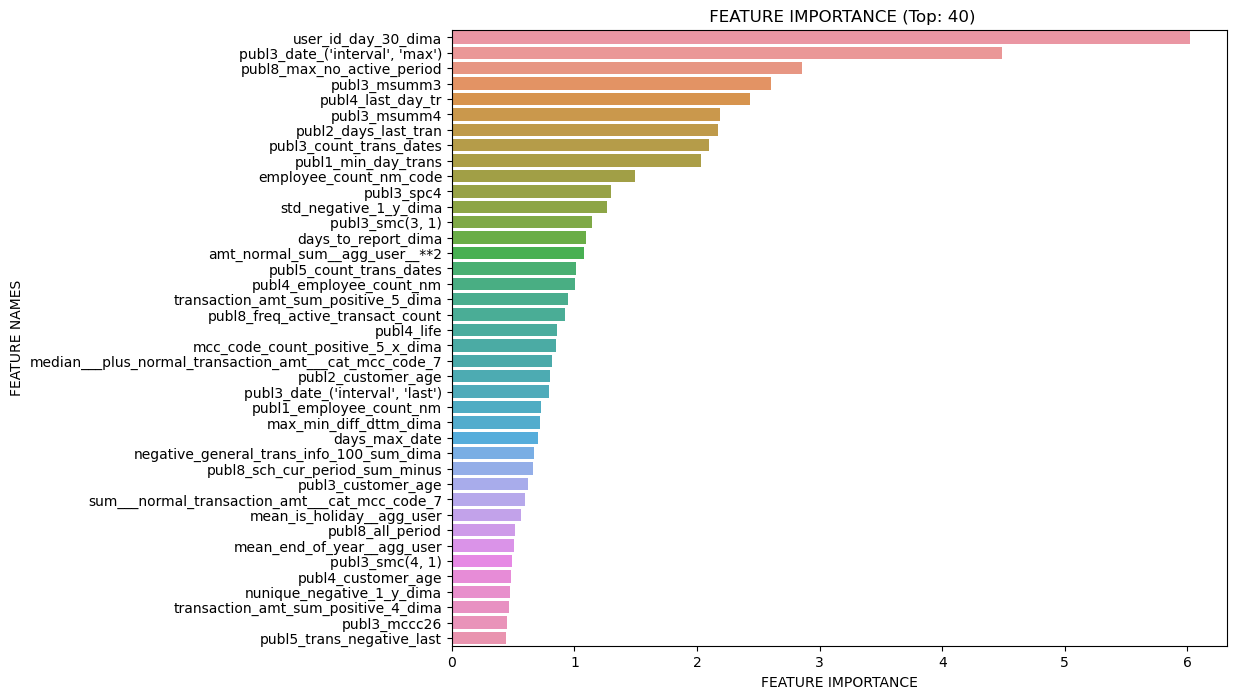

In [135]:
# Важность признаков
fi_df = plot_feature_importance(fold_model_reg.get_feature_importance(), fold_X_train.columns, model_name='', top_n=40)  

In [136]:
# %%time
# # Кроссвалидация для обучения модели-регресс предсказания таргета time
# from sklearn.model_selection import KFold, StratifiedKFold
# from sklearn.metrics import mean_absolute_error

# # kf = KFold(n_splits=5, random_state=53, shuffle=True)
# kf = StratifiedKFold(n_splits=5, random_state=53, shuffle=True)


# train_df['predict_time'] = np.nan
# qnt_columns = ['time_pred_001', 'time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']
# train_df[qnt_columns] = np.nan

# # for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, cv_y_train)):
# for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, train_df[bin_target_column])):
#     print(f'fold: {i+1}')
#     print(f'train_index: {len(train_index)}, test_index: {len(test_index)}')
#     fold_X_train = cv_X_train.iloc[train_index]
#     fold_y_train = cv_y_train.iloc[train_index]
#     fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(fold_X_train, fold_y_train, test_size = 0.05, random_state = 53)
    
#     fold_X_test = cv_X_train.iloc[test_index]
#     fold_y_test = cv_y_train.iloc[test_index]
    
#     # fold_model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=53, cat_features=cat_features)
#     fold_model_reg = CatBoostRegressor(eval_metric="MAE", early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
#     fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)

#     qnt_fold_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.05, 0.1, 0.3, 0.7',
#                                        early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
#     qnt_fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
#     # train_df[qnt_columns].iloc[test_index] = qnt_fold_model_reg.predict(fold_X_test)
#     train_df.loc[test_index, qnt_columns] = qnt_fold_model_reg.predict(fold_X_test)
    
#     predict_time = fold_model_reg.predict(fold_X_test)
#     train_df['predict_time'].iloc[test_index] = predict_time
#     fold_mae = mean_absolute_error(y_true=fold_y_test, y_pred=predict_time)
#     print(f'MAE fold #{i}: {fold_mae}')
    
# #     submit_predict_time = fold_model_reg.predict(X_submit[feature_columns])
# #     X_submit[f'predict_time_{i+1}'] = submit_predict_time    

# train_df[qnt_columns] = np.sort(train_df[qnt_columns].values)
# save_train_df = train_df.copy()


# # X_submit
# # save_X_submit = X_submit.copy()
# #     X_submit[sorted_qnt_columns] = qnt_fold_model_reg.predict(X_submit[feature_columns])
# #     X_submit[sorted_qnt_columns] = np.sort(X_submit[sorted_qnt_columns].values)
    


#### Заполняем time_predict для сабмита 

In [ ]:
%%time
model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=100, iterations=600, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
model_reg.fit(cv_X_train, cv_y_train, plot=False, verbose=False)

In [ ]:
X_submit['predict_time'] = model_reg.predict(X_submit[feature_columns])

In [ ]:
%%time
qnt_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.01, 0.05, 0.1, 0.3, 0.5, 0.7', 
                                       early_stopping_rounds=100, iterations=700, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
qnt_model_reg.fit(cv_X_train, cv_y_train, plot=False, verbose=False)

In [ ]:
# sorted_qnt_columns = ['time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']
# qnt_columns
X_submit[qnt_columns] = qnt_model_reg.predict(X_submit[feature_columns])
X_submit[qnt_columns] = np.sort(X_submit[qnt_columns].values)
X_submit

In [ ]:
assert False, 'Поменять долллар и евро, проверить'
assert False, 'Добавить/Убрать группы mcc'
assert False, 'Увеличить число pop_mcc'
assert False, 'Перевести мсс код в категориальные признаки, а не числовые'


In [ ]:
qnt_columns

In [ ]:
# train_df['time'].hist(bins=100)

In [ ]:
# train_df['predict_time'].hist(bins=100)

In [ ]:
# train_df[~train_df['predict_time'].isna()]

In [137]:
# model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

train_df.shape, save_train_df.shape

((64000, 1191), (64000, 1191))

In [ ]:
# save_train_df = train_df.copy()
# train_df = save_train_df.copy()
# src_train_df = save_train_df.copy()
# save_X_submit = X_submit.copy()
# save_X_submit_2 = X_submit.copy()
train_df.shape, save_train_df.shape, X_submit.shape, save_X_submit.shape

In [ ]:
# src_train_df = save_train_df.copy()
# train_df = save_train_df.copy()

In [ ]:
# tmp_train_df = train_df[feature_columns + ['target', 'predict_time']].copy()
# tmp_train_df = train_df.copy()
# train_df = tmp_train_df.copy()
# tmp_train_df.shape, train_df.shape
train_df.shape, save_train_df.shape

In [ ]:
X_submit.shape

In [ ]:
# Загружаем последние фичи
# src_train_df = pd.read_csv('features_X_train__v3.csv')
# submit_df = pd.read_csv('features_X_test__v3.csv')

# train_df = train_df.drop(columns=['user_id_day_30_dima'], errors='ignore')
# X_submit = X_submit.drop(columns=['user_id_day_30_dima'], errors='ignore')


# train_df[clf_feature_columns + [target_column]].to_csv('features_X_train__v3_3.csv', index=False)
# X_submit[clf_feature_columns].to_csv('features_X_test__v3_3.csv', index=False)

# src_train_df.shape, submit_df.shape

# Модель Классификации

### Submit

In [177]:
clf_feature_columns = list(set(feature_columns + ['predict_time'] + qnt_columns) - set(['user_id_day_30_dima']))
len(clf_feature_columns)

1176

In [178]:
target_column = 'target'
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 
# clf_feature_columns = list(feature_columns)
# list(set(feature_columns + ['predict_time'] + qnt_columns) - set(['user_id_day_30_dima']))
# train_df = src_train_df
#X_submit = submit_df
# len(clf_feature_columns)

In [95]:
# train_df[clf_feature_columns + [target_column]].shape, X_submit.shape
# features_X_train__v2

In [189]:
# res_X_train = save_train_df.copy()
target_column = 'target'
res_X_train, res_y_train = train_df[clf_feature_columns], train_df[target_column]

res_X_test_submit = X_submit[clf_feature_columns]

res_X_train.shape, res_y_train.shape, res_X_test_submit.shape

((64000, 1176), (64000,), (32000, 1176))

In [205]:
# [col for col in train_df.columns if 'publ8_' in col]
new_features = [ 'user_id',
 'publ8_active_period',
 'publ8_unique_active_days',
 'publ8_all_period',
 'publ8_median_no_active_period',
 'publ8_max_no_active_period',
 'publ8_prc_no_active_period',
 'publ8_prc_no_active_period_by_days',
 'publ8_freq_active_transact_count',
 'publ8_freq_active_day',
 'publ8_count_account_hit',
 'publ8_count_account_charge',
 'publ8_sch_plus_speed_cur',
 'publ8_sch_plus_speed_pre',
 'publ8_sch_plus_speed_cur_prepre',
 'publ8_sch_minus_speed_cur',
 'publ8_sch_minus_speed_pre',
 'publ8_sch_minus_speed_cur_prepre',
 'publ8_sch_cur_period_sum_plus',
 'publ8_sch_pre_period_sum_plus',
 'publ8_sch_pre_pre_period_sum_plus',
 'publ8_sch_cur_period_sum_minus',
 'publ8_sch_pre_period_sum_minus',
 'publ8_sch_pre_pre_period_sum_minus']

In [206]:
train_df[new_features].to_csv('new_features_X_train__v5_1.csv', index=False)
X_submit[new_features].to_csv('new_features_X_test__v5_1.csv', index=False)


In [190]:
# # Сохраняем итоговый набор фичей
train_df[clf_feature_columns + [target_column]].to_csv('features_X_train__v5.csv', index=False)
X_submit[clf_feature_columns].to_csv('features_X_test__v5.csv', index=False)
# save_train_df.shape, X_submit.shape

train_df[clf_feature_columns + [target_column]].shape, X_submit[clf_feature_columns].shape

((64000, 1177), (32000, 1176))

In [191]:
embedding_features = ['embedding']
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 

In [199]:
%%time
# # model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=2500, random_state=53, cat_features=cat_features, learning_rate=0.01, ignored_features=['user_id'])
# submit_model_clf = CatBoostClassifier(early_stopping_rounds=50, iterations=100, random_state=53, cat_features=cat_features, learning_rate=0.01)
# submit_model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=100, random_state=53, cat_features=cat_features, learning_rate=0.01)
submit_model_clf = CatBoostClassifier(
                eval_metric="AUC", 
                early_stopping_rounds=300, 
                # iterations=3000, # 9
                # iterations=8000, # 9_2
                iterations=12000, # 9_3
                random_state=53, 
                cat_features=cat_features, 
#                 embedding_features=embedding_features,
                learning_rate=0.01)
submit_model_clf.fit(res_X_train, res_y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 2h 44min 18s
Wall time: 24min 28s


In [200]:
res_X_test_submit['predict'] = submit_model_clf.predict_proba(res_X_test_submit)[:,1]
res_X_test_submit[['user_id', 'predict']].to_csv('submit_v9_3.csv', index=False)
res_X_test_submit.shape

C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\2883820807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_X_test_submit['predict'] = submit_model_clf.predict_proba(res_X_test_submit)[:,1]


(32000, 1177)

## Локальные тесты

In [214]:
# tmp_df_df = pd.read_csv('features_X_test__v3.csv')
# tmp_df_df.shape
# df = tmp_df_df
# df =  df.drop(columns=[col for col in df.columns if 'publ3_' in col], errors='ignore')
# df.shape
# publ4

(32000, 555)

In [140]:
first_src_train_df = src_train_df.copy()
first_submit_df = submit_df.copy()

In [295]:
%%time
# Загружаем последние фичи
src_train_df = pd.read_csv('features_X_train__v3.csv')
submit_df = pd.read_csv('features_X_test__v3.csv')

src_train_df = src_train_df.drop(columns=['user_id_day_30_dima'], errors='ignore')
submit_df = submit_df.drop(columns=['user_id_day_30_dima'], errors='ignore')

src_train_df.shape, submit_df.shape

CPU times: total: 15.7 s
Wall time: 16.7 s


((64000, 1154), (32000, 1153))

In [296]:
len(list(src_train_df.columns))

1154

In [297]:
# Загружаем доп признаки
publ8_train_df = pd.read_csv('new_features_X_train__v5_1.csv')
publ8_test_df = pd.read_csv('new_features_X_test__v5_1.csv')
publ8_train_df.shape, publ8_test_df.shape

((64000, 24), (32000, 24))

In [298]:
src_train_df = src_train_df.merge(publ8_train_df, on='user_id')
submit_df = submit_df.merge(publ8_test_df, on='user_id')

src_train_df.shape, submit_df.shape

((64000, 1177), (32000, 1176))

In [299]:
# # Загружаем эмбеддинги
# publ6_df = pd.read_csv('public_notebooks/publ6_part2_1_ptls2.csv')
# emb_columns = sorted(list(set(publ6_df.columns) - set(['user_id'])))
# publ6_df['embedding'] = publ6_df[emb_columns].apply(lambda x: list(x.values), axis=1)
# publ6_df.shape

In [300]:
# src_train_df = src_train_df.merge(publ6_df[['embedding', 'user_id']], on='user_id')
# submit_df = submit_df.merge(publ6_df[['embedding', 'user_id']], on='user_id')

# src_train_df.shape, submit_df.shape

In [301]:
users_group_df = pd.concat([src_train_df[['user_id']], submit_df[['user_id']]])
# users_group_df.shape
users_group_df['user_group'] = pd.qcut(users_group_df['user_id'], 10,  labels=False)

src_train_df = src_train_df.merge(users_group_df, on='user_id')
submit_df = submit_df.merge(users_group_df, on='user_id')

src_train_df.shape, submit_df.shape

((64000, 1178), (32000, 1177))

In [303]:
# save_src_train_df = src_train_df.copy()
# src_train_df = save_src_train_df.copy()
save_src_train_df.shape, src_train_df.shape 

((64000, 1178), (64000, 1178))

In [149]:
# # column_split = 'publ8_count_account_charge'

# learn_group_users_df = pd.concat([src_train_df[[column_split, 'user_id']], submit_df[[column_split, 'user_id']]])
# learn_group_users_df['learn_group_users'] = pd.qcut(learn_group_users_df[column_split], 2,  labels=False)

# src_train_df = src_train_df.merge(learn_group_users_df[['learn_group_users', 'user_id']], on='user_id')
# submit_df = submit_df.merge(learn_group_users_df[['learn_group_users', 'user_id']], on='user_id')

# src_train_df.shape, submit_df.shape

In [456]:
len(src_train_df['learn_group_users'].unique())

2

0
9.31 90.69
2
6.85 93.15
1
9.23 90.77


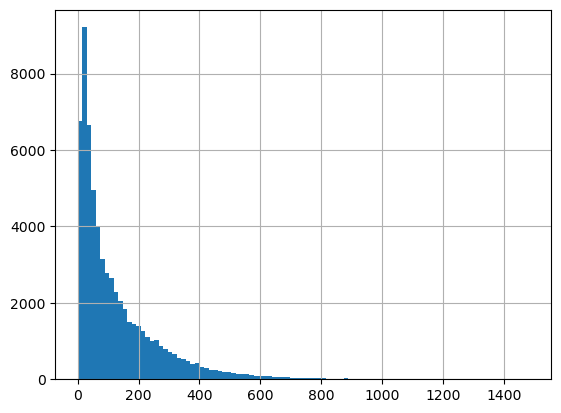

In [448]:

# # publ8_cols = [col for col in src_train_df.columns if 'publ8_' in col]
# # publ8_cols
# # column_split = 'publ8_freq_active_transact_count'
# column_split = 'publ8_count_account_charge'
# src_train_df[column_split].hist(bins=100)
# src_train_df['learn_group_users'] = pd.qcut(src_train_df[column_split], 3,  labels=False)

# for group_n in src_train_df['learn_group_users'].unique():
#     print(group_n)
#     zero_cnt, one_cnt = src_train_df[src_train_df['learn_group_users'] == group_n]['target'].value_counts().values
#     # zero_cnt, one_cnt = src_train_df['target'].value_counts().values
#     sum_cnt = (zero_cnt + one_cnt)
#     print(round(one_cnt / sum_cnt * 100, 2), round(zero_cnt / sum_cnt * 100, 2))


In [304]:
train_df, val_df = train_test_split(src_train_df, test_size = 0.2, random_state = 53, stratify=src_train_df['target'])
test_df, val_df = train_test_split(val_df, test_size = 0.5, random_state = 53, stratify=val_df['target'])

train_df.shape, val_df.shape, test_df.shape

((51200, 1178), (6400, 1178), (6400, 1178))

In [305]:
target_column = 'target'
embedding_features = ['embedding']
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 
# feature_columns = set(src_train_df.columns) - set([target_column]) - set(['user_group']) # - set(['user_id']) 
feature_columns = set(src_train_df.columns) - set([target_column]) - set(['user_id']) # - set(['user_group'])
feature_columns = list(feature_columns)
num_features = list(set(feature_columns) - set(cat_features))

len(feature_columns), len(cat_features)

(1176, 3)

In [307]:
# 'user_group' in feature_columns

In [219]:
# 'user_group' in feature_columns
# 'user_group' in (feature_columns - set(['user_group']))

In [308]:
X_train = train_df[num_features]
y_train = train_df[target_column]

X_val = val_df[num_features]
y_val = val_df[target_column]

X_test = test_df[num_features]
y_test = test_df[target_column]

# X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

X_train.shape, X_val.shape, X_test.shape 

((51200, 1173), (6400, 1173), (6400, 1173))

In [252]:
# num_features
# num_features

In [309]:
%%time
from xgboost import XGBClassifier

best_xgb_params_2 = {'n_estimators': 674, 
                     'learning_rate': 0.012910299327648115, 
                     'gamma': 0.16068663546457748, 
                     'subsample': 0.9956389496499721, 
                     'colsample_bytree': 0.20729079756990323, 
                     'max_depth': 6, 
                     'min_child_weight': 5, 
                     'reg_lambda': 0.03730242452791283, 
                     'reg_alpha': 1.6204566652146795e-07}

best_xgb_params_2['booster'] = 'gbtree'
best_xgb_params_2['grow_policy'] = 'depthwise'
best_xgb_params_2['objective'] = 'binary:logistic'  # Change to binary:logistic for binary classification
best_xgb_params_2["tree_method"] = "hist"
best_xgb_params_2["device"] = "cuda"
best_xgb_params_2["verbosity"] = 0

# xgb_model = XGBClassifier(random_state=42, tree_method="gpu_hist", enable_categorical=True, max_cat_to_onehot=1)
xgb_model = XGBClassifier(**best_xgb_params_2, random_state=42)
xgb_model.fit(X_train[num_features], y_train)

CPU times: total: 34.6 s
Wall time: 18.5 s


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.20729079756990323, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.16068663546457748,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, learning_rate=0.012910299327648115,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=674, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [237]:
# sorted_idx = xgb_model.feature_importances_.argsort()
# plt.barh(X_train[num_features].columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
# plt.xlabel("Xgboost Feature Importance")
X_train[num_features].columns[sorted_idx]

Index(['publ3_mcc280', 'plus_amt_normal_var__agg_user', 'publ3_mcc340',
       'positive_general_trans_info_500_median_dima', 'publ3_mccc214',
       'publ3_mccc172', 'publ3_mcc184', 'publ3_msum(9, 2)',
       'general_trans_info_1500_count_dima', 'publ3_mcc232'],
      dtype='object')

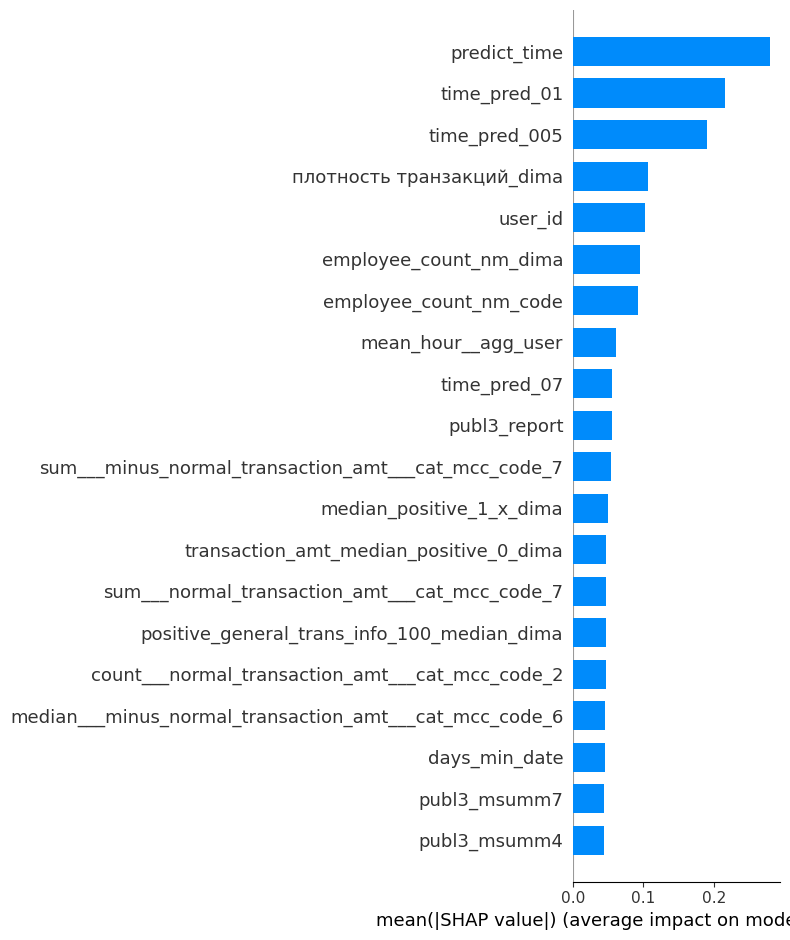

In [241]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test[num_features])
shap.summary_plot(shap_values, X_test, plot_type="bar")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

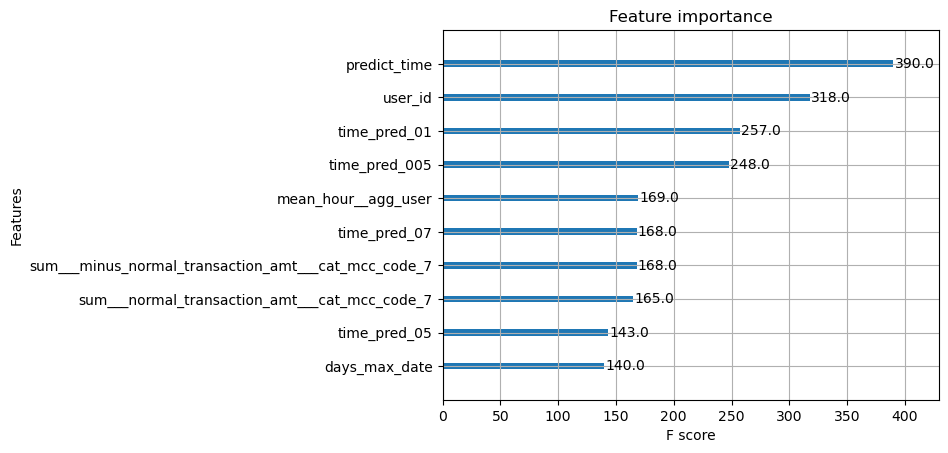

In [255]:
from xgboost import XGBClassifier, plot_importance
plot_importance(xgb_model, max_num_features=10)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

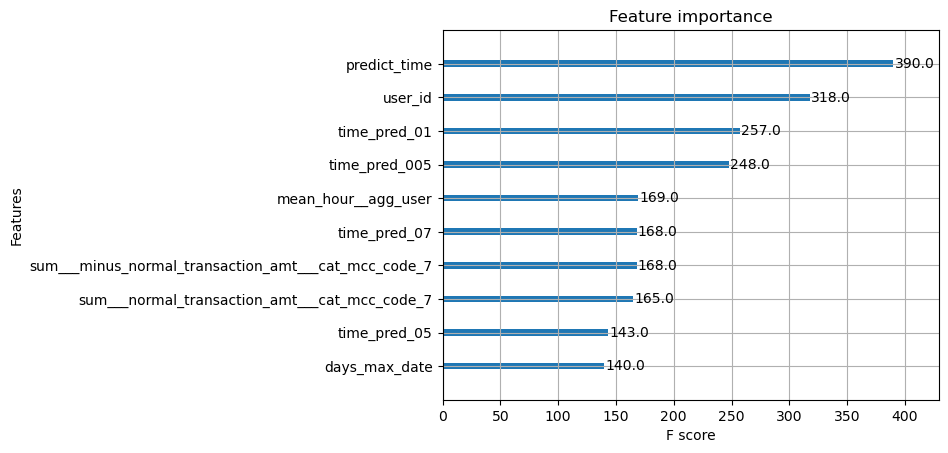

In [277]:
from xgboost import XGBClassifier, plot_importance
plot_importance(xgb_model, max_num_features=10)

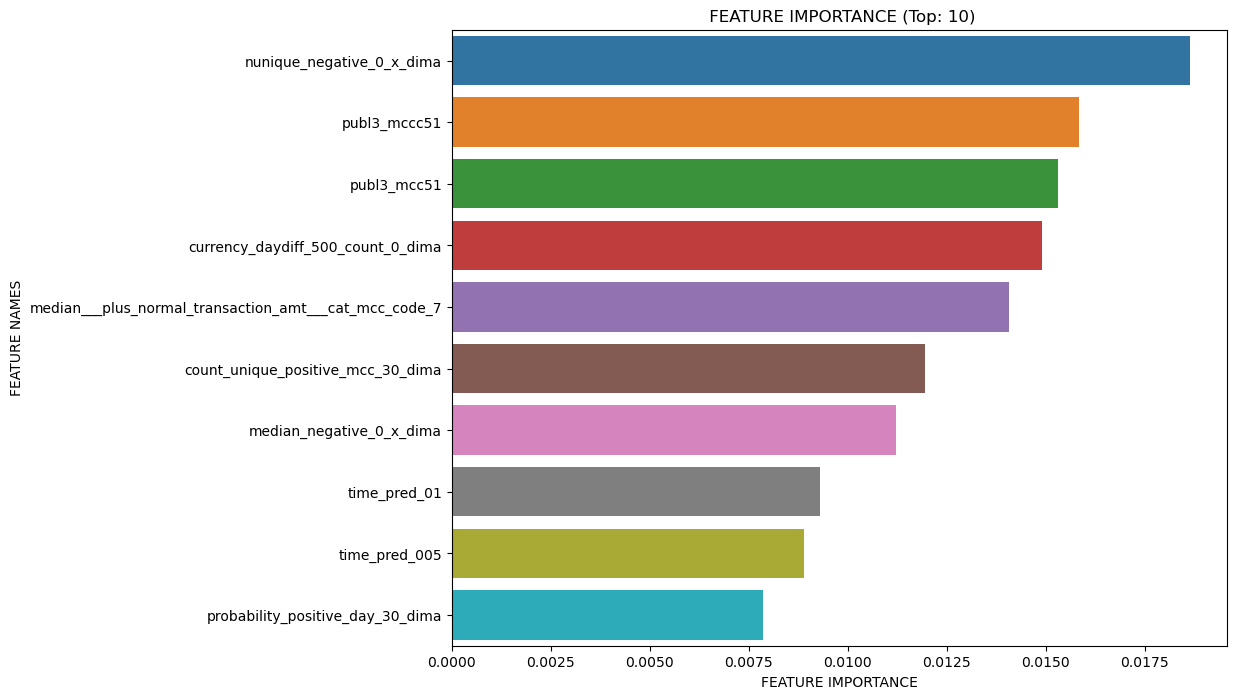

In [254]:
xgb_model.feature_importances_
# Важность признаков
fi_df = plot_feature_importance(xgb_model.feature_importances_, X_train[num_features].columns, model_name='', top_n=10)  

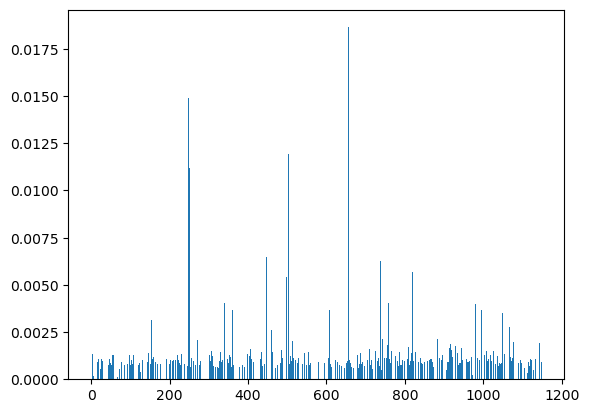

In [256]:
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()

In [259]:
X_train[num_features].columns

Index(['sum_0_amt_30_dima', 'currency_daydiff_1000_count_3_norm_dima',
       'delta_first_last_date', 'publ3_mccc3', 'publ3_smc(4, 0)',
       'publ3_mcc30', '0_positivecurrency_rk_dima', 'publ3_mccc37',
       'publ3_mcc19', 'sum___normal_transaction_amt___cat_mcc_code_7',
       ...
       'publ3_mcc183', 'publ3_mccc72', 'currency_daydiff_500_sum_0_dima',
       'плотность дней_dima', 'publ3_mcc210',
       'transaction_amt_count_negative_4_dima', 'publ3_mccc328',
       'publ3_mcc101', 'publ3_spc8', 'publ3_mcc280'],
      dtype='object', length=1150)

In [278]:
# np.argmax(xgb_model.feature_importances_)
# num_features[657]
# xgb_model.booster().get_score(importance_type='weight')
# xgb_model.get_score(importance_type='weight')
df_tmp = pd.DataFrame.from_dict(xgb_model.get_booster().get_score(importance_type= 'weight'), orient='index')
df_tmp.reset_index().sort_values(by=0)

# feature_importance = xgb_model.feature_importances_
# sorted_idx = np.argsort(feature_importance)[:10]
# fig = plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
# plt.title('Feature Importance')


index      0
484        publ3_mccc129    1.0
32           publ3_mcc74    1.0
564         publ3_mccc58    1.0
334         publ3_mccc50    1.0
573         publ3_mccc46    1.0
..                   ...    ...
653  mean_hour__agg_user  169.0
401        time_pred_005  248.0
435         time_pred_01  257.0
660              user_id  318.0
712         predict_time  390.0

[770 rows x 2 columns]

In [265]:
# xgb_model.feature_importances_
# Важность признаков
# fi_df = plot_feature_importance(xgb_model.feature_importances_, X_train[num_features].columns, model_name='', top_n=10)  

In [317]:
xgb_fi_df[:20].sort_values(by=0, ascending=False).replace({'publ2_employee_count_enc': 'employee_cnt_p2', 
                                                              'publ3_mccc3':'aggr_fc_mcc',
                                                              'publ8_freq_active_transact_count': 'freq_active_transact_count_p8',
                                                              'time_pred_01':'time_pred_low_01',
                                                              'time_pred_03':'time_pred_low_03',
                                                              'time_pred_07':'time_pred_high_07',
                                                              'publ4_employee_count_nm': 'employee_cnt_norm_p4',
                                                              'sum___minus_normal_transaction_amt___cat_mcc_code_7': 'sum_minus_normal_amt_cat_mcc_7',
                                                              'sum___normal_transaction_amt___cat_mcc_code_7': 'sum_normal_amt_cat_mcc_7',
                                                              'median___minus_normal_transaction_amt___cat_mcc_code_7': 'median_minus_normal_amt_cat_mcc_7',
                                                              'skew_weekday__agg_user': 'std_weekday__agg_user',
                                                              'publ4_std_abs_sum_tr': 'std_sum_tranc_p4',
                                                              'publ8_sch_pre_period_sum_minus': 'rate_of_change_sum_minus_p8',                                                              
                                                              'sum___normal_transaction_amt___cat_mcc_code_7': 'sum_amt_cat_mcc_code_7',
                                                              'publ3_mccc3' : 'mccc3'
                                                              
                                                             })

index      0
7                       sum_amt_cat_mcc_code_7  155.0
2                                        mccc3  114.0
1                        delta_first_last_date   84.0
8           mcc_code_nunique_positive_1_x_dima   54.0
10                       nunique_positive_dima   39.0
18   positive_general_trans_info_1000_sum_dima   29.0
13              minus_amt_normal_max__agg_user   25.0
11  negative_general_trans_info_500_count_dima   23.0
19         transaction_amt_sum_negative_0_dima   21.0
9                              publ3_smc(8, 0)   14.0
3                                  publ3_mcc30   12.0
15                            publ3_msum(8, 0)   11.0
16         publ5_employee_count_nm_ОТ 11 ДО 50   10.0
14     transaction_amt_nunique_negative_5_dima    8.0
5                                 publ3_mccc37    6.0
12                                publ3_mcc100    3.0
6                                  publ3_mcc19    2.0
4                   0_positivecurrency_rk_dima    2.0
17                        publ1_bankemplstatus    2.0
0                            sum_0_amt_30_dima    2.0

In [321]:
xgb_fi_df

index      0
0                        sum_0_amt_30_dima    2.0
1                    delta_first_last_date   84.0
2                              aggr_fc_mcc  114.0
3                              publ3_mcc30   12.0
4               0_positivecurrency_rk_dima    2.0
..                                     ...    ...
805        currency_daydiff_500_sum_0_dima   20.0
806                    плотность дней_dima   57.0
807  transaction_amt_count_negative_4_dima    4.0
808                             publ3_spc8   38.0
809                       publ8_all_period   46.0

[810 rows x 2 columns]

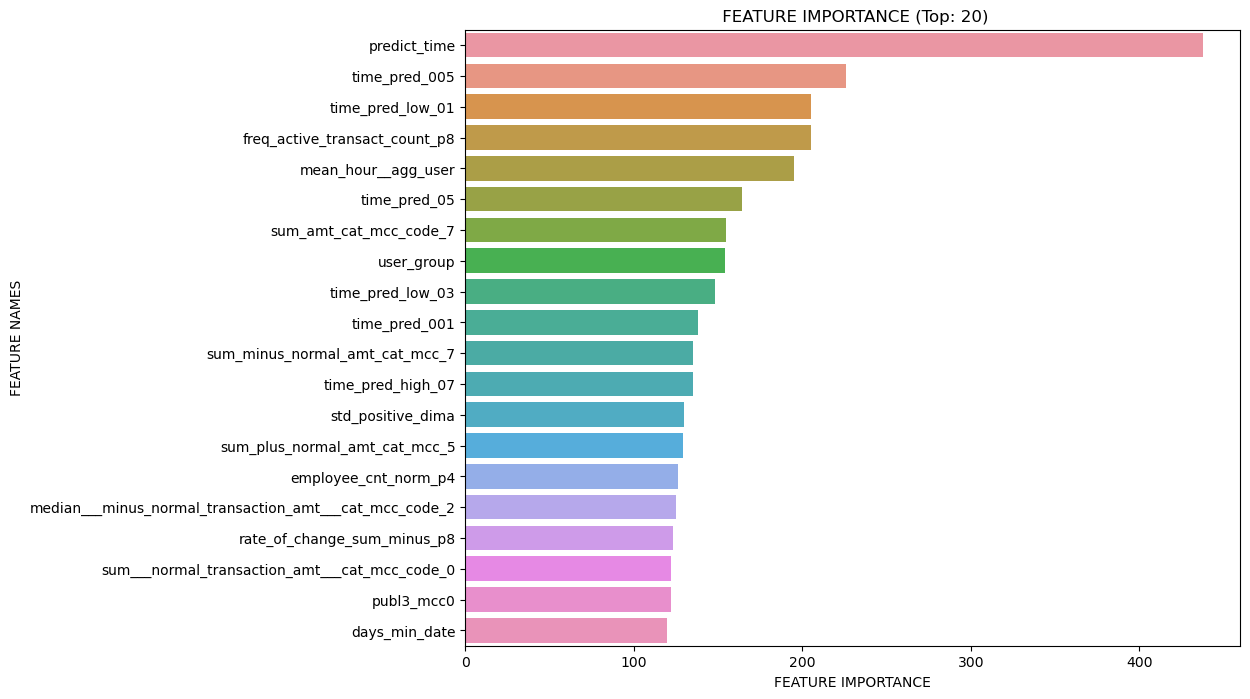

In [320]:
xgb_model.feature_importances_
# Важность признаков
# fi_df = plot_feature_importance(xgb_model.feature_importances_, X_train[num_features].columns, model_name='', top_n=20)  
xgb_fi_df = pd.DataFrame.from_dict(xgb_model.get_booster().get_score(importance_type= 'weight'), orient='index').reset_index()

xgb_fi_df = xgb_fi_df.replace({'publ2_employee_count_enc': 'employee_cnt_p2', 
                                                              'publ3_mccc3':'aggr_fc_mcc',
                                                              'publ8_freq_active_transact_count': 'freq_active_transact_count_p8',
                                                              'time_pred_01':'time_pred_low_01',
                                                              'time_pred_03':'time_pred_low_03',
                                                              'time_pred_07':'time_pred_high_07',
                                                              'publ4_employee_count_nm': 'employee_cnt_norm_p4',
                                                              'sum___minus_normal_transaction_amt___cat_mcc_code_7': 'sum_minus_normal_amt_cat_mcc_7',
                                                              'sum___plus_normal_transaction_amt___cat_mcc_code_5': 'sum_plus_normal_amt_cat_mcc_5',
                                                              'sum___normal_transaction_amt___cat_mcc_code_7': 'sum_normal_amt_cat_mcc_7',
                                                              'median___minus_normal_transaction_amt___cat_mcc_code_7': 'median_minus_normal_amt_cat_mcc_7',
                                                              'skew_weekday__agg_user': 'std_weekday__agg_user',
                                                              'publ4_std_abs_sum_tr': 'std_sum_tranc_p4',
                                                              'publ8_sch_pre_period_sum_minus': 'rate_of_change_sum_minus_p8',                                                              
                                                              'sum___normal_transaction_amt___cat_mcc_code_7': 'sum_amt_cat_mcc_code_7'
                                                              
                                                             })

fi_df = plot_feature_importance(xgb_fi_df[0], xgb_fi_df['index'], model_name='', top_n=20)  


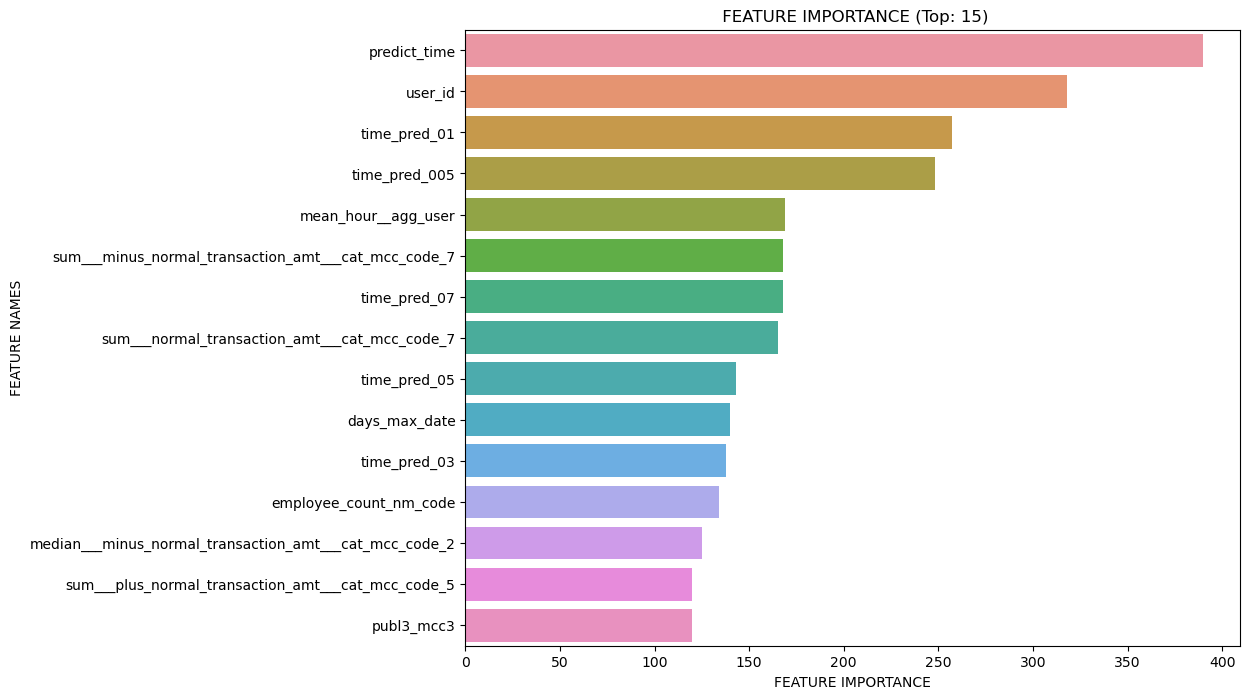

In [287]:
xgb_model.feature_importances_
# Важность признаков
# fi_df = plot_feature_importance(xgb_model.feature_importances_, X_train[num_features].columns, model_name='', top_n=20)  
xgb_fi_df = pd.DataFrame.from_dict(xgb_model.get_booster().get_score(importance_type= 'weight'), orient='index').reset_index()

xgb_fi_df = xgb_fi_df.rename({'publ2_employee_count_enc': 'employee_cnt_p2', 
                                                              'publ3_mccc3':'aggr_fc_mcc',
                                                              'publ8_freq_active_transact_count': 'freq_active_transact_count_p8',
                                                              'time_pred_01':'time_pred_low_01',
                                                              'time_pred_03':'time_pred_low_03',
                                                              'time_pred_07':'time_pred_high_07',
                                                              'publ4_employee_count_nm': 'employee_cnt_norm_p4',
                                                              'sum___minus_normal_transaction_amt___cat_mcc_code_7': 'sum_minus_normal_amt_cat_mcc_7',
                                                              'median___minus_normal_transaction_amt___cat_mcc_code_7': 'median_minus_normal_amt_cat_mcc_7',
                                                              'skew_weekday__agg_user': 'std_weekday__agg_user',
                                                              'publ4_std_abs_sum_tr': 'std_sum_tranc_p4',
                                                              'publ8_sch_pre_period_sum_minus': 'rate_of_change_sum_minus_p8',                                                              
                                                              'sum___normal_transaction_amt___cat_mcc_code_7': 'sum_amt_cat_mcc_code_7'
                                                              
                                                             })

fi_df = plot_feature_importance(xgb_fi_df[0], xgb_fi_df['index'], model_name='', top_n=15)  


In [311]:
xgb_fi_df[:20]

index      0
0                               sum_0_amt_30_dima    2.0
1                           delta_first_last_date   84.0
2                                     publ3_mccc3  114.0
3                                     publ3_mcc30   12.0
4                      0_positivecurrency_rk_dima    2.0
5                                    publ3_mccc37    6.0
6                                     publ3_mcc19    2.0
7   sum___normal_transaction_amt___cat_mcc_code_7  155.0
8              mcc_code_nunique_positive_1_x_dima   54.0
9                                 publ3_smc(8, 0)   14.0
10                          nunique_positive_dima   39.0
11     negative_general_trans_info_500_count_dima   23.0
12                                   publ3_mcc100    3.0
13                 minus_amt_normal_max__agg_user   25.0
14        transaction_amt_nunique_negative_5_dima    8.0
15                               publ3_msum(8, 0)   11.0
16            publ5_employee_count_nm_ОТ 11 ДО 50   10.0
17                           publ1_bankemplstatus    2.0
18      positive_general_trans_info_1000_sum_dima   29.0
19            transaction_amt_sum_negative_0_dima   21.0

In [205]:
# 0.7707206853351984 0.76500927 0.1699869787 0.2458598
model_clf_v3 = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=8000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
#                                embedding_features=embedding_features,
                               learning_rate=0.04,
                               # class_weights = class_weights
                              )

# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf_v3.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

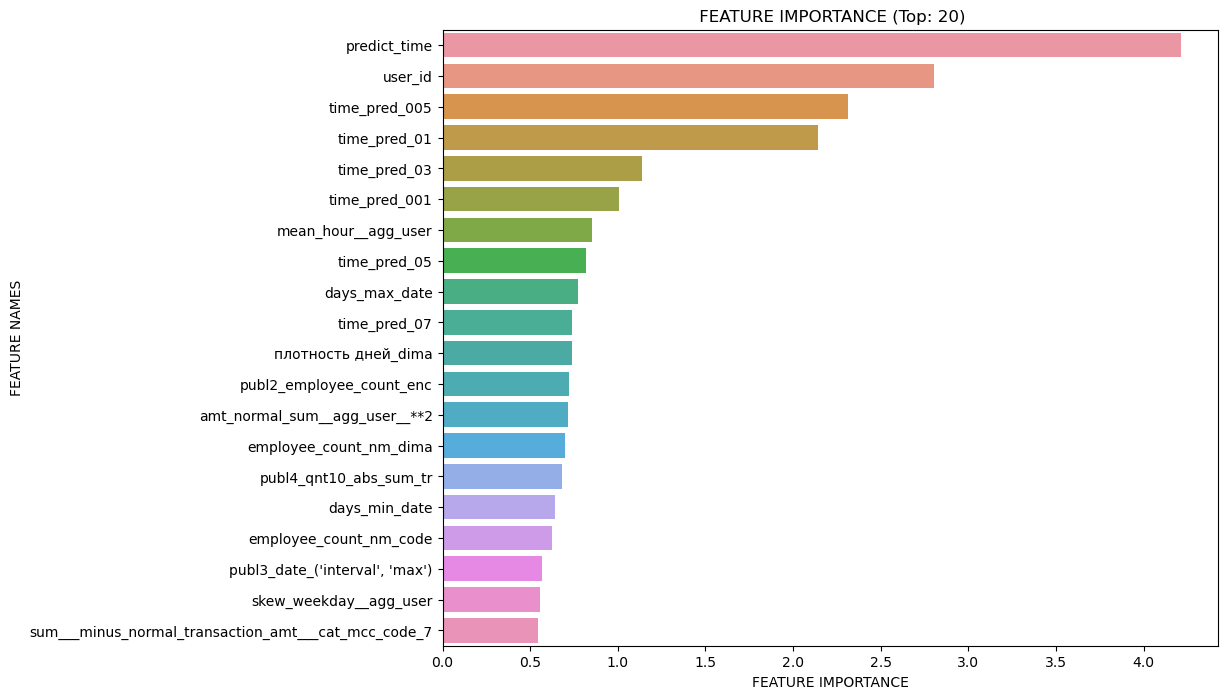

In [206]:
# Важность признаков
fi_df = plot_feature_importance(model_clf_v3.get_feature_importance(), X_train.columns, model_name='', top_n=20)  

In [197]:
# 0.7707206853351984 0.76500927 0.1699869787 0.2458598
model_clf2 = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=8000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
#                                embedding_features=embedding_features,
                               learning_rate=0.04,
                               # class_weights = class_weights
                              )

# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf2.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

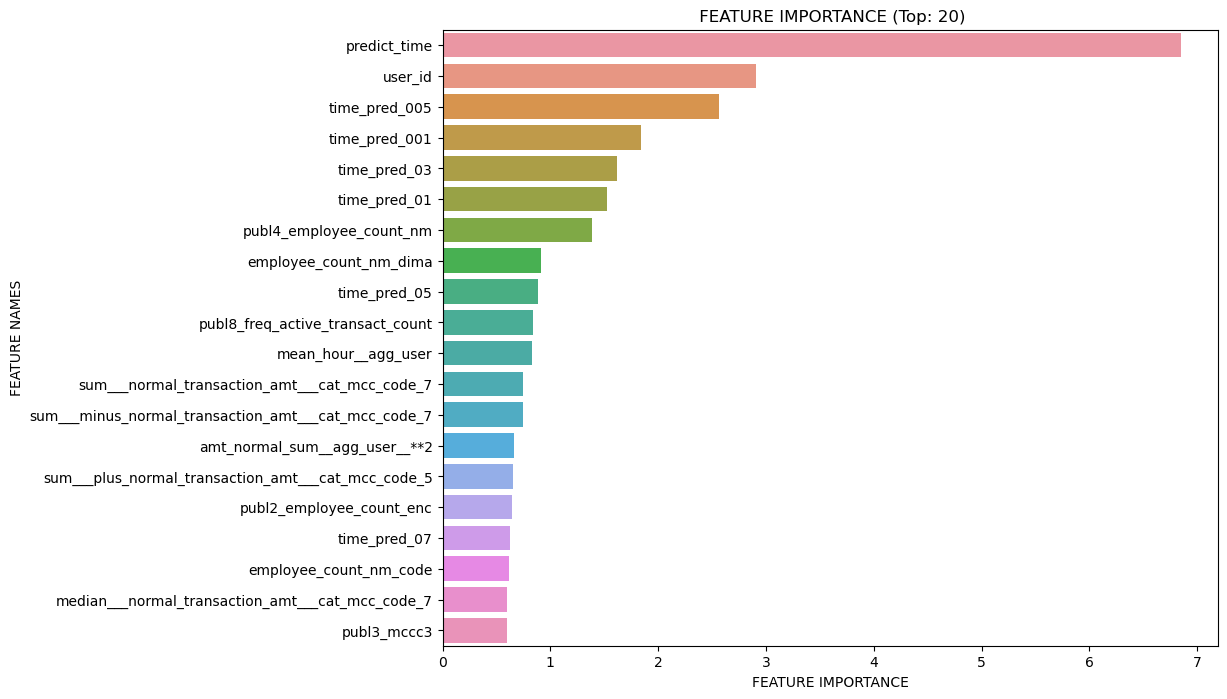

In [199]:
# Важность признаков
fi_df = plot_feature_importance(model_clf2.get_feature_importance(), X_train.columns, model_name='', top_n=20)  

In [153]:
# 0.7707206853351984 0.76500927 0.1699869787 0.2458598
model_clf = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=8000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
#                                embedding_features=embedding_features,
                               learning_rate=0.04,
                               # class_weights = class_weights
                              )

# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

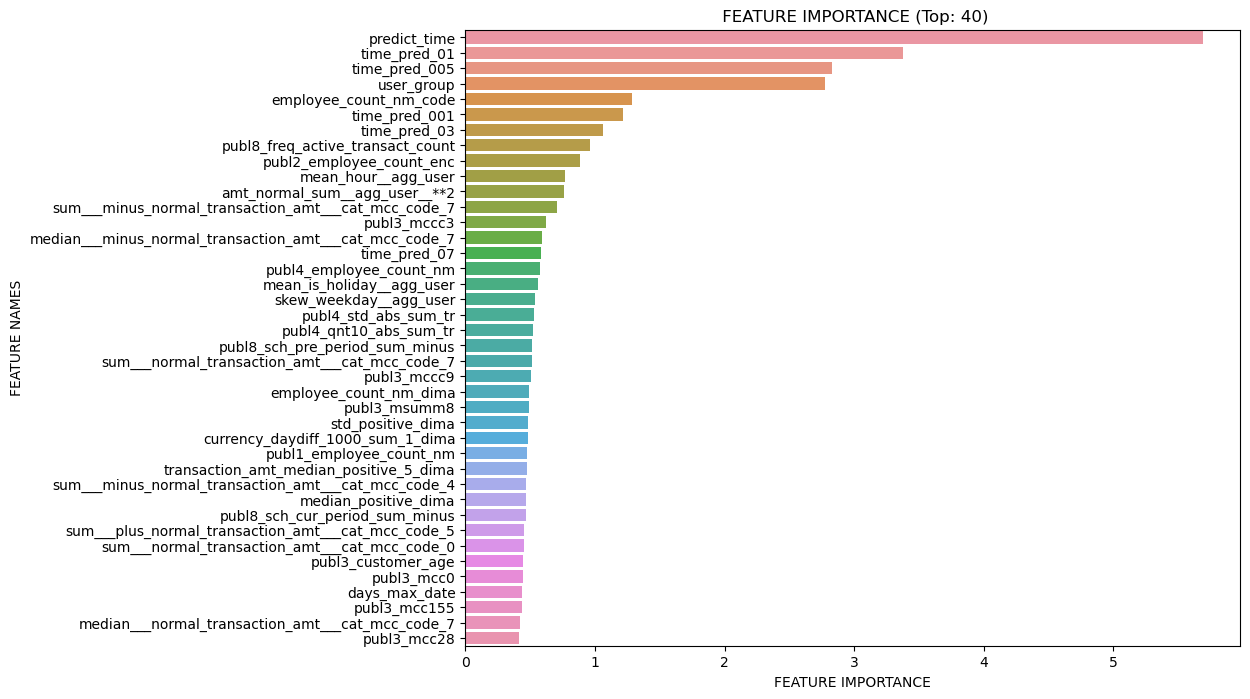

In [154]:
# Важность признаков
fi_df = plot_feature_importance(model_clf.get_feature_importance(), X_train.columns, model_name='', top_n=40)  

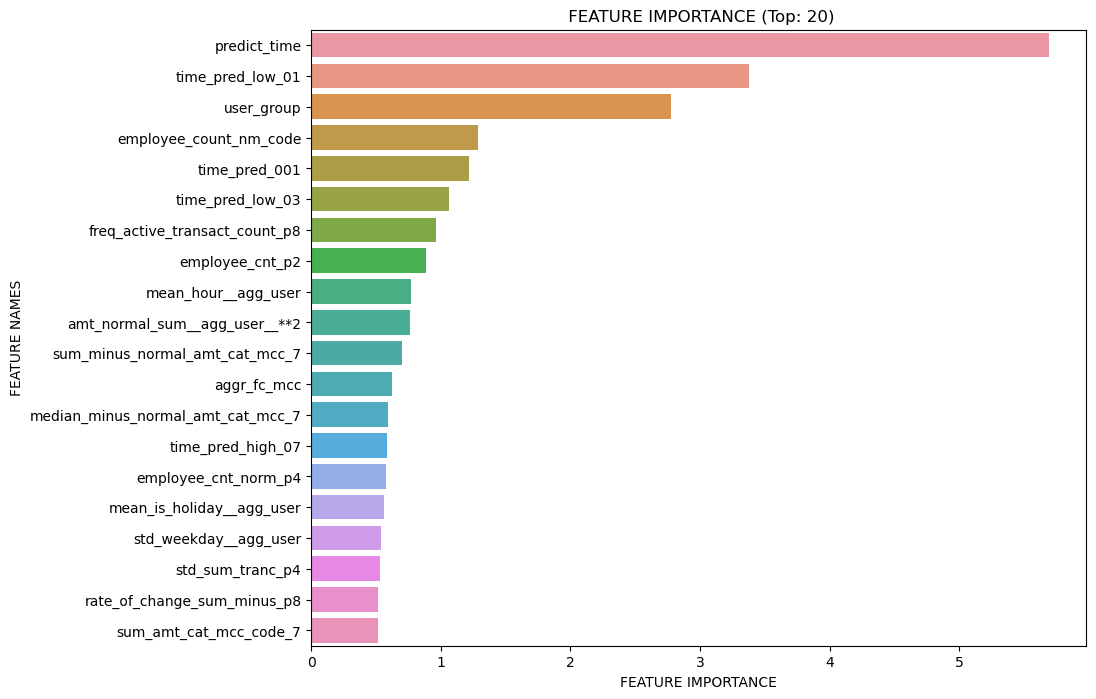

In [188]:
rename_column_X_train = X_train.copy()
rename_column_X_train = rename_column_X_train.rename(columns={'publ2_employee_count_enc': 'employee_cnt_p2', 
                                                              'publ3_mccc3':'aggr_fc_mcc',
                                                              'publ8_freq_active_transact_count': 'freq_active_transact_count_p8',
                                                              'time_pred_01':'time_pred_low_01',
                                                              'time_pred_03':'time_pred_low_03',
                                                              'time_pred_07':'time_pred_high_07',
                                                              'publ4_employee_count_nm': 'employee_cnt_norm_p4',
                                                              'sum___minus_normal_transaction_amt___cat_mcc_code_7': 'sum_minus_normal_amt_cat_mcc_7',
                                                              'median___minus_normal_transaction_amt___cat_mcc_code_7': 'median_minus_normal_amt_cat_mcc_7',
                                                              'skew_weekday__agg_user': 'std_weekday__agg_user',
                                                              'publ4_std_abs_sum_tr': 'std_sum_tranc_p4',
                                                              'publ8_sch_pre_period_sum_minus': 'rate_of_change_sum_minus_p8',                                                              
                                                              'sum___normal_transaction_amt___cat_mcc_code_7': 'sum_amt_cat_mcc_code_7'
                                                              
                                                             })
fi_df = plot_feature_importance(model_clf.get_feature_importance(), rename_column_X_train.columns, model_name='', top_n=20, skip_columns=['time_pred_005', 'publ4_qnt10_abs_sum_tr'])  

# import pickle
# # # Сохраняем признаки
# with open('2024_04_11_plot_feature_importance_model.pkl', 'wb') as file:
#     pickle.dump(model_clf, file)  
# with open('2024_04_11_plot_feature_importance_X_train.pkl', 'wb') as file:
#     pickle.dump(X_train, file)

In [167]:
tmpddd_X_train = list(X_train.columns.copy())
tmpddd_X_train = tmpddd_X_train.remove('time_pred_005')
len(tmpddd_X_train), X_train.columns.shape
# fi_df = plot_feature_importance(model_clf.get_feature_importance(), tmpddd_X_train, model_name='', top_n=20)  
# 'time_pred_005' in tmpddd_X_train

TypeError: object of type 'NoneType' has no len()

In [169]:
fi_df[:100]

feature_names  feature_importance
1074                                       predict_time            5.694487
679                                        time_pred_01            3.379745
170                                          user_group            2.775163
370                              employee_count_nm_code            1.283677
951                                       time_pred_001            1.217666
757                                        time_pred_03            1.063777
41                     publ8_freq_active_transact_count            0.961028
458                            publ2_employee_count_enc            0.887039
991                                 mean_hour__agg_user            0.770057
523                       amt_normal_sum__agg_user__**2            0.758905
419   sum___minus_normal_transaction_amt___cat_mcc_c...            0.703885
3                                           publ3_mccc3            0.625214
56    median___minus_normal_transaction_amt___cat_mc...            0.591679
784                                        time_pred_07            0.586666
400                             publ4_employee_count_nm            0.578209
1102                          mean_is_holiday__agg_user            0.562504
1158                             skew_weekday__agg_user            0.537978
941                                publ4_std_abs_sum_tr            0.530729
678                              publ4_qnt10_abs_sum_tr            0.520270
365                      publ8_sch_pre_period_sum_minus            0.515332
9         sum___normal_transaction_amt___cat_mcc_code_7            0.511944
1059                                        publ3_mccc9            0.508350
273                              employee_count_nm_dima            0.492151
637                                        publ3_msumm8            0.488419
905                                   std_positive_dima            0.486972
1000                   currency_daydiff_1000_sum_1_dima            0.482796
484                             publ1_employee_count_nm            0.475571
542              transaction_amt_median_positive_5_dima            0.473277
1068  sum___minus_normal_transaction_amt___cat_mcc_c...            0.470863
921                                median_positive_dima            0.469818
1089                     publ8_sch_cur_period_sum_minus            0.466952
916   sum___plus_normal_transaction_amt___cat_mcc_co...            0.450726
676       sum___normal_transaction_amt___cat_mcc_code_0            0.449368
736                                  publ3_customer_age            0.445054
744                                          publ3_mcc0            0.443425
1136                                      days_max_date            0.436913
109                                        publ3_mcc155            0.435320
392    median___normal_transaction_amt___cat_mcc_code_7            0.421063
120                                         publ3_mcc28            0.411387
180                            median_positive_1_x_dima            0.410765
316                              publ4_qnt90_abs_sum_tr            0.408541
1035                 publ8_sch_pre_pre_period_sum_minus            0.405249
1002                                         publ3_mcc3            0.389436
904                     publ3_date_('interval', 'last')            0.387457
589                          mean_end_of_year__agg_user            0.382338
1168                                плотность дней_dima            0.382190
621                                        time_pred_05            0.379608
235                                publ4_sum_abs_sum_tr            0.371508
156                                  publ2_customer_age            0.371414
883                        mean_begin_of_year__agg_user            0.369599
830    amt_normal_median__agg_user___uniq_mcc__agg_user            0.367578
362                                       days_min_date            0.364357
291           

In [478]:
# Подключаем дополнительные модели для формирования ансамбля
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier

In [656]:
# scale_pos_weight = len(df_train[df_train['target']==0])/len(df_train[df_train['target']==1])
scale_pos_weight = y_test.value_counts().loc[0] / y_test.value_counts().loc[1]
prc_weight = min(y_train.value_counts())/max(y_train.value_counts())
classifiers = [
               #### ['BalancedBaggingClassifier :', BalancedBaggingClassifier(n_estimators=200, max_samples=prc_weight, random_state=53)],
               ['EasyEnsembleClassifier', EasyEnsembleClassifier(random_state=53)],
               ['ExtraTreesClassifier', ExtraTreesClassifier(class_weight=class_weights, random_state=53)],
               ['RandomForest', RandomForestClassifier(n_estimators=200, class_weight=class_weights, random_state=53)],
               ['AdaBoostClassifier', AdaBoostClassifier(random_state=53)],
               ['GradientBoostingClassifier', GradientBoostingClassifier(random_state=53)],
               ### ['XGB :', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=53)],
               ### ['LGBM :', LGBMClassifier(scale_pos_weight=scale_pos_weight, verbose=-1, random_state=53)],
               ['CatBoost', CatBoostClassifier(verbose=False, random_state=53, early_stopping_rounds=500, iterations=3000, 
                                                 cat_features=list(set(cat_features)&set(feature_columns)), 
                                                 learning_rate=0.04,)]
]
        

In [482]:
# Разбиваем на фолды
# cv_count = 4
# prc_size_fold = 100/(cv_count+1)

# current_size = 100
# folds_list = []
# # Объединяем трайн и вал. Тест остается тестом
# all_folds = pd.concat([train_data, val_data])
# for i in range(cv_count-1):
#     current_size -= prc_size_fold
#     all_folds, current_fold = split_by_client(all_folds, test_size=prc_size_fold/current_size)
#     folds_list.append(current_fold)
#     # Проверяем, что нет лика данных по клиентам между трайн/вал/тест
#     assert len(set(all_folds["client_id"])&set(current_fold["client_id"])) == 0, "Лик train val"
#     assert len(set(all_folds["client_id"])&set(test_data["client_id"])) == 0, "Лик train test"
#     assert len(set(test_data["client_id"])&set(current_fold["client_id"])) == 0, "Лик test val"
    
# folds_list.append(all_folds)

In [615]:
# 'most_season_of_year__agg_user' in num_features

In [614]:
# import re
# # X_train[num_features]
# model.fit(X_train[list(num_features)[:4]].rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '__', x)), y_train)
# # list(num_features)[:4]
# # .rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# # X_train[list(num_features)[:4]].rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '__', x))

In [631]:
# X_train['most_season_of_year__agg_user']
# 'most_season_of_year__agg_user' in feature_columns
# list(set(cat_features)&set(feature_columns))
# model.fit(X_train, y_train)
# model.predict(X_test)
# 'CatBoost' in name

True

In [ ]:
# %%time
# # Обучаем k моделей
# proba_predictions = []

# for name, model in tqdm(classifiers):
#     print(name)
#     if 'CatBoost' in name:
#         model.fit(X_train, y_train)  # Предполагается, что X_train и y_train подготовлены
#         y_pred = model.predict(X_test)
#         for i in range(12):
#             proba_predictions.append(model.predict_proba(X_test))
#         continue
#     model.fit(X_train[num_features], y_train)
#     y_pred = model.predict(X_test[num_features])
#     if 'RandomForest' in name:
#         for i in range(2):
#             proba_predictions.append(model.predict_proba(X_test[num_features]))
#     elif 'GradientBoostingClassifier' in name:
#         for i in range(4):
#             proba_predictions.append(model.predict_proba(X_test[num_features]))
#     else:
#         proba_predictions.append(model.predict_proba(X_test[num_features]))

# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape)

In [652]:
# submit_df.shape, src_train_df.shape

In [657]:
%%time
# Обучаем k моделей
proba_predictions = []

for name, model in tqdm(classifiers):
    print(name)
    if 'CatBoost' in name:
        model.fit(src_train_df[feature_columns], src_train_df[target_column]) 
        # model.fit(X_train, y_train)
        # y_pred = model.predict(X_test)
        for i in range(12):
            proba_predictions.append(model.predict_proba(submit_df[feature_columns]))
        continue
    model.fit(src_train_df[num_features], src_train_df[target_column])
    # model.fit(X_train[num_features], y_train)
    #y_pred = model.predict(X_test[num_features])
    if 'RandomForest' in name:
        for i in range(2):
            proba_predictions.append(model.predict_proba(submit_df[num_features]))
    elif 'GradientBoostingClassifier' in name:
        for i in range(4):
            proba_predictions.append(model.predict_proba(submit_df[num_features]))
    else:
        proba_predictions.append(model.predict_proba(submit_df[num_features]))

# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape)

  0%|          | 0/6 [00:00<?, ?it/s]<timed exec>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


EasyEnsembleClassifier


<timed exec>:23: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
 17%|█▋        | 1/6 [04:24<22:01, 264.28s/it]<timed exec>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


ExtraTreesClassifier


<timed exec>:23: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
 33%|███▎      | 2/6 [05:04<08:49, 132.42s/it]<timed exec>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


RandomForest


<timed exec>:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
 50%|█████     | 3/6 [07:18<06:39, 133.19s/it]<timed exec>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


AdaBoostClassifier


C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
<timed exec>:23: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
 67%|██████▋   | 4/6 [09:16<04:13, 127.00s/it]<timed exec>:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


GradientBoostingClassifier


<timed exec>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
 83%|████████▎ | 5/6 [19:06<04:54, 294.25s/it]<timed exec>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


CatBoost


<timed exec>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:11: FutureWarning: Passing a set as an indexer is deprecated and will raise i

CPU times: total: 1h 7min 3s
Wall time: 28min 10s


In [674]:
# classifiers

[['EasyEnsembleClassifier', EasyEnsembleClassifier(random_state=53)],
 ['ExtraTreesClassifier',
  ExtraTreesClassifier(class_weight={0: 0.5462382110698587, 1: 5.906783571758191},
                       random_state=53)],
 ['RandomForest',
  RandomForestClassifier(class_weight={0: 0.5462382110698587,
                                       1: 5.906783571758191},
                         n_estimators=200, random_state=53)],
 ['AdaBoostClassifier', AdaBoostClassifier(random_state=53)],
 ['GradientBoostingClassifier', GradientBoostingClassifier(random_state=53)],
 ['CatBoost', <catboost.core.CatBoostClassifier at 0x2a4104073d0>]]

In [681]:
%%time
# Обучаем k моделей
proba_predictions_5 = []
for name, model in tqdm(classifiers):
#     if name not in ['RandomForest', 'GradientBoostingClassifier', 'CatBoost']:
#         continue
    print(name)
    if 'CatBoost' in name:
        # model.fit(src_train_df[feature_columns], src_train_df[target_column]) 
        # model.fit(X_train, y_train)
        # y_pred = model.predict(X_test)
        for i in range(10):
            proba_predictions_5.append(model.predict_proba(submit_df[feature_columns]))
        continue
    # model.fit(src_train_df[num_features], src_train_df[target_column])
    # model.fit(X_train[num_features], y_train)
    #y_pred = model.predict(X_test[num_features])
    if 'RandomForest' in name:
        for i in range(2):
            proba_predictions_5.append(model.predict_proba(submit_df[num_features]))
    elif 'GradientBoostingClassifier' in name:
        for i in range(2):
            proba_predictions_5.append(model.predict_proba(submit_df[num_features]))
    else:
        proba_predictions_5.append(model.predict_proba(submit_df[num_features]))

# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape)

  0%|          | 0/6 [00:00<?, ?it/s]<timed exec>:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


EasyEnsembleClassifier


 17%|█▋        | 1/6 [00:35<02:55, 35.05s/it]<timed exec>:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


ExtraTreesClassifier


 33%|███▎      | 2/6 [00:36<01:01, 15.38s/it]<timed exec>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


RandomForest


<timed exec>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
 50%|█████     | 3/6 [00:40<00:30, 10.24s/it]<timed exec>:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


AdaBoostClassifier


 67%|██████▋   | 4/6 [00:44<00:15,  7.62s/it]<timed exec>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


GradientBoostingClassifier


<timed exec>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
 83%|████████▎ | 5/6 [00:45<00:05,  5.21s/it]<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


CatBoost


<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
<timed exec>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise i

CPU times: total: 53.7 s
Wall time: 48.6 s


In [682]:
# save_proba_predictions = proba_predictions.copy() 
len(proba_predictions_5)

17

In [683]:
average_proba_predict = np.mean(np.array(proba_predictions_5), axis=0)
save_submit_df['predict_ensamble'] = average_proba_predict[:,1]

save_submit_df[['user_id', 'predict_ensamble']].rename(columns={'predict_ensamble':'predict'}).to_csv('submit_v10_5.csv', index=False)
save_submit_df.shape

(32000, 1181)

In [517]:
proba_predictions.append(model.predict_proba(X_test[num_features]))

C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\3839127319.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  proba_predictions.append(model.predict_proba(X_test[num_features]))


In [642]:
# Усреднение вероятностей
average_proba_predict = np.mean(np.array(proba_predictions), axis=0)
print(f'ROCAUC: {roc_auc_score(y_true=y_test, y_score=average_proba_predict[:,1])}')

ROCAUC: 0.5684873012402676


In [583]:
# Усреднение вероятностей
average_proba_predict = np.mean(np.array(proba_predictions), axis=0)
print(f'ROCAUC: {roc_auc_score(y_true=y_test, y_score=average_proba_predict[:,1])}')

ROCAUC: 0.7671897729735664


In [544]:
# Усреднение вероятностей
average_proba_predict = np.mean(np.array(proba_predictions), axis=0)
print(f'ROCAUC: {roc_auc_score(y_true=y_test, y_score=average_proba_predict[:,1])}')

ROCAUC: 0.7679220145381972


In [518]:
# Усреднение вероятностей
average_proba_predict = np.mean(np.array(proba_predictions), axis=0)
print(f'ROCAUC: {roc_auc_score(y_true=y_test, y_score=average_proba_predict[:,1])}')

ROCAUC: 0.7746185071925935


In [586]:
# save_proba_predictions = proba_predictions.copy() 
# proba_predictions.append(proba_predictions[0])
# save_proba_predictions_2 = proba_predictions[:7].copy() 
# proba_predictions = save_proba_predictions_2.copy() 
# proba_predictions.append(proba_predictions[6])
len(proba_predictions)

7

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [476]:
# 0.7707206853351984 0.76500927 0.1699869787 0.2458598

model_clf = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=3000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
#                                embedding_features=embedding_features,
                               learning_rate=0.04,
                               # class_weights = class_weights
                              )

# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

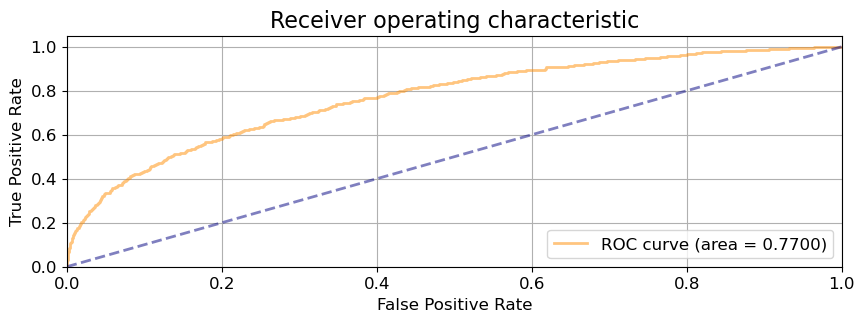

0.770031665267489

In [477]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

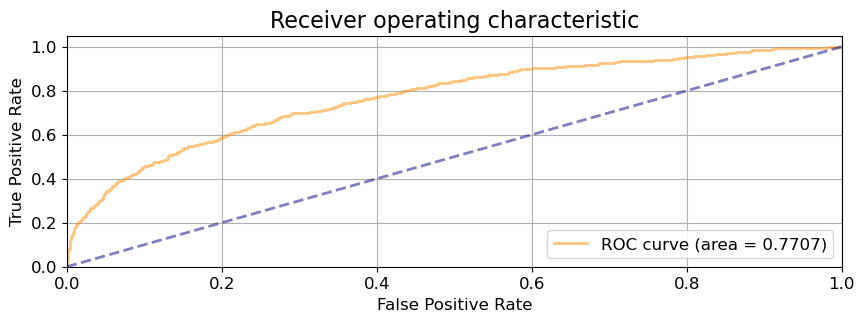

0.7707206853351984

In [437]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

(25624, 1177)


C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\511254970.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_train = train_df[train_df['learn_group_users'] == learn_group_users][feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\511254970.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_val = val_df[val_df['learn_group_users'] == learn_group_users][feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\511254970.py:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_test = test_df[test_df['learn_group_users'] == learn_group_users][feature_columns]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

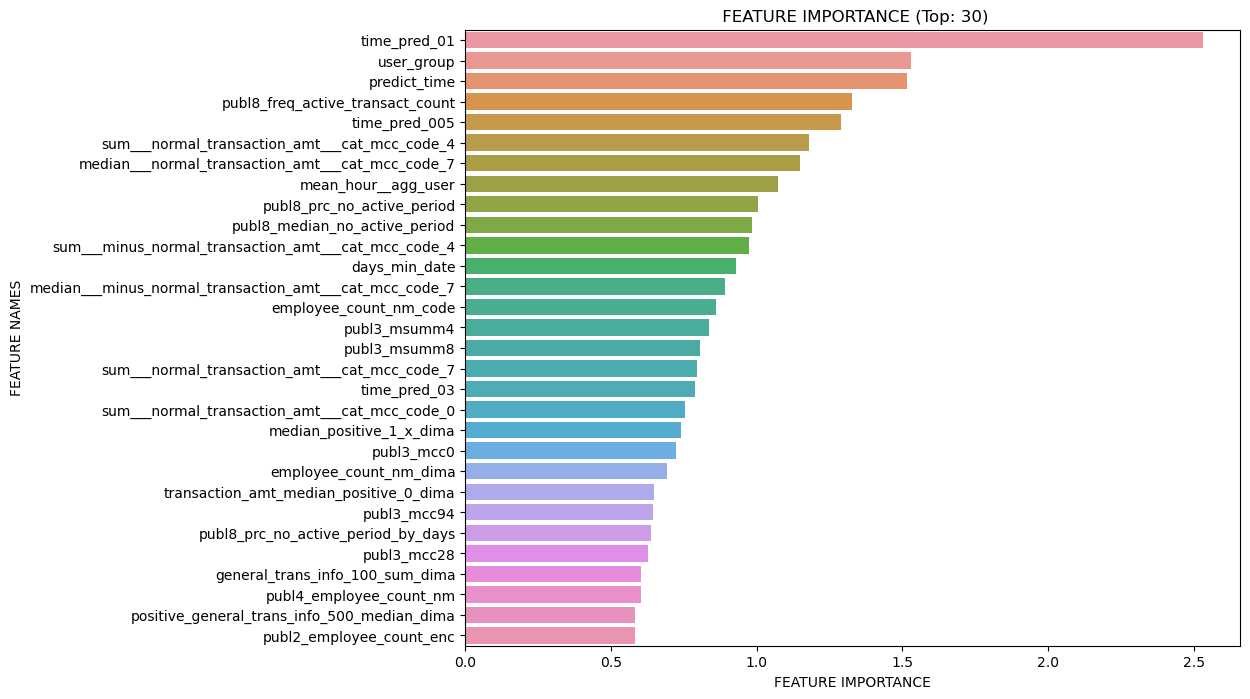

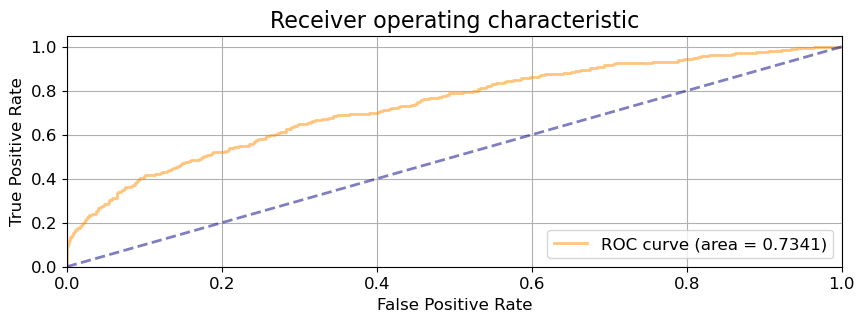

In [474]:
    
learn_group_users = 0
# scale_pos_weight
print(X_train[X_train['learn_group_users'] == learn_group_users].shape)    
#     sel_X_train = X_train[X_train['learn_group_users'] == learn_group_users]
#     sel_y_train = y_train[y_train['learn_group_users'] == learn_group_users]
#     sel_X_val = X_val[X_val['learn_group_users'] == learn_group_users]
#     sel_y_val = y_val[y_val['learn_group_users'] == learn_group_users]

sel_X_train = train_df[train_df['learn_group_users'] == learn_group_users][feature_columns]
sel_y_train = train_df[train_df['learn_group_users'] == learn_group_users][target_column]

sel_X_val = val_df[val_df['learn_group_users'] == learn_group_users][feature_columns]
sel_y_val = val_df[val_df['learn_group_users'] == learn_group_users][target_column]

sel_X_test = test_df[test_df['learn_group_users'] == learn_group_users][feature_columns]
sel_y_test = test_df[test_df['learn_group_users'] == learn_group_users][target_column]    


from sklearn.utils.class_weight import compute_class_weight
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))


scale_pos_weight = sel_y_test.value_counts().loc[0] / sel_y_test.value_counts().loc[1]
model_clf_group = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=3000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
                               learning_rate=0.04,
                               # scale_pos_weight = scale_pos_weight #7306
                               # auto_class_weights = 'Balanced', 7229
                               class_weights = class_weights # 7341
                               # auto_class_weights = 'SqrtBalanced', 
                              )

model_clf_group.fit(sel_X_train, sel_y_train, eval_set=(sel_X_val, sel_y_val), plot=True, verbose=False)

fi_df = plot_feature_importance(model_clf_group.get_feature_importance(), sel_X_train.columns, model_name='', top_n=30)  


# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf_group.predict_proba(sel_X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=sel_y_test, y_pred=y_pred)

# models_by_group[learn_group_users] = (model_clf_group, fi_df, roc_auc)

0
(25624, 1177)


C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\1220353840.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_train = train_df[train_df['learn_group_users'] == learn_group_users][feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\1220353840.py:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_val = val_df[val_df['learn_group_users'] == learn_group_users][feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\1220353840.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_test = test_df[test_df['learn_group_users'] == learn_group_users][feature_columns]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

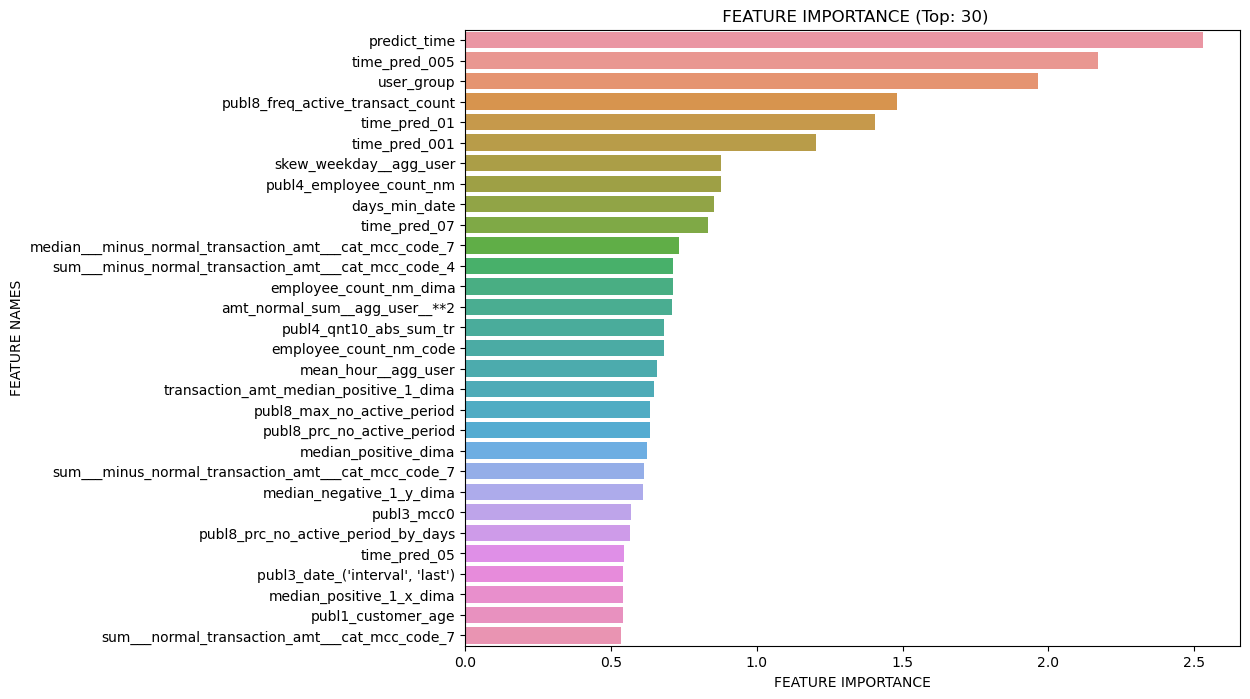

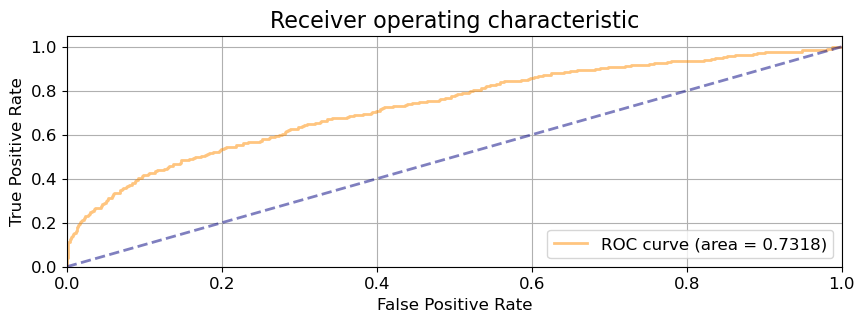

1
(25576, 1177)


C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\1220353840.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_train = train_df[train_df['learn_group_users'] == learn_group_users][feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\1220353840.py:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_val = val_df[val_df['learn_group_users'] == learn_group_users][feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\1220353840.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_test = test_df[test_df['learn_group_users'] == learn_group_users][feature_columns]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

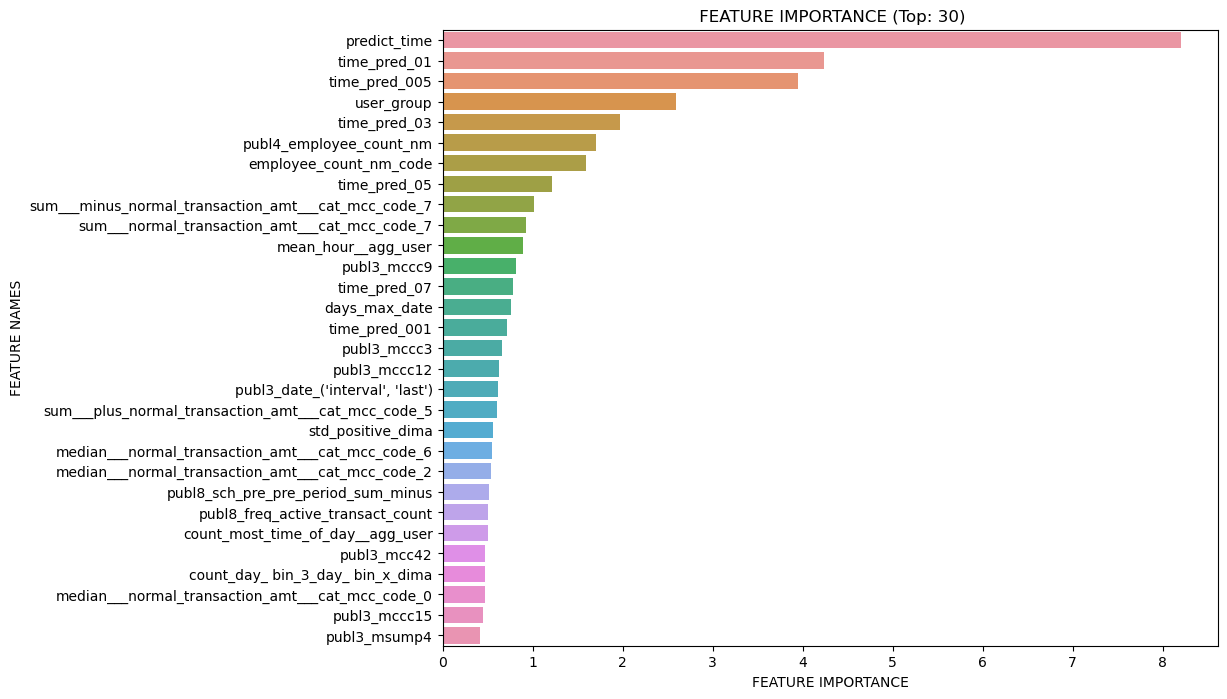

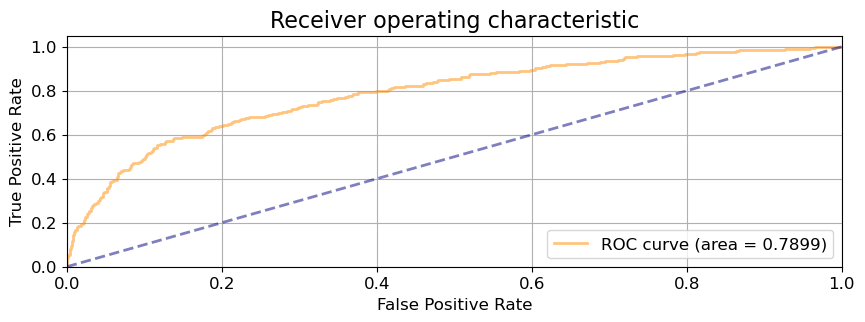

In [459]:
models_by_group = {}
# result_X_test
# result_y_test
for learn_group_users in range(len(src_train_df['learn_group_users'].unique())):
    print(learn_group_users)
    print(X_train[X_train['learn_group_users'] == learn_group_users].shape)    
#     sel_X_train = X_train[X_train['learn_group_users'] == learn_group_users]
#     sel_y_train = y_train[y_train['learn_group_users'] == learn_group_users]
#     sel_X_val = X_val[X_val['learn_group_users'] == learn_group_users]
#     sel_y_val = y_val[y_val['learn_group_users'] == learn_group_users]

    sel_X_train = train_df[train_df['learn_group_users'] == learn_group_users][feature_columns]
    sel_y_train = train_df[train_df['learn_group_users'] == learn_group_users][target_column]

    sel_X_val = val_df[val_df['learn_group_users'] == learn_group_users][feature_columns]
    sel_y_val = val_df[val_df['learn_group_users'] == learn_group_users][target_column]

    sel_X_test = test_df[test_df['learn_group_users'] == learn_group_users][feature_columns]
    sel_y_test = test_df[test_df['learn_group_users'] == learn_group_users][target_column]    
    
    
    model_clf_group = CatBoostClassifier(eval_metric="AUC", 
                                   early_stopping_rounds=500, 
                                   iterations=3000, 
                                   random_state=53, 
                                   cat_features=list(set(cat_features)&set(feature_columns)), 
                                   learning_rate=0.04
                                  )
   
    model_clf_group.fit(sel_X_train, sel_y_train, eval_set=(sel_X_val, sel_y_val), plot=True, verbose=False)
    
    fi_df = plot_feature_importance(model_clf_group.get_feature_importance(), sel_X_train.columns, model_name='', top_n=30)  
    

    # Для рассчета ROC-AUC на baseline моделе используем тестовые данные
    y_pred = model_clf_group.predict_proba(sel_X_test)[:,1]
    # Строим график ROC-AUC
    roc_auc = plot_roc_auc(y_true=sel_y_test, y_pred=y_pred)
    
    models_by_group[learn_group_users] = (model_clf_group, fi_df, roc_auc)
    

In [685]:
fi_df[:100]

feature_names  feature_importance
381                                        time_pred_01            2.533425
542                                          user_group            1.530779
2                                          predict_time            1.516544
1075                   publ8_freq_active_transact_count            1.326665
536                                       time_pred_005            1.289424
167       sum___normal_transaction_amt___cat_mcc_code_4            1.181136
1109   median___normal_transaction_amt___cat_mcc_code_7            1.150081
523                                 mean_hour__agg_user            1.074821
996                          publ8_prc_no_active_period            1.005972
198                       publ8_median_no_active_period            0.985687
896   sum___minus_normal_transaction_amt___cat_mcc_c...            0.972303
924                                       days_min_date            0.930813
562   median___minus_normal_transaction_amt___cat_mc...            0.890853
1145                             employee_count_nm_code            0.860741
661                                        publ3_msumm4            0.837799
1022                                       publ3_msumm8            0.804576
621       sum___normal_transaction_amt___cat_mcc_code_7            0.796422
721                                        time_pred_03            0.789054
620       sum___normal_transaction_amt___cat_mcc_code_0            0.753466
150                            median_positive_1_x_dima            0.739221
444                                          publ3_mcc0            0.724900
155                              employee_count_nm_dima            0.690730
543              transaction_amt_median_positive_0_dima            0.647878
309                                         publ3_mcc94            0.644711
178                  publ8_prc_no_active_period_by_days            0.638351
156                                         publ3_mcc28            0.625992
268                     general_trans_info_100_sum_dima            0.602115
101                             publ4_employee_count_nm            0.601737
569         positive_general_trans_info_500_median_dima            0.582820
993                            publ2_employee_count_enc            0.581041
812                           mean_is_holiday__agg_user            0.567194
188                                        publ3_mccc48            0.561374
945                             publ1_employee_count_nm            0.518229
306                                       time_pred_001            0.506937
665                                         publ3_mcc30            0.506623
40                                        days_max_date            0.492709
1024                                       publ3_mcc155            0.485490
614                          publ8_max_no_active_period            0.476551
149                                        time_pred_07            0.470462
452                 transaction_amt_std_positive_5_dima            0.470448
334                    mcc_code_count_positive_4_x_dima            0.459571
1169                                        publ3_mcc93            0.445116
217                                      std_1_amt_dima            0.439138
76                                         publ3_msumm7            0.437461
1008                                  std_positive_dima            0.433654
788                              skew_weekday__agg_user            0.432539
495                                median_positive_dima            0.430915
126        positive_general_trans_info_1500_median_dima            0.430164
587                      publ3_date_('interval', 'max')            0.427983
933                    publ8_sch_minus_speed_cur_prepre            0.409707
79         positive_general_trans_info_1000_median_dima            0.400796
649              transaction_amt_median_negative_3_dima            0.388009
885           

In [467]:
# models_by_group
result_y_pred = pd.DataFrame()
result_y_test = pd.DataFrame()
for learn_group_users in range(len(src_train_df['learn_group_users'].unique())):
    print(learn_group_users)
#     print(X_train[X_train['learn_group_users'] == learn_group_users].shape)    
#     sel_X_train = X_train[X_train['learn_group_users'] == learn_group_users]
    print(models_by_group[learn_group_users][0])
#     print(models_by_group[learn_group_users][2])
    sel_X_test = test_df[test_df['learn_group_users'] == learn_group_users][feature_columns]
    sel_y_test = test_df[test_df['learn_group_users'] == learn_group_users][target_column]    
    
    if learn_group_users == 0:
        sel_y_pred = model_clf.predict_proba(sel_X_test)[:,1]
    else: 
        sel_y_pred = models_by_group[learn_group_users][0].predict_proba(sel_X_test)[:,1]
    
    result_y_pred = pd.concat([result_y_pred, pd.DataFrame(sel_y_pred)])
    result_y_test = pd.concat([result_y_test, sel_y_test])    

result_y_test.shape, result_y_pred.shape

0
1


C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\1745713439.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_test = test_df[test_df['learn_group_users'] == learn_group_users][feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\1745713439.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sel_X_test = test_df[test_df['learn_group_users'] == learn_group_users][feature_columns]


((6400, 1), (6400, 1))

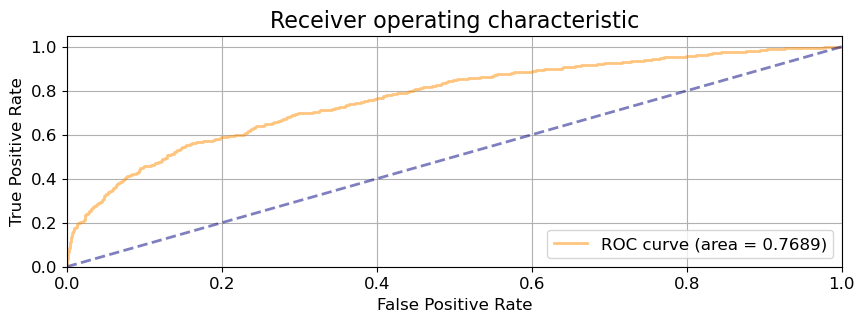

0.7688804591195624

In [468]:
# # Для рассчета ROC-AUC на baseline моделе используем тестовые данные
# y_pred = model_clf.predict_proba(X_test)[:,1]
# # Строим график ROC-AUC
# roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
# roc_auc
roc_auc = plot_roc_auc(y_true=result_y_test, y_pred=result_y_pred)
roc_auc

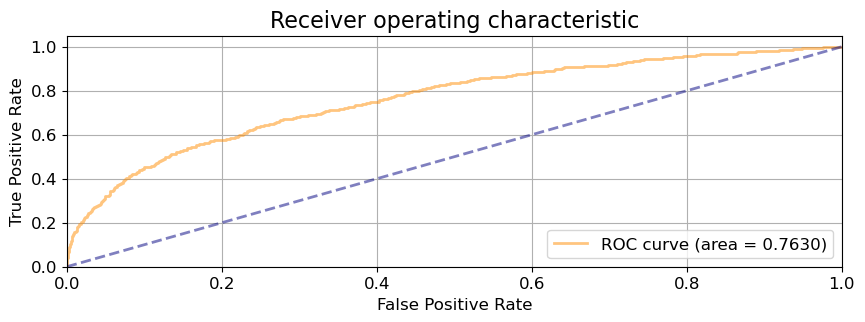

0.7630083297604614

In [461]:
roc_auc = plot_roc_auc(y_true=result_y_test, y_pred=result_y_pred)
roc_auc

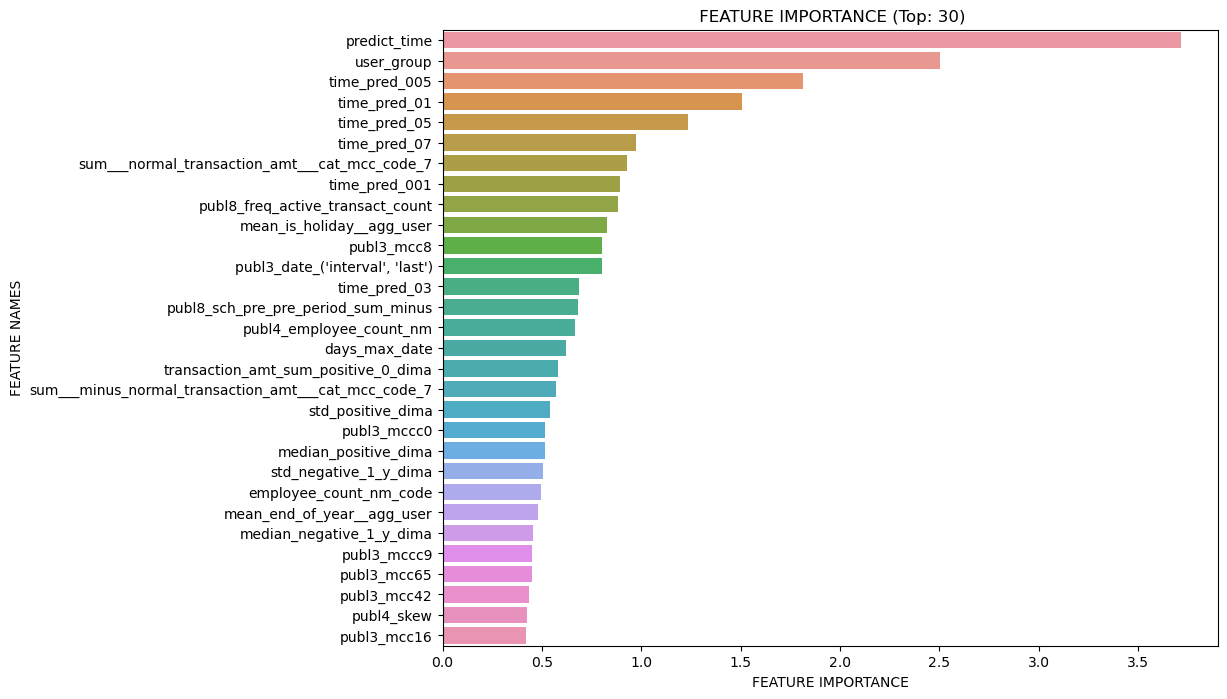

In [396]:
# Важность признаков
fi_df = plot_feature_importance(model_clf.get_feature_importance(), sel_X_train.columns, model_name='', top_n=30)  

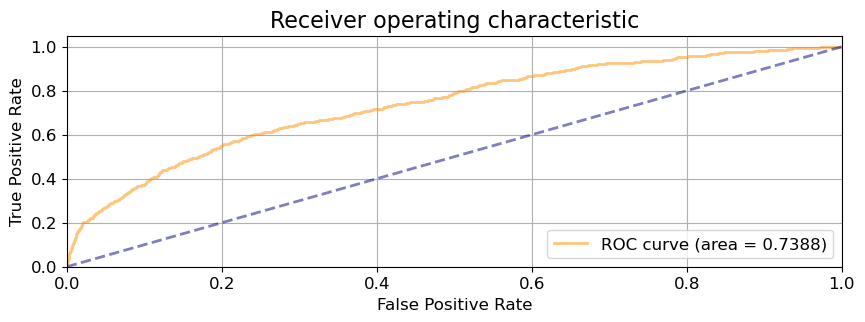

0.7388090237651982

In [397]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

In [426]:
#+ v3 + publ8 # 3000 lr=0.01 # 0.76583887  0.2150  0.2450
#- v3 + publ8 # 3000 without lr # 0.7659242289 0.1765 0.2457
#+ v3 + publ8 # 3000 lr=0.04 # 0.76624139 0.1650 0.2455
#- v3 + publ8 # 3000 optuna ivan # 0.764661566 0.2068 0.2459  # 2m 0.770365123419073 and parameters: {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}. Best is trial 15 with value: 0.770365123419073.
#- v3 + publ8 # 3000 optuna dima # 0.7658810 0.1642 0.2734 # 12m  {'colsample_bylevel': 0.13040257880154318, 'depth': 8,  'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 8.753773264677827, 'subsample': 0.5616578823756693, 'scale_pos_weight': 1.1976750349743144, 'random_strength': 0.47991140165950263, 'learning_rate': 0.019494278196021158, 'min_data_in_leaf': 7, 'boosting_type': 'Plain'}
#+/- v3 + publ8 # 3000 without lr=0.02 # 0.7666820 0.1969 0.2447
# v3 + publ8 + emb_2_2_publ6 # 3000 # 0.765498092 0.16019 0.2458 # 14m
# v3 + publ8 + emb_2_1_publ6 # 3000 # 0.7655355 0.1788 0.2446 # 2m 
#+ v3 + publ8 + 'user_group 20' # 3000 lr=0.04 #  0.7657336 0.1852350564 0.2453635 # 4m
#+ v3 + publ8 + 'user_group 20' - 'user_id' # 3000 lr=0.04 # 0.767735232 0.17083 0.2447 # 10m
#+ v3 + publ8 + 'user_group 10' - 'user_id' # 3000 lr=0.04 # 0.7647995 0.1804 0.2454 # 8m 
#+ v3 + publ8 + 'user_group 30' - 'user_id' # 3000 lr=0.04 # 0.7664839 0.1632 0.2454 # 11m 



# parameters = {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}
# parameters = {'colsample_bylevel': 0.13040257880154318, 'depth': 8,  'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 8.753773264677827, 'subsample': 0.5616578823756693, 'scale_pos_weight': 1.1976750349743144, 'random_strength': 0.47991140165950263, 'learning_rate': 0.019494278196021158, 'min_data_in_leaf': 7, 'boosting_type': 'Plain'}
# model_clf = CatBoostClassifier(**parameters, eval_metric="AUC", 
#                                # early_stopping_rounds=500, 
#                                iterations=3000, 
#                                random_state=53, 
#                                cat_features=list(set(cat_features)&set(feature_columns)), 
#                                # embedding_features=embedding_features,
#                                # learning_rate=0.04
#                               )

model_clf = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=3000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
#                                embedding_features=embedding_features,
                               learning_rate=0.04
                              )

# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

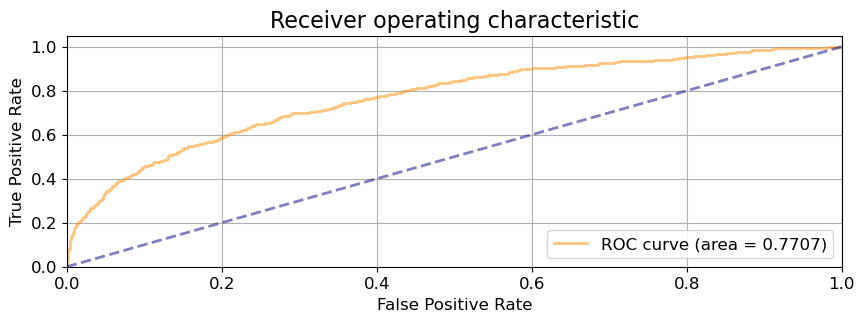

0.7707206853351984

In [427]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

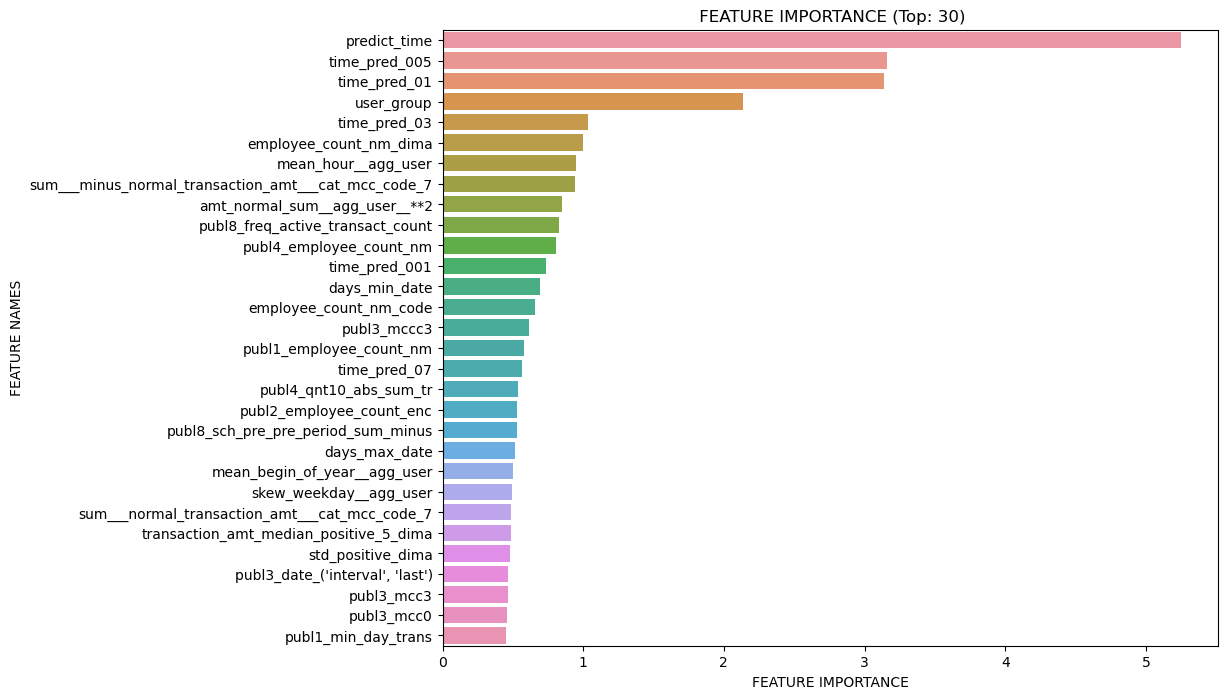

In [428]:
# Важность признаков
fi_df = plot_feature_importance(model_clf.get_feature_importance(), X_train.columns, model_name='', top_n=30)  

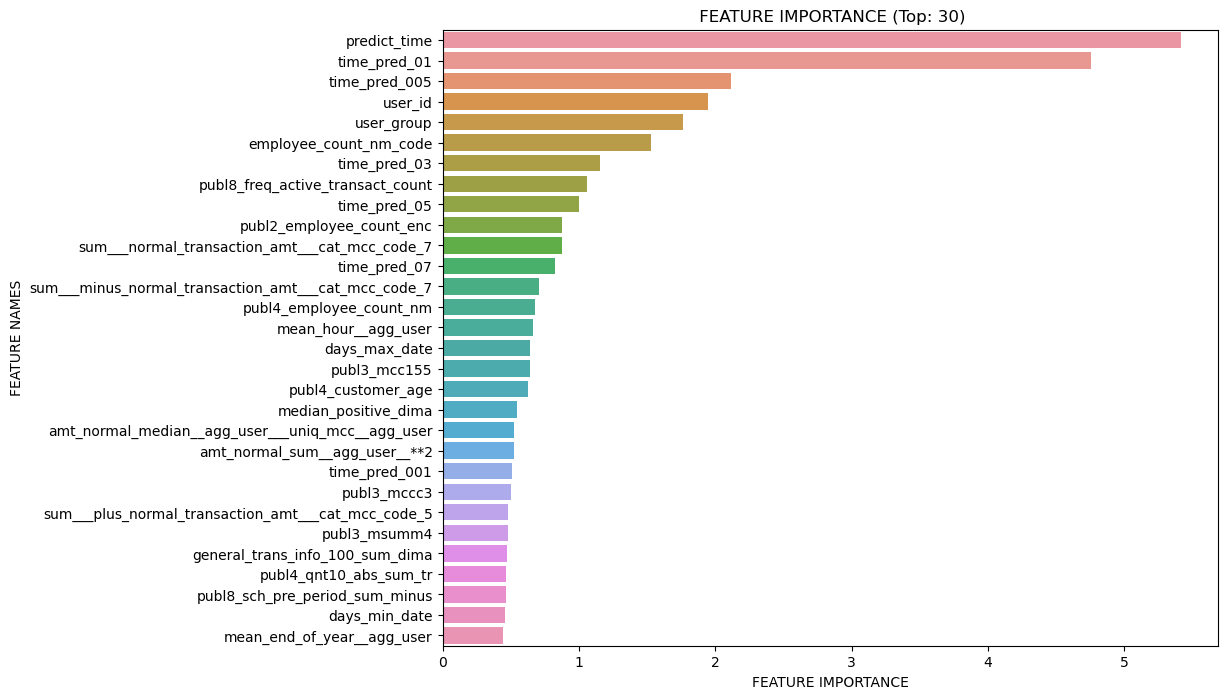

In [296]:
# Важность признаков
fi_df = plot_feature_importance(model_clf.get_feature_importance(), X_train.columns, model_name='', top_n=30)  

In [258]:
# Важность признаков
# fi_df = plot_feature_importance(model_clf.get_feature_importance(), X_train.columns, model_name='', top_n=30)  
fi_df[:50]

feature_names  feature_importance
2                                          predict_time            4.344322
382                                        time_pred_01            3.574336
253                                             user_id            3.109700
538                                       time_pred_005            2.748373
69                                         time_pred_05            1.410337
723                                        time_pred_03            1.284149
993                            publ2_employee_count_enc            1.232602
1075                   publ8_freq_active_transact_count            0.974271
1145                             employee_count_nm_code            0.912949
307                                       time_pred_001            0.886002
525                                 mean_hour__agg_user            0.811927
101                             publ4_employee_count_nm            0.806332
622       sum___normal_transaction_amt___cat_mcc_code_7            0.725465
563   median___minus_normal_transaction_amt___cat_mc...            0.657001
149                                        time_pred_07            0.643738
373                       amt_normal_sum__agg_user__**2            0.587882
1008                                  std_positive_dima            0.567841
155                              employee_count_nm_dima            0.547309
228                                         publ3_mccc3            0.543974
40                                        days_max_date            0.543733
422                                           embedding            0.542113
497                                median_positive_dima            0.508530
1109   median___normal_transaction_amt___cat_mcc_code_7            0.479638
945                             publ1_employee_count_nm            0.476380
787                                          publ3_mcc3            0.470377
745                          mean_end_of_year__agg_user            0.468299
78                      publ3_date_('interval', 'last')            0.463124
662                                        publ3_msumm4            0.461037
171                                         publ3_mccc9            0.457179
249   sum___minus_normal_transaction_amt___cat_mcc_c...            0.454997
621       sum___normal_transaction_amt___cat_mcc_code_0            0.454542
691   sum___minus_normal_transaction_amt___cat_mcc_c...            0.448100
446                                          publ3_mcc0            0.447277
758                                         publ3_mcc42            0.444178
157                                  publ2_customer_age            0.444127
925                                       days_min_date            0.437278
283                              publ4_qnt10_abs_sum_tr            0.437107
417   sum___plus_normal_transaction_amt___cat_mcc_co...            0.433220
357                               publ8_freq_active_day            0.429018
1024                                       publ3_mcc155            0.427339
990                      publ8_sch_pre_period_sum_minus            0.397407
996                          publ8_prc_no_active_period            0.393716
777              transaction_amt_median_positive_5_dima            0.393473
1022                                       publ3_msumm8            0.393206
789                              skew_weekday__agg_user            0.383753
1143                     publ8_sch_cur_period_sum_minus            0.375743
461                           publ5_trans_negative_last            0.374933
226   sum___minus_normal_transaction_amt___cat_mcc_c...            0.356884
645                                publ4_std_abs_sum_tr            0.353341
795                              publ4_qnt90_abs_sum_tr            0.350041

In [228]:
[col for col in src_train_df[feature_columns].columns if 'publ8_' in col]

C:\Users\Profit77\AppData\Local\Temp\ipykernel_29772\3105193186.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  [col for col in src_train_df[feature_columns].columns if 'publ8_' in col]


['publ8_prc_no_active_period_by_days',
 'publ8_median_no_active_period',
 'publ8_freq_active_day',
 'publ8_sch_pre_pre_period_sum_plus',
 'publ8_sch_cur_period_sum_plus',
 'publ8_active_period',
 'publ8_sch_plus_speed_cur_prepre',
 'publ8_sch_minus_speed_pre',
 'publ8_max_no_active_period',
 'publ8_sch_plus_speed_cur',
 'publ8_sch_minus_speed_cur',
 'publ8_sch_pre_period_sum_plus',
 'publ8_all_period',
 'publ8_count_account_hit',
 'publ8_unique_active_days',
 'publ8_sch_minus_speed_cur_prepre',
 'publ8_count_account_charge',
 'publ8_sch_pre_period_sum_minus',
 'publ8_prc_no_active_period',
 'publ8_sch_pre_pre_period_sum_minus',
 'publ8_freq_active_transact_count',
 'publ8_sch_plus_speed_pre',
 'publ8_sch_cur_period_sum_minus']

In [214]:
# Опредяем сильно скоррелированные столбцы
# https://stackoverflow.com/questions/44889508/remove-highly-correlated-columns-from-a-pandas-dataframe
def findCorrelation(corr, cutoff=0.9, exact=None):
    """
    This function is the Python implementation of the R function 
    `findCorrelation()`.
    
    Relies on numpy and pandas, so must have them pre-installed.
    
    It searches through a correlation matrix and returns a list of column names 
    to remove to reduce pairwise correlations.
    
    For the documentation of the R function, see 
    https://www.rdocumentation.org/packages/caret/topics/findCorrelation
    and for the source code of `findCorrelation()`, see
    https://github.com/topepo/caret/blob/master/pkg/caret/R/findCorrelation.R
    
    -----------------------------------------------------------------------------

    Parameters:
    -----------
    corr: pandas dataframe.
        A correlation matrix as a pandas dataframe.
    cutoff: float, default: 0.9.
        A numeric value for the pairwise absolute correlation cutoff
    exact: bool, default: None
        A boolean value that determines whether the average correlations be 
        recomputed at each step
    -----------------------------------------------------------------------------
    Returns:
    --------
    list of column names
    -----------------------------------------------------------------------------
    Example:
    --------
    R1 = pd.DataFrame({
        'x1': [1.0, 0.86, 0.56, 0.32, 0.85],
        'x2': [0.86, 1.0, 0.01, 0.74, 0.32],
        'x3': [0.56, 0.01, 1.0, 0.65, 0.91],
        'x4': [0.32, 0.74, 0.65, 1.0, 0.36],
        'x5': [0.85, 0.32, 0.91, 0.36, 1.0]
    }, index=['x1', 'x2', 'x3', 'x4', 'x5'])

    findCorrelation(R1, cutoff=0.6, exact=False)  # ['x4', 'x5', 'x1', 'x3']
    findCorrelation(R1, cutoff=0.6, exact=True)   # ['x1', 'x5', 'x4'] 
    """
    
    def _findCorrelation_fast(corr, avg, cutoff):

        combsAboveCutoff = corr.where(lambda x: (np.tril(x)==0) & (x > cutoff)).stack().index

        rowsToCheck = combsAboveCutoff.get_level_values(0)
        colsToCheck = combsAboveCutoff.get_level_values(1)

        msk = avg[colsToCheck] > avg[rowsToCheck].values
        deletecol = pd.unique(np.r_[colsToCheck[msk], rowsToCheck[~msk]]).tolist()

        return deletecol


    def _findCorrelation_exact(corr, avg, cutoff):

        x = corr.loc[(*[avg.sort_values(ascending=False).index]*2,)]

        if (x.dtypes.values[:, None] == ['int64', 'int32', 'int16', 'int8']).any():
            x = x.astype(float)

        x.values[(*[np.arange(len(x))]*2,)] = np.nan

        deletecol = []
        for ix, i in enumerate(x.columns[:-1]):
            for j in x.columns[ix+1:]:
                if x.loc[i, j] > cutoff:
                    if x[i].mean() > x[j].mean():
                        deletecol.append(i)
                        x.loc[i] = x[i] = np.nan
                    else:
                        deletecol.append(j)
                        x.loc[j] = x[j] = np.nan
        return deletecol

    
    if not np.allclose(corr, corr.T) or any(corr.columns!=corr.index):
        raise ValueError("correlation matrix is not symmetric.")
        
    acorr = corr.abs()
    avg = acorr.mean()
        
    if exact or exact is None and corr.shape[1]<100:
        return _findCorrelation_exact(acorr, avg, cutoff)
    else:
        return _findCorrelation_fast(acorr, avg, cutoff)

In [215]:
%%time
# Формирование матрицы корреляции
matrix_corr = src_train_df.corr()

<timed exec>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


CPU times: total: 1min 58s
Wall time: 1min 58s


In [216]:
# Ищем сильнокоррелирующие поля
hc = findCorrelation(matrix_corr, cutoff=0.9)

In [217]:
# Удялем сильнокоррелирующие поля
src_train_df = src_train_df.drop(columns=hc)
submit_df = submit_df.drop(columns=hc)

src_train_df.shape, submit_df.shape

((64000, 785), (32000, 784))

In [218]:
# save_src_train_df = src_train_df.copy()
# save_submit_df = submit_df.copy()

# src_train_df.shape, submit_df.shape

((64000, 785), (32000, 784))

In [219]:
# Загружаем доп признаки
publ7_df = pd.read_csv('public_notebooks/publ7.csv')
publ7_df = publ7_df.drop(columns=['report_dt', 'count_trans_date_min', 'count_trans_date_max'])
publ7_df = publ7_df.set_index('user_id').add_prefix('publ7_').reset_index()
publ7_df.shape

(96000, 766)

In [274]:
# publ7_df_matrix_corr = publ7_df.corr()
m = ~(publ7_df_matrix_corr.mask(np.eye(len(publ7_df_matrix_corr), dtype=bool)).abs() > 0.8).any()
# publ7_df_matrix_corr
# corr[m]

src_train_df.shape, submit_df.shape

((64000, 1473), (32000, 1472))

In [284]:
%%time
# Загружаем последние фичи
src_train_df = pd.read_csv('features_X_train__v3_2.csv')
submit_df = pd.read_csv('features_X_test__v3_2.csv')

src_train_df.shape, submit_df.shape

CPU times: total: 5.94 s
Wall time: 5.93 s


((64000, 785), (32000, 784))

In [277]:
src_train_df = src_train_df.merge(publ7_df[list(publ7_df_matrix_corr.index[m])], on='user_id')
submit_df = submit_df.merge(publ7_df[list(publ7_df_matrix_corr.index[m])], on='user_id')

src_train_df.shape, submit_df.shape

((64000, 1352), (32000, 1351))

In [286]:
# За константу также принимаем те признаки у которых больше 99,9% значений в одном значении
constant_features = []
const_threshold = 0.95
for column in tqdm(src_train_df.columns):
    unique_labels, counts = np.unique(src_train_df[column].values, return_counts=True)
    proportions = counts / len(src_train_df[column].values)
    if max(proportions > const_threshold) and len(proportions) <= 2:
        print(f"column: {column}, imbalance > {const_threshold}, proportions: {len(proportions)}, ({proportions[:2]})")
        constant_features.append(column)
    
# # Исключаем из списка фичей, те фичи у которых значения константые
# feature_columns = list(set(feature_columns) - set(constant_features))
# categorical_columns = list(set(categorical_columns) - set(constant_features))
# numeric_columns = list(set(numeric_columns) - set(constant_features))
# len(feature_columns), len(categorical_columns), len(numeric_columns)
len(constant_features)

 24%|██▎       | 186/785 [00:01<00:03, 172.15it/s]

column: publ3_mccc248, imbalance > 0.95, proportions: 2, ([9.99984375e-01 1.56250000e-05])


 33%|███▎      | 260/785 [00:01<00:03, 136.99it/s]

column: publ3_mccc371, imbalance > 0.95, proportions: 2, ([9.99984375e-01 1.56250000e-05])


 59%|█████▊    | 460/785 [00:03<00:02, 148.88it/s]

column: publ5_employee_count_nm_ОТ 31 ДО 50, imbalance > 0.95, proportions: 2, ([0.98482813 0.01517187])


 83%|████████▎ | 649/785 [00:04<00:00, 175.73it/s]

column: publ5_employee_count_nm_ДО 10, imbalance > 0.95, proportions: 2, ([0.9591875 0.0408125])
column: publ3_mcc310, imbalance > 0.95, proportions: 2, ([1.56250000e-05 9.99984375e-01])


 92%|█████████▏| 722/785 [00:04<00:00, 204.06it/s]

column: publ5_employee_count_nm_БОЛЕЕ 500, imbalance > 0.95, proportions: 2, ([0.97934375 0.02065625])
column: publ5_employee_count_nm_ОТ 11 ДО 50, imbalance > 0.95, proportions: 2, ([0.95414062 0.04585938])
column: publ1_bankemplstatus, imbalance > 0.95, proportions: 2, ([0.99678125 0.00321875])
column: median___plus_normal_transaction_amt___cat_mcc_code_1, imbalance > 0.95, proportions: 2, ([9.99984375e-01 1.56250000e-05])
column: publ5_employee_count_nm_ОТ 11 ДО 30, imbalance > 0.95, proportions: 2, ([0.980875 0.019125])


100%|██████████| 785/785 [00:05<00:00, 151.32it/s]

column: median___plus_normal_transaction_amt___cat_mcc_code_3, imbalance > 0.95, proportions: 2, ([9.99984375e-01 1.56250000e-05])


11

In [287]:
src_train_df = src_train_df.drop(columns=constant_features, errors='igmore')
submit_df = submit_df.drop(columns=constant_features, errors='igmore')

src_train_df.shape, submit_df.shape

((64000, 774), (32000, 773))

In [237]:
%%time
# Формирование матрицы корреляции
matrix_corr_publ7 = src_train_df.corr()

<timed exec>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


CPU times: total: 3min 30s
Wall time: 3min 31s


In [257]:
# matrix_corr_publ7 = matrix_corr_publ7.drop(columns=constant_features, errors='igmore')
matrix_corr_publ7 = matrix_corr_publ7[~matrix_corr_publ7.index.isin(constant_features)]
matrix_corr_publ7.shape

(1470, 1470)

In [263]:
matrix_corr_publ7

count_unique_negative_mcc_dima  \
count_unique_negative_mcc_dima                                            1.000000   
publ3_mccc328                                                             0.008274   
publ3_mcc103                                                             -0.052556   
sum___plus_normal_transaction_amt___cat_mcc_code_3                        0.003102   
publ3_mcc166                                                             -0.079765   
...                                                                            ...   
publ7_mccc413                                                             0.014550   
publ7_date_('interval', 'last')                                          -0.309682   
publ7_date_('interval', 'max')                                           -0.490048   
publ7_target                                                             -0.086797   
publ7_time                                                                0.218473   

                                                    publ3_mccc328  \
count_unique_negative_mcc_dima                           0.008274   
publ3_mccc328                                            1.000000   
publ3_mcc103                                             0.000353   
sum___plus_normal_transaction_amt___cat_mcc_code_3      -0.000104   
publ3_mcc166                                             0.000624   
...                                                           ...   
publ7_mccc413                                           -0.000080   
publ7_date_('interval', 'last')                         -0.003288   
publ7_date_('interval', 'max')                          -0.004724   
publ7_target                                            -0.000175   
publ7_time                                               0.004370   

                                                    publ3_mcc103  \
count_unique_negative_mcc_dima                         -0.052556   
publ3_mccc328                                           0.000353   
publ3_mcc103                                            1.000000   
sum___plus_normal_transaction_amt___cat_mcc_code_3      0.000334   
publ3_mcc166                                            0.001442   
...                                                          ...   
publ7_mccc413                                          -0.002548   
publ7_date_('interval', 'last')                         0.010298   
publ7_date_('interval', 'max')                          0.019590   
publ7_target                                            0.005883   
publ7_time                                             -0.010872   

                                                    sum___plus_normal_transaction_amt___cat_mcc_code_3  \
count_unique_negative_mcc_dima                                                               0.003102    
publ3_mccc328                                                                               -0.000104    
publ3_mcc103                                                                                 0.000334    
sum___plus_normal_transaction_amt___cat_mcc_code_3                                           1.000000    
publ3_mcc166                                                                                 0.000590    
...                                                                                               ...    
publ7_mccc413                                                                               -0.000075    
publ7_date_('interval', 'last')                                                             -0.004076    
publ7_date_('interval', 'max')                                                              -0.005746    
publ7_target                                                                                -0.003008    
publ7_time                                                                                   0.005502    

                                                    publ3_mcc166  \
count_unique_negative_mcc_dima  

In [258]:
# Ищем сильнокоррелирующие поля
hc_publ7 = findCorrelation(matrix_corr_publ7, cutoff=0.9)

ValueError: correlation matrix is not symmetric.

In [247]:
# ss = matrix_corr_publ7.isna().sum()
ss > 1547

count_unique_negative_mcc_dima                          18
publ3_mccc328                                           18
publ3_mcc103                                            18
sum___plus_normal_transaction_amt___cat_mcc_code_3      18
publ3_mcc166                                            18
                                                      ... 
publ7_mccc449                                         1547
publ7_date_('interval', 'last')                         18
publ7_date_('interval', 'max')                          18
publ7_target                                            18
publ7_time                                              18
Length: 1547, dtype: int64

In [232]:
src_train_df.shape, submit_df.shape

((64000, 785), (32000, 784))

In [233]:
# src_train_df.to_csv('features_X_train__v3_2.csv', index=False)
# submit_df.to_csv('features_X_test__v3_2.csv', index=False)

In [222]:
# %%time
# # Формирование матрицы корреляции
# matrix_corr = src_train_df.corr()

In [220]:
# hc = findCorrelation(matrix_corr, cutoff=0.9)
# print(hc)
# # src_train_df = src_train_df.drop(columns=hc)
# # submit_df = submit_df.drop(columns=hc)

# # src_train_df.shape, submit_df.shape

In [221]:
# matrix_corr

In [88]:
# Загружаем эмбеддинги
publ6_df = pd.read_csv('public_notebooks/publ6.csv')
emb_columns = sorted(list(set(publ6_df.columns) - set(['user_id'])))
publ6_df['embedding'] = publ6_df[emb_columns].apply(lambda x: list(x.values), axis=1)
publ6_df.shape

(96000, 130)

In [106]:
src_train_df = src_train_df.merge(publ6_df[['embedding', 'user_id']], on='user_id')
submit_df = submit_df.merge(publ6_df[['embedding', 'user_id']], on='user_id')

src_train_df.shape, submit_df.shape

((64000, 1156), (32000, 1155))

In [259]:
train_df, val_df = train_test_split(src_train_df, test_size = 0.2, random_state = 53, stratify=src_train_df['target'])
test_df, val_df = train_test_split(val_df, test_size = 0.5, random_state = 53, stratify=val_df['target'])

train_df.shape, val_df.shape, test_df.shape

((51200, 1473), (6400, 1473), (6400, 1473))

In [288]:
target_column = 'target'
feature_columns = set(src_train_df.columns) - set([target_column])
embedding_features = ['embedding']
cat_features = ['most_season_of_year__agg_user', 'most_time_of_day__agg_user', 'employee_count_nm'] 

len(feature_columns), len(cat_features)

(773, 3)

In [225]:
# important_feature_columns = list(fi_df[:300]['feature_names'].values)

In [226]:
# good_publ5_columns = ['publ5_count_trans_dates', 'publ5_trans_negative_last', 'publ5_trans_positive_last', 'publ5_report', 'publ5_mcc_code_nunique', 'publ5_day_diff_nunique']
# [c for c in feature_columns if ('publ5' in c and c not in good_publ5_columns)]

In [227]:
# fi_df[200:300]
# publ5_count_trans_dates
# publ5_trans_negative_last
# publ5_trans_positive_last
# publ5_report
# publ5_mcc_code_nunique
# publ5_day_diff_nunique
# ['publ5_count_trans_dates', 'publ5_trans_negative_last', 'publ5_trans_positive_last', 'publ5_report', 'publ5_mcc_code_nunique', 'publ5_day_diff_nunique']

In [228]:
# feature_columns = important_feature_columns

In [281]:
X_train = train_df[feature_columns]
y_train = train_df[target_column]

X_val = val_df[feature_columns]
y_val = val_df[target_column]

X_test = test_df[feature_columns]
y_test = test_df[target_column]

# X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

X_train.shape, X_val.shape, X_test.shape 

C:\Users\Profit77\AppData\Local\Temp\ipykernel_31524\1635890679.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = train_df[feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_31524\1635890679.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_val = val_df[feature_columns]
C:\Users\Profit77\AppData\Local\Temp\ipykernel_31524\1635890679.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test = test_df[feature_columns]


((51200, 1335), (6400, 1335), (6400, 1335))

In [282]:
model_clf = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=10000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
                               # embedding_features=embedding_features,
                               learning_rate=0.01)
# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [230]:
model_clf = CatBoostClassifier(eval_metric="AUC", 
                               early_stopping_rounds=500, 
                               iterations=10000, 
                               random_state=53, 
                               cat_features=list(set(cat_features)&set(feature_columns)), 
                               # embedding_features=embedding_features,
                               learning_rate=0.01)
# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

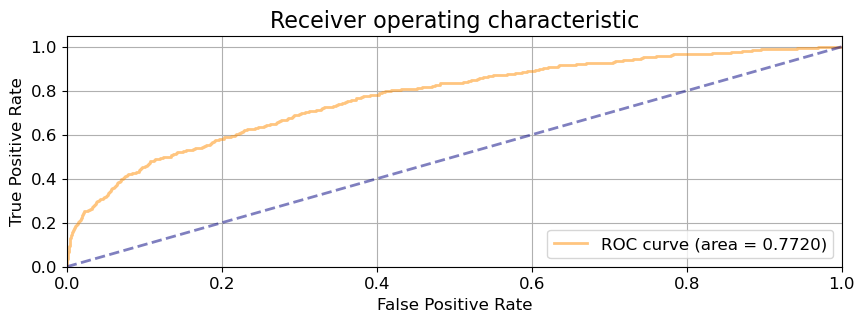

0.7719643286991686

In [231]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

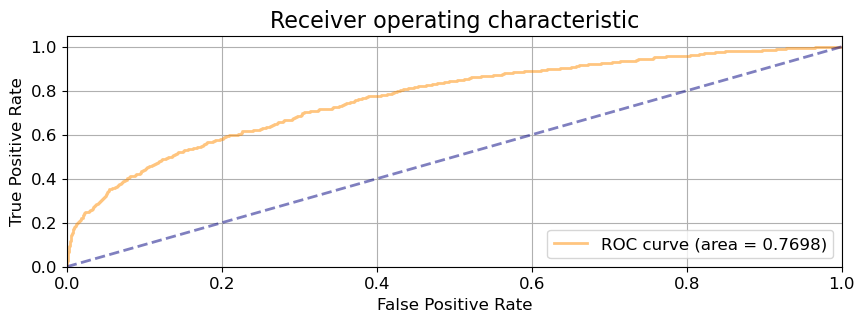

0.7697805389058147

In [66]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

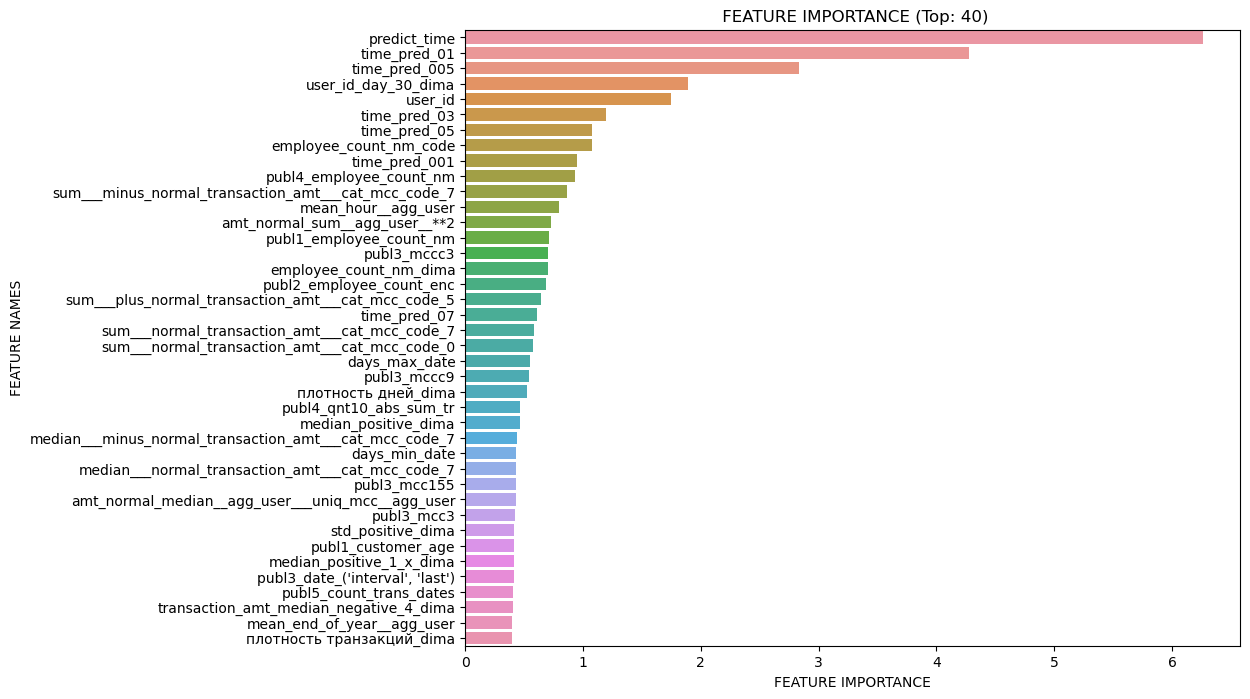

In [67]:
# Важность признаков
fi_df = plot_feature_importance(model_clf.get_feature_importance(), X_train.columns, model_name='', top_n=40)  

In [75]:
fi_df[:100]
# publ5_count_trans_dates
# publ5_trans_negative_last
# publ5_trans_positive_last
# publ5_report
# publ5_mcc_code_nunique
# publ5_day_diff_nunique

feature_names  feature_importance
534                                        predict_time            6.265893
734                                        time_pred_01            4.278053
651                                       time_pred_005            2.832505
428                                 user_id_day_30_dima            1.888348
742                                             user_id            1.749099
767                                        time_pred_03            1.198130
188                                        time_pred_05            1.077934
171                              employee_count_nm_code            1.075125
477                                       time_pred_001            0.951148
993                             publ4_employee_count_nm            0.927251
93    sum___minus_normal_transaction_amt___cat_mcc_c...            0.866446
848                                 mean_hour__agg_user            0.791606
42                        amt_normal_sum__agg_user__**2            0.730188
34                              publ1_employee_count_nm            0.709735
811                                         publ3_mccc3            0.700757
655                              employee_count_nm_dima            0.699671
1060                           publ2_employee_count_enc            0.681196
83    sum___plus_normal_transaction_amt___cat_mcc_co...            0.643297
316                                        time_pred_07            0.610674
442       sum___normal_transaction_amt___cat_mcc_code_7            0.584760
901       sum___normal_transaction_amt___cat_mcc_code_0            0.576452
145                                       days_max_date            0.547378
994                                         publ3_mccc9            0.537726
208                                 плотность дней_dima            0.521262
852                              publ4_qnt10_abs_sum_tr            0.467527
707                                median_positive_dima            0.460889
368   median___minus_normal_transaction_amt___cat_mc...            0.438685
183                                       days_min_date            0.430640
818    median___normal_transaction_amt___cat_mcc_code_7            0.429739
599                                        publ3_mcc155            0.426677
429    amt_normal_median__agg_user___uniq_mcc__agg_user            0.426414
605                                          publ3_mcc3            0.422677
781                                   std_positive_dima            0.417008
526                                  publ1_customer_age            0.414461
897                            median_positive_1_x_dima            0.412715
289                     publ3_date_('interval', 'last')            0.411288
151                             publ5_count_trans_dates            0.406616
572              transaction_amt_median_negative_4_dima            0.405227
68                           mean_end_of_year__agg_user            0.398000
638                           плотность транзакций_dima            0.395733
962                                        publ3_msumm7            0.390974
1015                                        publ3_mcc28            0.380112
1053  sum___minus_normal_transaction_amt___cat_mcc_c...            0.379078
4                                           publ3_mcc42            0.370342
620                        mean_begin_of_year__agg_user            0.368806
110                                         publ3_mccc0            0.363751
978                                          publ3_mcc0            0.359890
881                                        publ3_msumm4            0.357100
660                              skew_weekday__agg_user            0.353666
280                    currency_daydiff_1500_sum_1_dima            0.347864
70               transaction_amt_median_positive_5_dima            0.336681
1147  sum___minus_normal_transaction_amt___cat_mcc_c...            0.335169
333           

In [ ]:
# Подбор гиперпараметров 

# # 1 hour 4 m  0.7081081915291669 and parameters: {'random_strength': 0.4877835608541662, 'bagging_temperature': 7.328762300265087, 'border_count': 64, 'l2_leaf_reg': 0.0007188656778274362, 'learning_rate': 0.03087417961724621, 'max_depth': 15, 'subsample': 0.6060460481741542, 'colsample_bylevel': 0.37109270105885217, 'min_data_in_leaf': 40}. Best is trial 3 with value: 0.7677449956472935.
# # 1h 5m  0.7553564746982396 and parameters: {'random_strength': 0.7819699890386805, 'bagging_temperature': 9.754135319676179, 'border_count': 16, 'l2_leaf_reg': 12.104897228001908, 'learning_rate': 0.0983824932143533, 'max_depth': 15, 'subsample': 0.23933532903265448, 'colsample_bylevel': 0.2705278505465295, 'min_data_in_leaf': 98}. Best is trial 3 with value: 0.7677449956472935.
# # 1h 50m 0.732127446743911 and parameters: {'random_strength': 0.6663800374289677, 'bagging_temperature': 5.417199896472974, 'border_count': 256, 'l2_leaf_reg': 0.028645043290344903, 'learning_rate': 0.004970153667357669, 'max_depth': 13, 'subsample': 0.48360105226679184, 'colsample_bylevel': 0.6068555377131062, 'min_data_in_leaf': 23}. Best is trial 15 with value: 0.770365123419073.
# # 45m 0.7600597284566222 and parameters: {'random_strength': 0.41591580937930017, 'bagging_temperature': 6.58006403058364, 'border_count': 1024, 'l2_leaf_reg': 0.11546521431985014, 'learning_rate': 0.001889071936354402, 'max_depth': 10, 'subsample': 0.5320376571604306, 'colsample_bylevel': 0.9547286589569808, 'min_data_in_leaf': 13}. Best is trial 3 with value: 0.7677449956472935.
# # 28m  0.7651472298266855 and parameters: {'random_strength': 0.9639904775650652, 'bagging_temperature': 9.802421965693892, 'border_count': 32, 'l2_leaf_reg': 2.1876733497044576, 'learning_rate': 0.004815280638331712, 'max_depth': 12, 'subsample': 0.379165594314427, 'colsample_bylevel': 0.7703767777160331, 'min_data_in_leaf': 99}. Best is trial 3 with value: 0.7677449956472935.
# # 13m 0.7185726398062888 and parameters: {'random_strength': 0.36215143542851874, 'bagging_temperature': 4.412510211606131, 'border_count': 512, 'l2_leaf_reg': 0.0003745496093343704, 'learning_rate': 0.016777863904997845, 'max_depth': 9, 'subsample': 0.9240379583912689, 'colsample_bylevel': 0.6892579066981328, 'min_data_in_leaf': 47}. Best is trial 15 with value: 0.770365123419073.
# # 10m 0.7623220650096566 and parameters: {'random_strength': 0.356860344004182, 'bagging_temperature': 4.618962404969036, 'border_count': 512, 'l2_leaf_reg': 0.18815865484252067, 'learning_rate': 0.0023937889983948325, 'max_depth': 9, 'subsample': 0.9235562227095705, 'colsample_bylevel': 0.69242799618673, 'min_data_in_leaf': 41}. Best is trial 0 with value: 0.7623220650096566.

# # 4m 0.6853226231135647 and parameters: {'random_strength': 0.18235950929436537, 'bagging_temperature': 6.858830199410246, 'border_count': 32, 'l2_leaf_reg': 0.0040295486593562016, 'learning_rate': 0.07184200324965376, 'max_depth': 11, 'subsample': 0.15207869271589394, 'colsample_bylevel': 0.08600944919729483, 'min_data_in_leaf': 81}. Best is trial 3 with value: 0.7677449956472935.
# # 3m 0.7586165952134087 and parameters: {'random_strength': 0.1200919298190417, 'bagging_temperature': 4.465601655563133, 'border_count': 256, 'l2_leaf_reg': 0.04563038629317424, 'learning_rate': 0.054820778828215594, 'max_depth': 5, 'subsample': 0.7434866228117001, 'colsample_bylevel': 0.4746647518284687, 'min_data_in_leaf': 33}. Best is trial 0 with value: 0.7623220650096566.
# # 1m  0.7666656378069414 and parameters: {'random_strength': 0.5438113421389065, 'bagging_temperature': 3.961233875660944, 'border_count': 1024, 'l2_leaf_reg': 0.0024789745613403103, 'learning_rate': 0.00980034933463799, 'max_depth': 4, 'subsample': 0.7309059610265581, 'colsample_bylevel': 0.19050169842753084, 'min_data_in_leaf': 29}. Best is trial 2 with value: 0.7666656378069414.
# # 2m 0.7677449956472935 and parameters: {'random_strength': 0.1411360960399606, 'bagging_temperature': 8.880332018146513, 'border_count': 32, 'l2_leaf_reg': 1.019314171350347, 'learning_rate': 0.031914830167293746, 'max_depth': 5, 'subsample': 0.6041617528697946, 'colsample_bylevel': 0.3886648645462683, 'min_data_in_leaf': 87}. Best is trial 3 with value: 0.7677449956472935.
# # 4m 0.7578928238923904 and parameters: {'random_strength': 0.23756234585080094, 'bagging_temperature': 6.42214658244568, 'border_count': 512, 'l2_leaf_reg': 0.001059515046384789, 'learning_rate': 0.021354963214691967, 'max_depth': 6, 'subsample': 0.893689226400846, 'colsample_bylevel': 0.8168397041380171, 'min_data_in_leaf': 59}. Best is trial 3 with value: 0.7677449956472935.
# # 3 m 0.7676243670937904 and parameters: {'random_strength': 0.28511109102872495, 'bagging_temperature': 2.515830746301902, 'border_count': 32, 'l2_leaf_reg': 0.21796527115330408, 'learning_rate': 0.008885334556583689, 'max_depth': 6, 'subsample': 0.4892525374098944, 'colsample_bylevel': 0.7912954323696259, 'min_data_in_leaf': 45}. Best is trial 3 with value: 0.7677449956472935.
# # 3 m 0.7660502117141349 and parameters: {'random_strength': 0.20553110785537693, 'bagging_temperature': 7.138717386553042, 'border_count': 128, 'l2_leaf_reg': 0.000972297706864629, 'learning_rate': 0.010386219006941828, 'max_depth': 3, 'subsample': 0.40582883336095293, 'colsample_bylevel': 0.9679514745790526, 'min_data_in_leaf': 38}. Best is trial 3 with value: 0.7677449956472935.
# # 3m 0.7662190286976273 and parameters: {'random_strength': 0.7562070644244083, 'bagging_temperature': 0.9247199505507142, 'border_count': 32, 'l2_leaf_reg': 1.9559958310038787, 'learning_rate': 0.005600438489798872, 'max_depth': 7, 'subsample': 0.34983776043333037, 'colsample_bylevel': 0.627587017306623, 'min_data_in_leaf': 62}. Best is trial 3 with value: 0.7677449956472935.
# # 3m 0.7592786349509109 and parameters: {'random_strength': 0.3106200304995529, 'bagging_temperature': 1.9260051433957923, 'border_count': 32, 'l2_leaf_reg': 0.45952852798531907, 'learning_rate': 0.021767747307190978, 'max_depth': 8, 'subsample': 0.6456700291799148, 'colsample_bylevel': 0.5311773377096795, 'min_data_in_leaf': 77}. Best is trial 3 with value: 0.7677449956472935.
# # 3m 0.7686249856694538 and parameters: {'random_strength': 0.12168306459684444, 'bagging_temperature': 3.054442548463664, 'border_count': 32, 'l2_leaf_reg': 0.012371254057154354, 'learning_rate': 0.011695884594447392, 'max_depth': 6, 'subsample': 0.4836430136668511, 'colsample_bylevel': 0.43693190185925523, 'min_data_in_leaf': 8}. Best is trial 14 with value: 0.7686249856694538.
# # 2m 0.770365123419073 and parameters: {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7677330272790608 and parameters: {'random_strength': 0.6436402884136181, 'bagging_temperature': 2.99541302061361, 'border_count': 16, 'l2_leaf_reg': 0.00999207256359148, 'learning_rate': 0.017115678744046063, 'max_depth': 3, 'subsample': 0.7823886942005437, 'colsample_bylevel': 0.3299066493456262, 'min_data_in_leaf': 6}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7436857408860876 and parameters: {'random_strength': 0.11329380924303452, 'bagging_temperature': 0.7213560956117973, 'border_count': 16, 'l2_leaf_reg': 0.00013351963347124513, 'learning_rate': 0.0010898556854082634, 'max_depth': 3, 'subsample': 0.08245022583969724, 'colsample_bylevel': 0.5012574147627783, 'min_data_in_leaf': 18}. Best is trial 15 with value: 0.770365123419073.
# # 3 m 0.7187581495138952 and parameters: {'random_strength': 0.4311070714949682, 'bagging_temperature': 3.334236157804488, 'border_count': 64, 'l2_leaf_reg': 0.023195976251140456, 'learning_rate': 0.044917126588457534, 'max_depth': 7, 'subsample': 0.9942253909672493, 'colsample_bylevel': 0.20157600138684834, 'min_data_in_leaf': 1}. Best is trial 15 with value: 0.770365123419073.
# # 3m 0.7690511225699489 and parameters: {'random_strength': 0.37186763151947955, 'bagging_temperature': 1.7154788183066343, 'border_count': 128, 'l2_leaf_reg': 0.00011736187149090363, 'learning_rate': 0.014947547431915422, 'max_depth': 5, 'subsample': 0.837273997330367, 'colsample_bylevel': 0.4307656088410189, 'min_data_in_leaf': 10}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7685796318529932 and parameters: {'random_strength': 0.25394919082490486, 'bagging_temperature': 1.857381963749643, 'border_count': 128, 'l2_leaf_reg': 0.004185836770724565, 'learning_rate': 0.013506480144289332, 'max_depth': 5, 'subsample': 0.8489484318148801, 'colsample_bylevel': 0.4366413387252729, 'min_data_in_leaf': 11}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7674010625391334 and parameters: {'random_strength': 0.34102674703366276, 'bagging_temperature': 0.17427920975756628, 'border_count': 128, 'l2_leaf_reg': 0.0001544572878642479, 'learning_rate': 0.034343061548256996, 'max_depth': 4, 'subsample': 0.6925149496557448, 'colsample_bylevel': 0.27572891153281753, 'min_data_in_leaf': 19}. Best is trial 15 with value: 0.770365123419073.
# # 3m 0.7587797429698435 and parameters: {'random_strength': 0.10114941390464927, 'bagging_temperature': 1.7803952866129829, 'border_count': 16, 'l2_leaf_reg': 0.009564943526882154, 'learning_rate': 0.007153755831638318, 'max_depth': 8, 'subsample': 0.8081208567067153, 'colsample_bylevel': 0.51388835594809, 'min_data_in_leaf': 1}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7674224796191287 and parameters: {'random_strength': 0.208970062934476, 'bagging_temperature': 3.60714396586842, 'border_count': 128, 'l2_leaf_reg': 0.00021141487216976514, 'learning_rate': 0.014794556827658326, 'max_depth': 4, 'subsample': 0.9850965465081523, 'colsample_bylevel': 0.5715795678321548, 'min_data_in_leaf': 23}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7579605396600226 and parameters: {'random_strength': 0.40350491986043185, 'bagging_temperature': 5.5339785439725455, 'border_count': 16, 'l2_leaf_reg': 0.0004700395324613062, 'learning_rate': 0.024498532918250805, 'max_depth': 6, 'subsample': 0.5524553225150555, 'colsample_bylevel': 0.4188771787966754, 'min_data_in_leaf': 13}. Best is trial 15 with value: 0.770365123419073.
# # 3 m 0.7643670811921502 and parameters: {'random_strength': 0.5166365186058708, 'bagging_temperature': 2.5823784156927, 'border_count': 128, 'l2_leaf_reg': 0.06765132539290941, 'learning_rate': 0.0035396001126239965, 'max_depth': 7, 'subsample': 0.6768533747312123, 'colsample_bylevel': 0.29979695001660445, 'min_data_in_leaf': 30}. Best is trial 15 with value: 0.770365123419073.
# # 2m 0.7639973216051723 and parameters: {'random_strength': 0.17400368569232882, 'bagging_temperature': 1.1996883681471529, 'border_count': 64, 'l2_leaf_reg': 0.016405712463422255, 'learning_rate': 0.050299236571476266, 'max_depth': 4, 'subsample': 0.27010903910620854, 'colsample_bylevel': 0.19313514080595415, 'min_data_in_leaf': 8}. Best is trial 15 with value: 0.770365123419073.
# # 3m 0.7392845309470507 and parameters: {'random_strength': 0.6211670192991839, 'bagging_temperature': 2.5451556699511375, 'border_count': 256, 'l2_leaf_reg': 0.002105591253628826, 'learning_rate': 0.012627892937413811, 'max_depth': 9, 'subsample': 0.8461975993636881, 'colsample_bylevel': 0.09290272968356755, 'min_data_in_leaf': 18}. Best is trial 15 with value: 0.770365123419073.
# Best hyperparameters: {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}
# Best AUC: 0.770365123419073
# CPU times: total: 1d 18h 51min 51s
# Wall time: 6h 41min 48s

In [ ]:
# fi_df[:100][98:99]['feature_names'].item()
# amt_normal_sum__agg_user ** 2
# amt_normal_median__agg_user ** 2
# amt_normal_max__agg_user ** 2
# minus_amt_normal_skew__agg_user ** 2
# fi_df[:100].reset_index()
# fi_df[49:50]['feature_names'].item()

In [ ]:
# from typing import List
# def gen_num_features(df:pd.DataFrame, columns:List[str]):
#     add_features = []
#     for column_1 in columns:
#         # df[f'sin_{column_1}'] = np.sin(df[column_1])
#         # add_features.append(f'sin_{column_1}')
#         for column_2 in columns:
#             df[f'{column_1}_{column_2}'] = df[column_1] * df[column_2]
#             add_features.append(f'{column_1}_{column_2}')
#     return df, add_features
# amt_normal_count__agg_user
# # gen_num_feat_columns = ['amt_count__agg_user', 'amt_var__agg_user',  'amt_mad__agg_user',  'amt_skew__agg_user', 'amt_normal_count__agg_user',  'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'uniq_mcc__agg_user',]
# # [ 'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_std__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'amt_normal_var__agg_user', 'amt_normal_skew__agg_user' ]
# # gen_num_feat_columns = ['plus_amt_normal_count__agg_user', 'plus_amt_normal_sum__agg_user', 'plus_amt_normal_median__agg_user', 'plus_amt_normal_min__agg_user', 'plus_amt_normal_max__agg_user', 'amt_normal_count__agg_user', 'amt_normal_sum__agg_user', 'amt_normal_median__agg_user', 'amt_normal_min__agg_user', 'amt_normal_max__agg_user', 'minus_amt_normal_count__agg_user', 'minus_amt_normal_sum__agg_user', 'minus_amt_normal_std__agg_user', 'minus_amt_normal_median__agg_user', 'minus_amt_normal_min__agg_user', 'minus_amt_normal_max__agg_user', 'minus_amt_normal_var__agg_user', 'minus_amt_normal_skew__agg_user',]
# gen_num_feat_columns = ['amt_normal_sum__agg_user', 'amt_normal_median__agg_user', 'amt_normal_max__agg_user', 
#                         'minus_amt_normal_sum__agg_user', 'minus_amt_normal_skew__agg_user',]
# df, add_features = gen_num_features(df=train_df, columns=gen_num_feat_columns)
# num_features += add_features 
# num_features = list(set(num_features))
# feature_columns = num_features + cat_features
# len(feature_columns)

In [ ]:
#train_df.shape
publ1_df = pd.read_csv('public_notebooks/publ1.csv')
publ1_df = publ1_df.set_index('user_id').add_prefix('publ1_').reset_index()

publ2_df = pd.read_csv('public_notebooks/publ2.csv')
publ2_df = publ2_df.set_index('user_id').add_prefix('publ2_').reset_index()

publ3_df = pd.read_csv('public_notebooks/publ3.csv')
publ3_df = publ3_df.set_index('user_id').add_prefix('publ3_').reset_index()

publ4_df = pd.read_csv('public_notebooks/publ4.csv')
publ4_df = publ4_df.set_index('user_id').add_prefix('publ4_').reset_index()

publ5_df = pd.read_csv('public_notebooks/publ5.csv')
publ5_df = publ5_df.set_index('user_id').add_prefix('publ5_').reset_index()

publ1_df.shape, publ2_df.shape, publ3_df.shape, publ4_df.shape

In [ ]:
publ2_df = publ2_df[list(set(publ2_df.columns) - set(['publ2_report_dt', 'publ2_last', 'publ2_employee_count_nm']))]

In [ ]:
publ2_df = publ2_df[list(set(publ2_df.columns) - set(['publ2_report_dt', 'publ2_last', 'publ2_employee_count_nm']))]

bad_feats_publ3 = ['publ3_mcc407',  'publ3_mcc309',  'publ3_mccc144',  'publ3_mcc323',  'publ3_mcc228',  'publ3_mccc111',  'publ3_mccc199',  'publ3_mcc154',  'publ3_mccc296',  'publ3_mccc173',  'publ3_mccc234',  'publ3_mccc163',  'publ3_mccc346',  'publ3_mccc287',  'publ3_mccc317',  'publ3_mcc360',  'publ3_mccc340',  'publ3_mccc284',  'publ3_mccc413',  'publ3_mccc297',  'publ3_mccc237',  'publ3_mccc116',  'publ3_mcc330',  'publ3_mccc304',  'publ3_mcc263',  'publ3_mccc407',  'publ3_mccc217',  'publ3_mccc392',  'publ3_mcc297',  'publ3_mccc250',  'publ3_mcc292',  'publ3_mccc228',  'publ3_mcc342',  'publ3_mccc300',  'publ3_mcc287',  'publ3_mccc252',  'publ3_mccc207',  'publ3_mccc356',  'publ3_mccc273',  'publ3_mccc201',  'publ3_mccc168',  'publ3_mcc322',  'publ3_mccc246',  'publ3_mccc342',  'publ3_mccc283',  'publ3_mcc195',  'publ3_mccc259',  'publ3_mccc332',  'publ3_mcc284',  'publ3_mccc322',  'publ3_mcc298',  'publ3_mcc307',  'publ3_mccc310',  'publ3_mcc434',  'publ3_mcc283',  'publ3_mccc382',  'publ3_mccc271',  'publ3_mccc372',  'publ3_mccc154',  'publ3_mccc314',  'publ3_mccc316',  'publ3_mccc278',  'publ3_mccc238',  'publ3_mccc227',  'publ3_mcc221',  'publ3_mccc220',  'publ3_mccc151',  'publ3_mcc276',  'publ3_mccc364',  'publ3_mcc303',  'publ3_mccc309',  'publ3_mcc291',  'publ3_mcc208',  'publ3_mccc298',  'publ3_mccc291',  'publ3_mccc330',  'publ3_mccc226',  'publ3_mccc239',  'publ3_mcc424',  'publ3_mccc177',  'publ3_mcc239',  'publ3_mccc360',  'publ3_mcc392',  'publ3_mccc449',  'publ3_mccc104',  'publ3_mccc253',  'publ3_mccc240',  'publ3_mcc243',  'publ3_mccc243',  'publ3_mccc198',  'publ3_mccc272',  'publ3_mccc235',  'publ3_mccc307',  'publ3_mccc293',  'publ3_mccc269',  'publ3_mccc208',  'publ3_mcc372',  'publ3_mccc270',  'publ3_mcc371',  'publ3_mccc323',  'publ3_mcc413',  'publ3_mcc314',  'publ3_mcc48',  'publ3_mcc293',  'publ3_mcc304',  'publ3_mccc424',  'publ3_mcc300',  'publ3_mccc232',  'publ3_mccc280',  'publ3_mccc241',  'publ3_mcc246',  'publ3_mccc311',  'publ3_mcc238',  'publ3_mcc449',  'publ3_mccc327',  'publ3_mcc273',  'publ3_mccc124',  'publ3_mccc305',  'publ3_mccc274',  'publ3_mccc258',  'publ3_mccc263',  'publ3_mccc266',  'publ3_mccc302',  'publ3_mccc202',  'publ3_mccc92',  'publ3_mccc318',  'publ3_mccc276',  'publ3_mccc167',  'publ3_mccc95',  'publ3_mccc185',  'publ3_mccc242',  'publ3_mcc227',  'publ3_mccc222',  'publ3_mccc251',  'publ3_mccc264',  'publ3_mccc282',  'publ3_mcc198',  'publ3_mcc346',  'publ3_mccc434',  'publ3_mccc338',  'publ3_mcc271',  'publ3_mccc221',  'publ3_mccc231',  'publ3_mccc277',  'publ3_mccc196',  'publ3_mccc200',  'publ3_mcc141',  'publ3_mccc193',  'publ3_mcc250',  'publ3_mcc259',  'publ3_mccc306',  'publ3_mccc236',  'publ3_mccc40',  'publ3_mcc106',  'publ3_mccc303',  'publ3_mccc150',  'publ3_mcc312',  'publ3_mcc274',  'publ3_mccc149',  'publ3_mccc191',  'publ3_mccc412',  'publ3_mccc368',  'publ3_mccc268'] 
publ3_df = publ3_df[list(set(publ3_df.columns) - set(['publ3_employee_count_nm', 'publ2_employee_count_nm']) -set(bad_feats_publ3))]
publ3_df = publ3_df.fillna(0)
publ3_df.shape

In [ ]:
publ_df = publ1_df.merge(publ2_df, on='user_id')
publ_df = publ_df.merge(publ3_df, on='user_id')
publ_df = publ_df.merge(publ4_df, on='user_id')
publ_df = publ_df.merge(publ5_df, on='user_id')
publ_df.shape

In [ ]:
# publ1_df_columns = ['publ1_min_day_trans', 'publ1_sum_trans_m', 'publ1_sum_trans_p', 'publ1_count_trans', 'publ1_customer_age', 'publ1_max_day_trans', 'publ1_employee_count_nm', 'publ1_sum_trans', 'publ1_bankemplstatus']
#  publ1_df.clumns
publ_columns = list(set(publ_df.columns) - set(['user_id']))
len(publ_columns)
# publ_df.isna().sum()

In [ ]:
src_train_df = src_train_df.merge(publ_df, on='user_id')
src_train_df.shape

In [ ]:
src_X_submit = X_submit.merge(publ_df, on='user_id')
src_X_submit.shape

In [ ]:
train_df, val_df = train_test_split(src_train_df, test_size = 0.2, random_state = 53, stratify=train_df['target'])
test_df, val_df = train_test_split(val_df, test_size = 0.5, random_state = 53, stratify=val_df['target'])
train_df.shape, val_df.shape, test_df.shape

In [ ]:
# important_features = feature_columns
# important_features = feature_columns

In [ ]:
# len(publ_columns)

In [ ]:
target_column = 'target'
# select_features = list(set(feature_columns)&set(important_features))
# select_features = list(set(feature_columns) - set(['user_id']))
select_features = list(set(feature_columns) - set([]))

X_train = train_df[select_features + publ_columns + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_train = train_df[target_column]

X_val = val_df[select_features + publ_columns  + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_val = val_df[target_column]

X_test = test_df[select_features + publ_columns  + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_test = test_df[target_column]

X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

X_train.shape, X_val.shape, X_test.shape, X_test_submit.shape

In [ ]:
# # X_train.iloc[:,600]
# (select_features + publ_columns)[600]
# feat_important = fi_df[:300]['feature_names'].values
feat_important = ['predict_time', 'time_pred_005', 'time_pred_01', 'user_id_day_30_dima', 'user_id', 'employee_count_nm_code', 'time_pred_03', 'sum___minus_normal_transaction_amt___cat_mcc_code_7', 'mean_hour__agg_user', 'publ2_employee_count_enc', 'time_pred_07', 'publ4_employee_count_nm', "publ3_date_('interval', 'max')", 'sum___normal_transaction_amt___cat_mcc_code_7', 'amt_normal_sum__agg_user__**2', 'publ1_employee_count_nm', 'publ3_msumm4', 'плотность дней_dima', 'publ3_mccc3', 'publ3_mccc9', "publ3_date_('interval', 'last')", 'publ3_mcc155', 'days_max_date', 'publ4_qnt10_abs_sum_tr', 'publ3_customer_age', 'employee_count_nm_dima', 'sum___plus_normal_transaction_amt___cat_mcc_code_5', 'mean_begin_of_year__agg_user', 'days_min_date', 'median___normal_transaction_amt___cat_mcc_code_7', 'median_positive_dima', 'mean_end_of_year__agg_user', 'sum___normal_transaction_amt___cat_mcc_code_0', 'publ3_mcc3', 'publ3_mcc0', 'publ5_count_trans_dates', 'плотность транзакций_dima', 'std_positive_dima', 'amt_normal_median__agg_user___uniq_mcc__agg_user', 'publ3_mcc51', 'skew_weekday__agg_user', 'publ3_mcc42', 'currency_daydiff_100_sum_1_dima', 'mean_is_holiday__agg_user', 'sum___minus_normal_transaction_amt___cat_mcc_code_6', 'transaction_amt_median_positive_5_dima', 'transaction_amt_median_negative_4_dima', 'median___normal_transaction_amt___cat_mcc_code_0', 'median___minus_normal_transaction_amt___cat_mcc_code_7', 'publ3_mcc28', 'sum___minus_normal_transaction_amt___cat_mcc_code_0', 'publ3_mccc0', 'publ3_msumm7', 'publ5_trans_negative_last', 'median___minus_normal_transaction_amt___cat_mcc_code_6', 'publ3_count_trans_ss_sum', 'publ3_mcc181', 'transaction_amt_sum_positive_0_dima', 'publ1_customer_age', 'publ3_mcc32', 'publ4_sum_abs_sum_tr', 'publ3_mccc26', 'publ3_mcc17', 'transaction_amt_median_positive_2_dima', 'amt_skew__agg_user', 'transaction_amt_median_negative_1_dima', 'publ2_report', 'transaction_amt_median_negative_3_dima', 'median___normal_transaction_amt___cat_mcc_code_6', 'positive_general_trans_info_100_median_dima', 'publ3_msumm8', 'currency_daydiff_1000_sum_1_dima', 'publ2_customer_age', 'publ3_mccc33', 'publ4_median_abs_sum_tr', 'publ4_std_abs_sum_tr', 'median___plus_normal_transaction_amt___cat_mcc_code_7', 'publ3_mcc65', 'publ3_mccc155', 'publ4_qnt90_abs_sum_tr', 'transaction_amt_std_positive_1_dima', 'count_day_ bin_1_day_ bin_x_dima', 'median_negative_1_y_dima', 'minus_amt_normal_skew__agg_user', 'customer_age_dima', 'median___normal_transaction_amt___cat_mcc_code_4', 'median___normal_transaction_amt___cat_mcc_code_2', 'amt_std__agg_user', 'publ5_trans_positive_last', 'publ3_msumm3', 'amt_normal_mad__agg_user', 'count_most_time_of_day__agg_user', 'count_day_ bin_3_day_ bin_x_dima', 'currency_daydiff_500_sum_1_dima', 'amt_normal_max__agg_user__**2', 'publ3_mccc13', 'transaction_amt_sum_positive_2_dima', 'publ3_mccc15', 'median___minus_normal_transaction_amt___cat_mcc_code_0', 'transaction_amt_sum_positive_3_dima', 'median___minus_normal_transaction_amt___cat_mcc_code_4', 'median_positive_1_x_dima', 'median___minus_normal_transaction_amt___cat_mcc_code_2', 'publ3_mccc53', 'new_positive_day_30_dima', 'transaction_amt_median_negative_2_dima', 'publ5_report', 'publ3_report', 'std_negative_1_y_dima', 'mcc_code_nunique_positive_5_y_dima', 'sum_positive_dima', 'sum___normal_transaction_amt___cat_mcc_code_2', 'count___normal_transaction_amt___cat_mcc_code_2', 'publ3_msumm5', 'minus_amt_normal_skew__agg_user__**2', 'sum___normal_transaction_amt___cat_mcc_code_4', 'sum_negative_1_y_dima', 'publ3_mcc9', 'mcc_code_count_positive_4_y_dima', 'minus_amt_normal_sum__agg_user', 'publ3_mcc33', 'negative_general_trans_info_100_median_dima', 'publ1_min_day_trans', 'publ3_mcc94', 'transaction_amt_median_positive_3_dima', 'publ4_skew', 'report_dima', 'transaction_amt_median_positive_4_dima', 'currency_daydiff_1500_sum_1_dima', 'publ3_mccc14', 'sum___minus_normal_transaction_amt___cat_mcc_code_2', 'general_trans_info_100_sum_dima', 'count_unique_negative_mcc_dima', 'amt_normal_sum__agg_user', 'negative_general_trans_info_100_sum_dima', 'sum___minus_normal_transaction_amt___cat_mcc_code_4', 'count___plus_normal_transaction_amt___cat_mcc_code_2', 'std_negative_dima', 'delta_first_last_date', 'amt_normal_skew__agg_user', 'publ2_logsumabs_1', 'general_trans_info_100_median_dima', 'publ3_msump6', 'new_positive_dima', 'publ3_mcc15', 'publ3_mcc14', 'publ4_customer_age', 'transaction_amt_median_positive_0_dima', 'publ4_kurtosis', 'report', 'most_weekday__agg_user', 'publ3_mccc18', 'sum___plus_normal_transaction_amt___cat_mcc_code_0', 'publ3_count_trans_dates', 'customer_age', 'employee_count_nm', 'publ3_logsumabs_1', 'publ3_mcc126', 'publ3_mcc4', 'min_diff_dttm_dima', 'transaction_amt_sum_positive_5_dima', 'amt_normal_median__agg_user__**2', 'publ3_count_trans_transaction_amt_min', 'amt_normal_median__agg_user', 'publ3_spc5', 'general_trans_info_1000_sum_dima', 'publ4_report', 'publ3_spc6', 'publ3_msumm6', 'transaction_amt_sum_positive_1_dima', 'publ3_mccc51', 'sum___normal_transaction_amt___cat_mcc_code_6', 'publ1_max_day_trans', 'days_report_dt', 'positive_general_trans_info_500_median_dima', 'publ3_mccc125', 'std_positive_1_x_dima', 'count_most_weekday__agg_user', 'publ3_mccc108', 'transaction_amt_median_negative_0_dima', 'count___normal_transaction_amt___cat_mcc_code_1', 'sum_positive_1_x_dima', 'transaction_amt_sum_negative_3_dima', 'median_negative_1_x_dima', 'publ3_count_trans_sm_sum', 'negative_general_trans_info_500_median_dima', 'currency_daydiff_100_median_1_dima', 'publ3_mcc63', 'publ4_mean_abs_sum_tr', 'positive_general_trans_info_1000_count_dima', 'transaction_amt_median_positive_1_dima', 'publ3_mcc8', 'transaction_amt_sum_positive_4_dima', 'median___normal_transaction_amt___cat_mcc_code_5', 'count_most_month__agg_user', 'publ3_count_trans_transaction_amt_sum', 'count___minus_normal_transaction_amt___cat_mcc_code_0', 'amt_normal_std__agg_user', 'median___plus_normal_transaction_amt___cat_mcc_code_0', 'count_most_season_of_year__agg_user', 'nunique_1_amt_30_dima', 'median_positive_1_y_dima', 'count___minus_normal_transaction_amt___cat_mcc_code_2', 'count_day_ bin_4_day_ bin_x_dima', 'positive_general_trans_info_1500_count_dima', 'amt_median__agg_user', 'publ3_mccc1', 'count_day_ bin_1_day_ bin_y_dima', 'new_negative_day_30_dima', 'publ3_mcc107', 'publ3_mccc12', 'std_negative_1_x_dima', 'sum___normal_transaction_amt___cat_mcc_code_5', 'general_trans_info_100_count_dima', 'amt_var__agg_user', 'sum_positive_1_y_dima', 'count___normal_transaction_amt___cat_mcc_code_0', 'plus_amt_normal_sum__agg_user', 'publ3_mcc13', 'transaction_amt_std_positive_2_dima', 'publ3_mccc28', 'publ3_mcc39', 'publ3_mcc22', 'publ5_mcc_code_nunique', 'transaction_amt_std_negative_1_dima', 'transaction_amt_std_negative_5_dima', 'currency_daydiff_1000_median_0_dima', 'publ3_msump7', 'publ3_mcc123', 'transaction_amt_nunique_positive_1_dima', 'sum___minus_normal_transaction_amt___cat_mcc_code_5', 'count_day_ bin_6_day_ bin_x_dima', 'publ3_mcc36', 'median___minus_normal_transaction_amt___cat_mcc_code_1', 'publ3_spc7', 'max_min_diff_dttm_dima', 'currency_daydiff_1000_count_0_norm_dima', 'transaction_amt_std_positive_5_dima', 'amt_mad__agg_user', 'amt_count__agg_user', 'transaction_amt_std_negative_3_dima', 'publ3_mcc214', 'publ3_mcc2', 'sum_negative_1_x_dima', 'publ5_trans_positive_max', '1_positivecurrency_rk_dima', 'publ5_day_diff_nunique', 'publ3_mcc19', 'publ3_mcc30', 'count_day_ bin_5_day_ bin_x_dima', 'currency_daydiff_500_sum_0_dima', 'publ3_mcc6', 'publ5_trans_negative_max', 'positive_date_dima', 'publ3_count_trans_mcc_code_nunique', 'sum_1_amt_30_dima', 'publ3_msum(5, 1)', 'amt_min__agg_user', 'transaction_amt_std_positive_4_dima', 'publ3_mcc81', 'general_trans_info_1000_count_dima', 'publ3_msumm9', 'std_positive_1_y_dima', 'negative_general_trans_info_1000_count_dima', 'currency_daydiff_1500_median_1_dima', 'negative_general_trans_info_500_count_dima', 'publ3_msump4', 'publ3_mcc23', 'median_negative_dima', 'count___plus_normal_transaction_amt___cat_mcc_code_0', 'publ3_mccc89', 'publ5_trans_negative_median', 'publ4_life', 'mcc_code_count_positive_5_y_dima', 'publ3_mcc131', 'publ3_spc4', 'publ4_unique_days', 'publ3_count_trans_transaction_amt_max', 'sum_1_amt_dima', 'publ5_transaction_dttm_count', 'publ3_mccc35', 'mcc_code_nunique_positive_1_y_dima', 'nunique_mcc_codes_dima', 'positive_general_trans_info_1000_median_dima', 'delta_report_first_date', 'new_negative_dima', 'publ3_count_trans_transaction_amt_count', 'plus_amt_normal_skew__agg_user', 'publ3_mcc96', 'count___plus_normal_transaction_amt___cat_mcc_code_4', 'publ3_msump5', 'publ3_mcc122', 'transaction_amt_std_positive_3_dima', 'plus_amt_normal_count__agg_user', 'negative_general_trans_info_1500_count_dima', 'positive_general_trans_info_500_sum_dima', 'publ3_smc(6, 1)', '1_negativecurrency_rk_dima', 'median___minus_normal_transaction_amt___cat_mcc_code_5', 'count___normal_transaction_amt___cat_mcc_code_3'] 
len(feat_important)

In [ ]:
target_column = 'target'
# select_features = list(set(feature_columns)&set(important_features))
# select_features = list(set(feature_columns) - set(['user_id']))
select_features = list(set(feature_columns) - set([]))

X_train = train_df[feat_important]
y_train = train_df[target_column]

X_val = val_df[feat_important]
y_val = val_df[target_column]

X_test = test_df[feat_important]
y_test = test_df[target_column]

X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

X_train.shape, X_val.shape, X_test.shape, X_test_submit.shape

In [ ]:
# # Сохраняем итоговый набор фичей
# save_train_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07'] + ['target']].to_csv('features_X_train__v2.csv', index=False)
# X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']].to_csv('features_X_test__v2.csv', index=False)
# save_train_df.shape, X_submit.shape

In [ ]:
# from sksurv.datasets import load_flchain
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540
# 0.7644 / 0.76660 все фичи - ignore user_id
# 0.7664 / 0.76622 все фичи + user_id
# 0.766488317 / 0.7662259651407585
# 0.765666909 / 0.766446489420671 # + publ1.csv
# 0.7654149433 / 0.7671632722017314  # + publ2.csv
# 0.7655966 / 0.7683315145601235 # + publ3.csv
# 0.7658061 / 0.7688807746049413 # + publ3.csv without zero_FI publ3
# 0.7658823396 / 0.7698089325899236 # + publ4.csv
# 0.7673856296 / 0.7685495149570041 # + publ5.csv
# 0.7655503749 / 0.7676794062817556 # + publ5.csv  top 300 feats
# 0.7673138194 / 0.7697805389058147 # + embedding publ6.csv
# 0.7677191692 / 0.768448559635728 # + publ6 top 300 feats
# 0.7654136835 / 0.7719643286991686 / 7000 # + publ6 remove correlation 0.9

# param = {'random_strength': 0.10423136716481986, 
# 'bagging_temperature': 2.937470362067582, 
# 'border_count': 16, 
# 'l2_leaf_reg': 0.012170839103780163, 
# 'learning_rate': 0.03806092816877672, 
# 'max_depth': 3, 
# 'subsample': 0.7327560678589216, 
# 'colsample_bylevel': 0.39430569420892153, 
# 'min_data_in_leaf': 8} # 0.77


model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(**param, eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features)

model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

In [ ]:
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01, ignored_features=['user_id'])

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

In [ ]:
res_X_train = save_train_df.copy()
res_X_train, res_y_train = res_X_train[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']], res_X_train[target_column]

res_X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

res_X_train.shape, res_y_train.shape, res_X_test_submit.shape

In [ ]:
%%time
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=2500, random_state=53, cat_features=cat_features, learning_rate=0.01, ignored_features=['user_id'])
submit_model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=300, iterations=3500, random_state=53, cat_features=cat_features, learning_rate=0.01)
submit_model_clf.fit(res_X_train, res_y_train, plot=False, verbose=False)

In [ ]:
# res_X_test_submit['predict'] = submit_model_clf.predict_proba(res_X_test_submit)[:,1]
# res_X_test_submit[['user_id', 'predict']].to_csv('submit_v5.csv', index=False)
# res_X_test_submit.shape

## Подбор гиперпараметров

## Подбор гиперпараметров CatBoost

In [ ]:
train_df = save_train_df.copy()

train_df, test_df = train_test_split(train_df, test_size = 0.1, random_state = 53, stratify=train_df['target'])
train_df.shape, test_df.shape

In [ ]:
target_column = 'target'
# select_features = list(set(feature_columns)&set(important_features))
# select_features = list(set(feature_columns) - set(['user_id']))
select_features = list(set(feature_columns) - set([]))

X_train = train_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_train = train_df[target_column]

X_test = test_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_test = test_df[target_column]

X_train.shape, X_test.shape

In [ ]:
%%time
import optuna

def objective(trial):
    params = {
        # "iterations": trial.suggest_int("iterations", 00, 100),
        'iterations': 2000,
        'early_stopping_rounds': 200,
        # 'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 100, 500),
        'random_state': 53,
        'random_strength': trial.suggest_float("random_strength", 0.1, 1),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 1e-3, 10),
        'border_count' : trial.suggest_categorical('border_count', [16, 32, 64, 128, 256, 512, 1024]),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 20.0, log = True),
        # 'max_bin': trial.suggest_int('max_bin', 200, 400),
        #'random_state': trial.suggest_int("iterations", 51, 55),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        # "depth": trial.suggest_int("depth", 1, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # 'task_type': 'GPU',
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),        
    }
    
    # model = CatBoostClassifier(**params, eval_metric="AUC", cat_features=list(set(cat_features)&set(important_features)))
    print(params)
    cv_model = CatBoostClassifier(**params, cat_features=cat_features, )
    cv_model.fit(X_train, y_train)
    y_pred = cv_model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_true=y_test, y_score=y_pred)
    return roc_auc


#  model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print('Best hyperparameters:', study.best_params)
print('Best AUC:', study.best_value)


# 22 min: {'iterations': 2000, 'early_stopping_rounds': 200, 'random_state': 53, 'random_strength': 0.18494737845850068, 'bagging_temperature': 9.08226897657154, 'border_count': 32, 'l2_leaf_reg': 0.1074294116924661, 'learning_rate': 0.028429291192060474, 'max_depth': 13, 'subsample': 0.7272629474759197, 'colsample_bylevel': 0.30662767874560265, 'min_data_in_leaf': 65}
# 3 min: {'iterations': 2000, 'early_stopping_rounds': 200, 'random_state': 53, 'random_strength': 0.5972477975285083, 'bagging_temperature': 2.605315509095001, 'border_count': 128, 'l2_leaf_reg': 1.5232245331321652, 'learning_rate': 0.006709917646816667, 'max_depth': 6, 'subsample': 0.7041525062287023, 'colsample_bylevel': 0.7200058227535646, 'min_data_in_leaf': 17}
# 13 min: {'iterations': 2000, 'early_stopping_rounds': 200, 'random_state': 53, 'random_strength': 0.356860344004182, 'bagging_temperature': 4.618962404969036, 'border_count': 512, 'l2_leaf_reg': 0.18815865484252067, 'learning_rate': 0.0023937889983948325, 'max_depth': 9, 'subsample': 0.9235562227095705, 'colsample_bylevel': 0.69242799618673, 'min_data_in_leaf': 41}


# 0.770 {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}
# 2m 0.770365123419073 and parameters: {'random_strength': 0.10423136716481986, 'bagging_temperature': 2.937470362067582, 'border_count': 16, 'l2_leaf_reg': 0.012170839103780163, 'learning_rate': 0.03806092816877672, 'max_depth': 3, 'subsample': 0.7327560678589216, 'colsample_bylevel': 0.39430569420892153, 'min_data_in_leaf': 8}. Best is trial 15 with value: 0.770365123419073.


In [ ]:
{'random_strength': 0.515865926602303, 'bagging_temperature': 3.644323605308037, 'border_count': 256, 'l2_leaf_reg': 0.00022389945416213016, 'learning_rate': 0.006952759495181764, 'max_depth': 16, 'subsample': 0.2372103883406267, 'colsample_bylevel': 0.07549644846435086, 'min_data_in_leaf': 43} 

## Blending на различных моделях 


In [ ]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, KFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier


In [ ]:
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from sklearn.linear_model import SGDClassifier
# from catboost import CatBoostClassifier
# models = {}
# models['XGB'] = XGBClassifier(random_state = 0)
# models['RF'] = RandomForestClassifier(random_state=0)
# models['ADA'] = AdaBoostClassifier(random_state=0)
# models['LR'] = LogisticRegression(random_state=0)
# models['LGBM'] = LGBMClassifier(random_state=0)
# models['SGDC'] = SGDClassifier(random_state=0)

# model_scores = []
# model_names = []

# for model_name in models.keys():
#     model_names.append(model_name)
#     model_scores.append(evaluateModel(models[model_name]))

In [ ]:
target_column = 'target'
# select_features = list(set(feature_columns)&set(important_features))
# select_features = list(set(feature_columns) - set(['user_id']))
select_features = list(set(feature_columns) - set([]))

X_train = train_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_train = train_df[target_column]

X_val = val_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_val = val_df[target_column]

X_test = test_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]
y_test = test_df[target_column]

X_test_submit = X_submit[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']]

X_train.shape, X_val.shape, X_test.shape, X_test_submit.shape

In [ ]:
# train_df = save_train_df.copy()
save_train_df.shape, train_df.shape

In [ ]:
cv_X_train, cv_y_train = train_df[select_features + ['predict_time','time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']], train_df[target_column]
cv_X_train.shape, cv_y_train.shape

In [ ]:
cv_y_train.value_counts()

In [ ]:
%%time
# Кроссвалидация для блендинга
from sklearn.model_selection import KFold, StratifiedKFold

# kf = KFold(n_splits=5, random_state=53, shuffle=True)
kf = StratifiedKFold(n_splits=5, random_state=53, shuffle=True)

# train_df['predict_time'] = np.nan
# qnt_columns = ['time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_07']
# train_df[qnt_columns] = np.nan

# for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, cv_y_train)):
for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, cv_y_train)):
    print(f'fold: {i+1}')
    print(f'train_index: {len(train_index)}, test_index: {len(test_index)}')
    
    fold_X_train = cv_X_train.iloc[train_index]
    fold_y_train = cv_y_train.iloc[train_index]
    fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(fold_X_train, fold_y_train, test_size = 0.05, random_state = 53)
    
    fold_X_test = cv_X_train.iloc[test_index]
    fold_y_test = cv_y_train.iloc[test_index]
    
    # fold_model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=53, cat_features=cat_features)
    fold_model_reg = CatBoostRegressor(eval_metric="MAE", early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
    
    continue
    qnt_fold_model_reg = CatBoostRegressor(loss_function='MultiQuantile:alpha=0.05, 0.1, 0.3, 0.7',
                                       early_stopping_rounds=100, iterations=2000, random_state=53, cat_features=cat_features, ignored_features=['user_id'])
    qnt_fold_model_reg.fit(fold_X_train, fold_y_train, eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
    # train_df[qnt_columns].iloc[test_index] = qnt_fold_model_reg.predict(fold_X_test)
    train_df.loc[test_index, qnt_columns] = qnt_fold_model_reg.predict(fold_X_test)
    
    predict_time = fold_model_reg.predict(fold_X_test)
    train_df['predict_time'].iloc[test_index] = predict_time
    fold_mae = mean_absolute_error(y_true=fold_y_test, y_pred=predict_time)
    print(f'MAE fold #{i}: {fold_mae}')
    
#     submit_predict_time = fold_model_reg.predict(X_submit[feature_columns])
#     X_submit[f'predict_time_{i+1}'] = submit_predict_time    

# train_df[qnt_columns] = np.sort(train_df[qnt_columns].values)
# save_train_df = train_df.copy()


# X_submit
# save_X_submit = X_submit.copy()
#     X_submit[sorted_qnt_columns] = qnt_fold_model_reg.predict(X_submit[feature_columns])
#     X_submit[sorted_qnt_columns] = np.sort(X_submit[sorted_qnt_columns].values)
    


In [ ]:
# X_train[list(Dima_current_time_df.set_index('user_id').add_suffix('_dima').columns)]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
ros = RandomOverSampler(random_state=53)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = SMOTE().fit_resample(X_train[set(X_train.columns) - set(cat_features)], y_train)
X_resampled, y_resampled = ADASYN().fit_resample(X_train[set(X_train.columns) - set(cat_features)], y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))


In [ ]:
%%time
from imblearn.under_sampling import ClusterCentroids
# from imblearn.under_sampling import RandomUnderSampler
# cc = ClusterCentroids(random_state=53)
# X_resampled, y_resampled = cc.fit_resample(X_train[set(X_train.columns) - set(cat_features)], y_train)

from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours()

# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

X_train.shape, X_resampled.shape

In [ ]:
X_train.shape, X_resampled.shape

In [ ]:
X_train = X_train[blue_area + ['user_id']]
X_val = X_val[blue_area + ['user_id']]
X_test = X_test[blue_area + ['user_id']]

X_train.shape, X_val.shape, X_test.shape, X_test_submit.shape

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

In [ ]:
# from sksurv.datasets import load_flchain
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540

# model_clf = CatBoostClassifier(eval_metric='Cox', loss_function='Cox', early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(blue_area)), learning_rate=0.01, ignored_features=['user_id'], class_weights=class_weights)
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, learning_rate=0.01, ignored_features=['user_id'], class_weights=class_weights)

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
# model_clf.fit(X_resampled, y_resampled, eval_set=(X_val, y_val), plot=True, verbose=False)
X_val_resampled = X_val[set(X_train.columns) - set(cat_features)]
model_clf.fit(X_resampled[set(X_train.columns) - set(cat_features)], y_resampled, eval_set=(X_val_resampled, y_val), plot=True, verbose=False)




In [ ]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = model_clf.predict_proba(X_test[set(X_train.columns) - set(cat_features)])[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

In [ ]:
# Важность признаков
fi_df = plot_feature_importance(model_clf.get_feature_importance(), X_train.columns, model_name='', top_n=40)  

In [ ]:
feature_importance_columns = list(fi_df[fi_df['feature_importance'] > 0]['feature_names'].values)
len(feature_importance_columns)

In [ ]:
# from sksurv.datasets import load_flchain
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540



# model_clf = CatBoostClassifier(eval_metric='Cox', loss_function='Cox', early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01, ignored_features=['user_id'])

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)




In [ ]:
# train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 53, stratify=train_df['target'])
# test_df, val_df = train_test_split(val_df, test_size = 0.5, random_state = 53, stratify=val_df['target'])
# train_df.shape, val_df.shape, test_df.shape

# X_train, X_val = train_test_split(train_df, test_size = 0.02, random_state = 53, stratify=train_df['target'])
X_train = train_df.copy()

target_column = 'target'

select_features = feature_columns

X_train, y_train = X_train[select_features + ['predict_time']], X_train[target_column]

# X_val, y_val = X_val[select_features + ['predict_time']], X_val[target_column]

X_test_submit = X_submit[select_features + ['predict_time']]

# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test_submit.shape
X_train.shape, y_train.shape, X_test_submit.shape

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

In [ ]:
%%time
# from sksurv.datasets import load_flchain
# 0.7564
# 0.7532
# 0.7524
# 0.7557
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540



# model_clf = CatBoostClassifier(eval_metric='Cox', loss_function='Cox', early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=2300, random_state=53, cat_features=list(set(cat_features)&set(important_features)), ignored_features=['user_id'], learning_rate=0.01)

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
model_clf.fit(X_train, y_train, plot=False, verbose=False)




In [ ]:
# X_test_submit['predict'] = model_clf.predict_proba(X_test_submit[select_features + ['predict_time']])[:,1]
# X_test_submit.shape

In [ ]:
X_train[select_features + ['predict_time']].set_index('user_id').to_csv('features_X_train__v1.csv')

In [ ]:
X_test_submit[select_features + ['predict_time']].set_index('user_id').to_csv('features_X_test__v1.csv')

In [ ]:
X_test_submit[['user_id', 'predict']].to_csv('submit_1.csv', index=False)

In [ ]:
X_test_submit.merge(submit_df['user_id'], left_index=True, right_index=True)#[['user_id', 'predict']]

In [ ]:
X_test_submit

In [ ]:
# from sksurv.datasets import load_flchain
# 0.7564
# 0.7532
# 0.7524
# 0.7557
# 0.7715
# 0.7559
# 0.7550
# 0.7553
# 0.7599 + soft_max mcc
# 0.7540



# model_clf = CatBoostClassifier(eval_metric='Cox', loss_function='Cox', early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)
model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=500, iterations=7000, random_state=53, cat_features=list(set(cat_features)&set(important_features)), learning_rate=0.01)

# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=7000, random_state=53, cat_features=cat_features, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=200, iterations=3000, random_state=53, cat_features=cat_features, class_weights=class_weights, learning_rate=0.01)
# model_clf = CatBoostClassifier(eval_metric="AUC", early_stopping_rounds=50, iterations=1000, random_state=53, cat_features=cat_features, auto_class_weights='Balanced')
model_clf.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)




In [ ]:
from lifelines.utils import concordance_index
print(f'Concordance Index: {concordance_index(y_test, model_clf.predict_proba(X_test)[:,1])}')

In [ ]:
from lifelines.utils import concordance_index
print(f'Concordance Index: {concordance_index(y_test, model_clf.predict_proba(X_test)[:,1])}')

In [ ]:
# model_clf.get_borders()#.tree_count_
# for i in model_clf.iterate_leaf_indexes(X_train):
#     print(i)
#     break
# for i in model_clf.get_borders()#.tree_count_
pool = Pool(X_train, y_train, cat_features=cat_features)
# train_OHE_df = pd.DataFrame(X_train.index)
# val_OHE_df = pd.DataFrame()
train_OHE_df = X_train[['user_id']]
val_OHE_df = X_val[['user_id']]
test_OHE_df = X_test[['user_id']]

for tree_idx in trange(min(model_clf.tree_count_, 200)):
    tree_splits = model_clf._get_tree_splits(tree_idx, pool)
    for t_split in tree_splits:
        if 'counter_type' in t_split:
            continue
        feat_name, bin_val = t_split.split(',')
        if feat_name not in train_OHE_df:
            if feat_name in cat_features:
                cat_val = t_split.split('=')[1].strip()
                train_OHE_df[feat_name] = np.where(X_train[feat_name] == cat_val, 1, 0)
                val_OHE_df[feat_name] = np.where(X_val[feat_name] == cat_val, 1, 0)
                test_OHE_df[feat_name] = np.where(X_test[feat_name] == cat_val, 1, 0)
            else:
                bin_val = float(t_split.split('=')[1].strip())
                train_OHE_df[feat_name] = np.where(X_train[feat_name] > bin_val, 1, 0)
                val_OHE_df[feat_name] = np.where(X_val[feat_name] > bin_val, 1, 0)
                test_OHE_df[feat_name] = np.where(X_test[feat_name] > bin_val, 1, 0)

#### Формируем вектор на основе сплитов

In [ ]:
# model_clf.get_borders()#.tree_count_
# for i in model_clf.iterate_leaf_indexes(X_train):
#     print(i)
#     break
# for i in model_clf.get_borders()#.tree_count_
pool = Pool(X_train, y_train, cat_features=cat_features)
# train_OHE_df = pd.DataFrame(X_train.index)
# val_OHE_df = pd.DataFrame()
train_OHE_df = X_train[['user_id']]
val_OHE_df = X_val[['user_id']]
test_OHE_df = X_test[['user_id']]

for tree_idx in trange(min(model_clf.tree_count_, 200)):
    tree_splits = model_clf._get_tree_splits(tree_idx, pool)
    for t_split in tree_splits:
        if 'counter_type' in t_split:
            continue
        feat_name, bin_val = t_split.split(',')
        if feat_name not in train_OHE_df:
            if feat_name in cat_features:
                cat_val = t_split.split('=')[1].strip()
                train_OHE_df[feat_name] = np.where(X_train[feat_name] == cat_val, 1, 0)
                val_OHE_df[feat_name] = np.where(X_val[feat_name] == cat_val, 1, 0)
                test_OHE_df[feat_name] = np.where(X_test[feat_name] == cat_val, 1, 0)
            else:
                bin_val = float(t_split.split('=')[1].strip())
                train_OHE_df[feat_name] = np.where(X_train[feat_name] > bin_val, 1, 0)
                val_OHE_df[feat_name] = np.where(X_val[feat_name] > bin_val, 1, 0)
                test_OHE_df[feat_name] = np.where(X_test[feat_name] > bin_val, 1, 0)

####### Построение NN модели

In [ ]:
nn_train_df = pd.concat([
        train_OHE_df.set_index('user_id'),
        val_OHE_df.set_index('user_id'),
        test_OHE_df.set_index('user_id')
])
nn_train_df.shape

In [ ]:
# expense_user_mcc_transactions_df.shape, income_user_mcc_transactions_df.shape, train_OHE_df.shape
# nn_train_df = train_OHE_df.set_index('user_id').copy()
nn_train_df = nn_train_df.merge(income_user_mcc_transactions_df.drop(columns=['user_group_income'], errors='ignore'), left_index=True, right_index=True, how='left')
nn_train_df = nn_train_df.merge(expense_user_mcc_transactions_df.drop(columns=['user_group_expense'], errors='ignore'), left_index=True, right_index=True, how='left')
nn_train_df = nn_train_df.merge(src_train_df.set_index('user_id')[['target']], left_index=True, right_on='user_id', how='left')
nn_train_df.shape


In [ ]:
nn_train_df = nn_train_df.fillna(0)
nn_train_df.shape

In [ ]:
# train_df.shape


In [ ]:
# pd.concat([
#     income_user_mcc_transactions_df.drop(columns=['user_group_income'], errors='ignore'), 
#     expense_user_mcc_transactions_df.drop(columns=['user_group_expense'], errors='ignore'),
    
    
# ])

# train_OHE_df

In [ ]:
# expense_user_mcc_transactions_df
# income_user_mcc_transactions_df.drop(columns=['user_group_income'], errors='ignore')
# expense_user_mcc_transactions_df.drop(columns=['user_group_income'], errors='ignore')
# train_OHE_df.shape

In [ ]:
# train_df#['target']
# train_df[['user_id', 'employee_count_nm_code', 'predict_time', 'customer_age', 'mean_hour__agg_user', 'delta_first_last_date', 'target']]

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(self.__class__,self).__init__()
        self.fc1 = nn.Linear(675, 300)
        self.act1 = nn.ReLU() # можно заменить на nn.Sigmoid / nn.Tanh / nn.ReLU / ...

        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)
        
        self.fc4 = nn.Linear(10, 1)
        self.act2 = nn.Sigmoid()
        
    def forward(self, x):
        """
        params:
            x (torch.Tensor): данные, поданные на вход сети
        """
        x = self.act1(self.fc1(x))
        x = self.act1(self.fc2(x))
        x = self.act1(self.fc3(x))
        x = self.act2(self.fc4(x))
        return x
model = Net()

In [ ]:
import tqdm
from tqdm.auto import tqdm

# def train(model, X, y, criterion, optimizer, num_epoch):
#     '''
#     args:
#         model - модель нейронной сети
#         X и y - обучающая выборка
#         criterion - функция потерь, взятая из модуля `torch.nn`
#         optimizer - оптимизатор, взятый из модуля `torch.optim`
#         num_epoch - количество эпох обучения.
#     '''
#     # цикл по количеству эпох обучения
#     for t in tqdm(range(num_epoch)):
#         # Вычислим предсказания нашей модели
#         y_pred = model(X)[:,0]
# #         print(y_pred[:,0])
#         # Посчитаем значение функции потерь  на полученном предсказании
#         loss = criterion(y_pred, y)

#         # Выполним подсчёт новых градиентов
#         loss.backward()
#         # Выполним шаг градиентного спуска
#         optimizer.step()
#         # Обнулим сохраненные у оптимизатора значения градиентов
#         # перед следующим шагом обучения
#         optimizer.zero_grad()

#     return model

def train_stochastic(model, loader, criterion, optimizer, num_epoch):
    '''
    args:
        model - модель нейронной сети
        X и y - обучающая выборка
        criterion - функция потерь, взятая из модуля `torch.nn`
        optimizer - оптимизатор, взятый из модуля `torch.optim`
        num_epoch - количество эпох обучения.
    '''
    # цикл по количеству эпох обучения
    for t in tqdm(range(num_epoch)):
        epoch_loss = []

        # цикл по батчам даталоадера
        for X_batch, y_batch in loader:
            # Вычислим предсказания нашей модели
            # y_pred = model(X_batch)
            y_pred = model(X_batch)

            # Посчитаем значение функции потерь  на полученном предсказании
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            # Выполним подсчёт новых градиентов
            loss.backward()
            # Выполним шаг градиентного спуска
            optimizer.step()
            # Обнулим сохраненные у оптимизатора значения градиентов
            # перед следующим шагом обучения
            optimizer.zero_grad()

        print("curr_loss", np.mean(epoch_loss))

    return model

In [ ]:
model = Net()
# лосс-функция — бинарная кросс-энтропия (aka LogLoss)
criterion = torch.nn.BCELoss()
# оптимизатор — SGD (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
nn_train_data_df, nn_test_data_df = train_test_split(nn_train_df, test_size = 0.1, random_state = 53, stratify=nn_train_df['target'])
nn_train_data_df.shape, nn_test_data_df.shape

In [ ]:
nn_train_data_df

In [ ]:
X_train = torch.FloatTensor(nn_train_data_df[set(nn_train_data_df.columns) - set(['target'])].values)
y_train = torch.FloatTensor(nn_train_data_df['target'].values).view(-1, 1) # size [1000] -> [1000, 1]

X_test = torch.FloatTensor(nn_test_data_df[set(nn_test_data_df.columns) - set(['target'])].values)
y_test = torch.FloatTensor(nn_test_data_df['target'].values).view(-1, 1) # size [1000] -> [1000, 1]

# model = train(model, X_train, y_train, criterion, optimizer, 150)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
batch_size = 64
train_dataset = list(zip(X_train, y_train))
val_dataset = list(zip(X_test, y_test))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = train_stochastic(model, train_loader, criterion, optimizer, 50)

In [ ]:
nn_prediction = model(X_test)

In [ ]:
# X_test = torch.FloatTensor(nn_test_data_df[set(nn_test_data_df.columns) - set(['target'])].values)
y_test

In [ ]:
# torch.Tensor.numpy(nn_prediction)
# nn_prediction.numpy()
pd.DataFrame(nn_prediction.detach().cpu().numpy()).value_counts()

In [ ]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred = nn_prediction.detach().cpu().numpy()
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred)
roc_auc

In [ ]:
# torch.from_numpy(nn_train_df.values).float().to(device)

In [ ]:
# nn_train_df = nn_train_df.fillna(0)
# nn_train_df.reset_index()['user_id'].unique().shape
# nn_train_df.reset_index()['user_id'].unique().shape


In [ ]:
# https://github.com/girafe-ai/ml-course/blob/master/week0_10_cnn/week10_cnn_seminar.ipynb
class Runner():
    """Runner for experiments with supervised model."""
    def __init__(self, model, opt, device, checkpoint_name=None):
        self.model = model
        self.opt = opt
        self.device = device
        self.checkpoint_name = checkpoint_name
        
        self.epoch = 0
        self.output = None
        self.metrics = None
        self._global_step = 0
        self._set_events()
        self._top_val_accuracy = -1
        self.log_dict = {
            "train": [],
            "val": [],
            "test": []
        }
    
    def _set_events(self):
        """
        Additional method to initialize variables, which may store logging and evaluation info.
        The implementation below is extremely simple and only provided to help monitor performance.
        """
        self._phase_name = ''
        self.events = {
            "train": defaultdict(list),
            "val": defaultdict(list),
            "test": defaultdict(list)
        }
    
    def _reset_events(self, event_name):
        self.events[event_name] = defaultdict(list)
    
    def forward(self, img_batch, **kwargs):
        """
        Forward method for your Runner.
        Should not be called directly outside your Runner.
        In simple case, this method should only implement your model forward pass.
        It should also return the model predictions and/or other meta info.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
            **kwargs: additional parameters to pass to the model.
        """
        logits = self.model(img_batch)
        output = {
            "logits": logits,
        }
        return output
    
    def run_criterion(self, batch):
        """
        Applies the criterion to the data batch and the model output, saved in self.output.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        raise NotImplementedError("To be implemented")
    
    def output_log(self):
        """
        Output log using the statistics collected in self.events[self._phase_name].
        Implement this method for logging purposes.
        """
        raise NotImplementedError("To be implemented")
    
    def _run_batch(self, batch):
        """
        Runs batch of data through the model, performing forward pass.
        This implementation performs data passing to necessary device and is adapted to the default pyTorch DataLoader.
        
        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        # split batch tuple into data batch and label batch
        X_batch, y_batch = batch

        # update the global step in iterations over source data
        self._global_step += len(y_batch)
        
        # move data to target device
        X_batch = X_batch.to(device)
        
        # run the batch through the model
        self.output = self.forward(X_batch)
    
    def _run_epoch(self, loader, train_phase=True, output_log=False, **kwargs):
        """
        Method that runs one epoch of the training process.
        
        Args:
            loader (DataLoader): data loader to iterate
            train_phase (bool): boolean value to determine if this is the training phase.
                Changes behavior for dropout, batch normalization, etc.
        """
        # Train phase
        # enable or disable dropout / batch_norm training behavior
        self.model.train(train_phase)
        
        _phase_description = 'Training' if train_phase else 'Evaluation'
        for batch in tqdm(loader, desc=_phase_description, leave=False):
            
            # forward pass through the model using preset device
            self._run_batch(batch)
            
            # train on batch: compute loss and gradients
            with torch.set_grad_enabled(train_phase):
                loss = self.run_criterion(batch)
            
            # compute backward pass if training phase
            # reminder: don't forget the optimizer step and zeroing the grads
            if train_phase:
                # <YOUR CODE HERE>
        
        self.log_dict[self._phase_name].append(np.mean(self.events[self._phase_name]['loss']))
        
        if output_log:
            self.output_log(**kwargs)
    
    def train(self, train_loader, val_loader, n_epochs, model=None, opt=None, **kwargs):
        """
        Training process method, that runs for n_epochs over train_loader and performs validation using val_loader.
        
        Args:
            train_loader (DataLoader): training set data loader to iterate over
            val_loader (DataLoader): validation set data loader to iterate over
            n_epochs (int): epoch number to train for
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self.opt = (opt or self.opt)
        self.model = (model or self.model)
        
        for _epoch in range(n_epochs):
            start_time = time.time()
            self.epoch += 1
            print(f"epoch {self.epoch:3d}/{n_epochs:3d} started")
            
            # training part
            self._set_events()
            self._phase_name = 'train'
            self._run_epoch(train_loader, train_phase=True)
            
            print(f"epoch {self.epoch:3d}/{n_epochs:3d} took {time.time() - start_time:.2f}s")
            
            # validation part
            self._phase_name = 'val'
            self.validate(val_loader, **kwargs)
            self.save_checkpoint()
    
    @torch.no_grad() # we do not need to save gradients during validation
    def validate(self, loader, model=None, phase_name='val', **kwargs):
        """
        Validation process method, that estimates the performance of self.model on validation data in loader.
        
        Args:
            loader (DataLoader): validation set data loader to iterate over
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self._phase_name = phase_name
        self._reset_events(phase_name)
        self._run_epoch(loader, train_phase=False, output_log=True, **kwargs)
        return self.metrics